In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.8.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# define  dataset tho

In [2]:
import json
import os
import os.path as osp
from typing import Callable, List, Optional, Union

import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.io import fs, read_txt_array


class BreakBad(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {
        'Statue_0': '101902_sf',
        'Statue_1': '102068_sf',
        'Statue_2': '103538_sf',
        'Statue_3': '103737_sf',
        'Statue_4': '104442_sf',
        'Statue_5': '108010_sf',
        'Statue_6': '120477_sf',
        'Statue_7': '120628_sf',

    }



    seg_classes = {
        'Statue_0': [0,1],
        'Statue_1': [2,3],
        'Statue_2': [4,5],
        'Statue_3': [6,7],
        'Statue_4': [8,9],
        'Statue_5': [10,11],
        'Statue_6': [12,13],
        'Statue_7': [14,15],
    }

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {
        '101902_sf' : 0,
        '102068_sf' : 1,
        '103538_sf' : 2,
        '103737_sf' : 3,
        '104442_sf' : 4,
        '108010_sf' : 5,
        '120477_sf' : 6,
        '120628_sf' : 7,

        }
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [3]:
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv


import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, knn_interpolate
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.utils import scatter


In [4]:
!unzip /content/shapenet_withnormal_filtered.zip -d /content/temp_extract
!mkdir /content/data
!mkdir /content/data/raw
!mv /content/temp_extract/shapenet_withnormal_filtered/* /content/data/raw
!rm -r /content/temp_extract

Archive:  /content/shapenet_withnormal_filtered.zip
   creating: /content/temp_extract/shapenet_withnormal_filtered/
   creating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_20.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_22.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_40.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_41.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_46.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_59.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_70.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_72.txt  


In [5]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset = BreakBad(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset = BreakBad(path, category, split='test',
                        pre_transform=pre_transform)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False,
                         num_workers=2)

['Statue_0', 'Statue_1', 'Statue_2', 'Statue_3', 'Statue_4', 'Statue_5', 'Statue_6', 'Statue_7']


Processing...


['Statue_0', 'Statue_1', 'Statue_2', 'Statue_3', 'Statue_4', 'Statue_5', 'Statue_6', 'Statue_7']


Done!


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import torch
import random
import numpy as np

gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])

@torch.no_grad()
def visualize_ground_truth_3d(loader, num_samples=4):
    # Load all data samples into a list for random access
    all_data = list(loader)

    sampled_data = random.sample(all_data, min(num_samples, len(all_data)))
    sample_id = 1

    for data in sampled_data:
        data = data.to(device)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)
        ys = data.y.split(sizes)

        for x, y in zip(xs, ys):
            x_np = x.cpu().numpy()
            y_np = y.cpu().numpy()

            # Convert y labels to RGB colors using gt_cmap
            colors = gt_cmap[y_np%2]
            print(f"Unique classes {np.unique(y_np)}")
            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x_np[:, 0], x_np[:, 1], x_np[:, 2], c=colors, s=5)
            ax.set_title(f'Ground Truth - Sample {sample_id}')
            ax.set_axis_off()
            plt.tight_layout()
            plt.show()

            sample_id += 1
            if sample_id > num_samples:
                return


Unique classes [0 1]


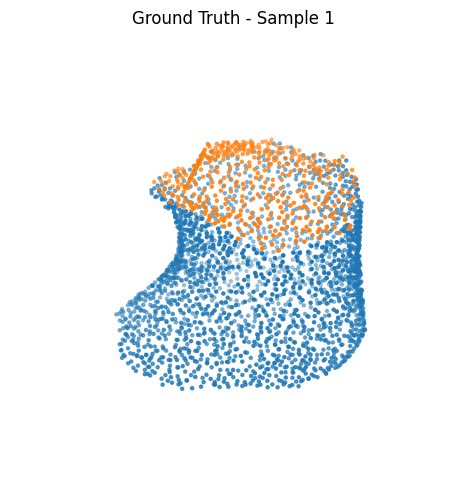

Unique classes [2 3]


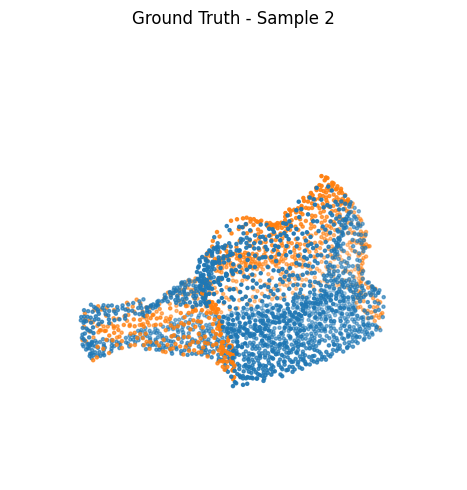

Unique classes [12 13]


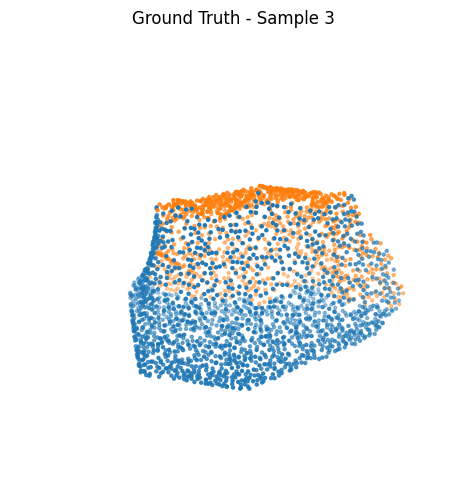

Unique classes [10 11]


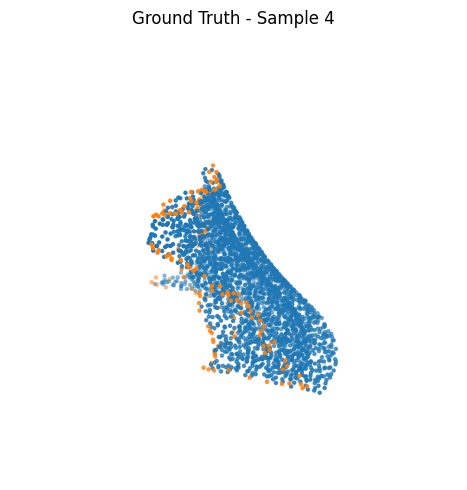

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_ground_truth_3d(test_loader, num_samples=4)

# PTF


In [9]:
from torch_geometric.nn import (
    MLP,
    PointTransformerConv,
    fps,
    global_mean_pool,
    knn,
    knn_graph,)


from torch.nn import Linear as Lin

class TransformerBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin_in = Lin(in_channels, in_channels)
        self.lin_out = Lin(out_channels, out_channels)

        self.pos_nn = MLP([3, 64, out_channels], norm=None, plain_last=False)

        self.attn_nn = MLP([out_channels, 64, out_channels], norm=None,
                           plain_last=False)

        self.transformer = PointTransformerConv(in_channels, out_channels,
                                                pos_nn=self.pos_nn,
                                                attn_nn=self.attn_nn)

    def forward(self, x, pos, edge_index):
        x = self.lin_in(x).relu()
        x = self.transformer(x, pos, edge_index)
        x = self.lin_out(x).relu()
        return x


class TransitionDown(torch.nn.Module):
    """Samples the input point cloud by a ratio percentage to reduce
    cardinality and uses an mlp to augment features dimensionnality.
    """
    def __init__(self, in_channels, out_channels, ratio=0.25, k=16):
        super().__init__()
        self.k = k
        self.ratio = ratio
        self.mlp = MLP([in_channels, out_channels], plain_last=False)

    def forward(self, x, pos, batch):
        # FPS sampling
        id_clusters = fps(pos, ratio=self.ratio, batch=batch)

        # compute for each cluster the k nearest points
        sub_batch = batch[id_clusters] if batch is not None else None

        # beware of self loop
        id_k_neighbor = knn(pos, pos[id_clusters], k=self.k, batch_x=batch,
                            batch_y=sub_batch)

        # transformation of features through a simple MLP
        x = self.mlp(x)

        # Max pool onto each cluster the features from knn in points
        x_out = scatter(x[id_k_neighbor[1]], id_k_neighbor[0], dim=0,
                        dim_size=id_clusters.size(0), reduce='max')

        # keep only the clusters and their max-pooled features
        sub_pos, out = pos[id_clusters], x_out
        return out, sub_pos, sub_batch



class TransitionUp(torch.nn.Module):
    """Reduce features dimensionality and interpolate back to higher
    resolution and cardinality.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp_sub = MLP([in_channels, out_channels], plain_last=False)
        self.mlp = MLP([out_channels, out_channels], plain_last=False)

    def forward(self, x, x_sub, pos, pos_sub, batch=None, batch_sub=None):
        # transform low-res features and reduce the number of features
        x_sub = self.mlp_sub(x_sub)

        # interpolate low-res feats to high-res points
        x_interpolated = knn_interpolate(x_sub, pos_sub, pos, k=3,
                                         batch_x=batch_sub, batch_y=batch)

        x = self.mlp(x) + x_interpolated

        return x


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dim_model, k=16):
        super().__init__()
        self.k = k

        # dummy feature is created if there is none given
        in_channels = max(in_channels, 1)

        # first block
        self.mlp_input = MLP([in_channels, dim_model[0]], plain_last=False)

        self.transformer_input = TransformerBlock(
            in_channels=dim_model[0],
            out_channels=dim_model[0],
        )

        # backbone layers
        self.transformers_up = torch.nn.ModuleList()
        self.transformers_down = torch.nn.ModuleList()
        self.transition_up = torch.nn.ModuleList()
        self.transition_down = torch.nn.ModuleList()

        for i in range(0, len(dim_model) - 1):

            # Add Transition Down block followed by a Point Transformer block
            self.transition_down.append(
                TransitionDown(in_channels=dim_model[i],
                               out_channels=dim_model[i + 1], k=self.k))

            self.transformers_down.append(
                TransformerBlock(in_channels=dim_model[i + 1],
                                 out_channels=dim_model[i + 1]))

            # Add Transition Up block followed by Point Transformer block
            self.transition_up.append(
                TransitionUp(in_channels=dim_model[i + 1],
                             out_channels=dim_model[i]))

            self.transformers_up.append(
                TransformerBlock(in_channels=dim_model[i],
                                 out_channels=dim_model[i]))

        # summit layers
        self.mlp_summit = MLP([dim_model[-1], dim_model[-1]], norm=None,
                              plain_last=False)

        self.transformer_summit = TransformerBlock(
            in_channels=dim_model[-1],
            out_channels=dim_model[-1],
        )

        # class score computation
        self.mlp_output = MLP([dim_model[0], 64, out_channels], norm=None)

    def forward(self, x, pos, batch=None):

        # add dummy features in case there is none
        if x is None:
            x = torch.ones((pos.shape[0], 1)).to(pos.get_device())

        out_x = []
        out_pos = []
        out_batch = []

        # first block
        x = self.mlp_input(x)
        edge_index = knn_graph(pos, k=self.k, batch=batch)
        x = self.transformer_input(x, pos, edge_index)

        # save outputs for skipping connections
        out_x.append(x)
        out_pos.append(pos)
        out_batch.append(batch)

        # backbone down : #reduce cardinality and augment dimensionnality
        for i in range(len(self.transformers_down)):
            x, pos, batch = self.transition_down[i](x, pos, batch=batch)
            edge_index = knn_graph(pos, k=self.k, batch=batch)
            x = self.transformers_down[i](x, pos, edge_index)

            out_x.append(x)
            out_pos.append(pos)
            out_batch.append(batch)

        # summit
        x = self.mlp_summit(x)
        edge_index = knn_graph(pos, k=self.k, batch=batch)
        x = self.transformer_summit(x, pos, edge_index)

        # backbone up : augment cardinality and reduce dimensionnality
        n = len(self.transformers_down)
        for i in range(n):
            x = self.transition_up[-i - 1](x=out_x[-i - 2], x_sub=x,
                                           pos=out_pos[-i - 2],
                                           pos_sub=out_pos[-i - 1],
                                           batch_sub=out_batch[-i - 1],
                                           batch=out_batch[-i - 2])

            edge_index = knn_graph(out_pos[-i - 2], k=self.k,
                                   batch=out_batch[-i - 2])
            x = self.transformers_up[-i - 1](x, out_pos[-i - 2], edge_index)

        # Class score
        out = self.mlp_output(x)

        return F.log_softmax(out, dim=-1)

In [10]:
def jaccard_index(pred: torch.Tensor, target: torch.Tensor, num_classes: int, absent_score: float = 1.0) -> float:
    """
    Compute mean Intersection over Union (IoU) between predicted and target labels.

    Args:
        pred (Tensor): Predicted labels (1D tensor of shape [N]).
        target (Tensor): Ground truth labels (1D tensor of shape [N]).
        num_classes (int): Number of classes to consider (usually the number of part labels for a category).
        absent_score (float): Score to assign if a class is absent in both pred and target.

    Returns:
        float: Mean IoU over classes.
    """
    device = pred.device
    ious = []

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()

        if union == 0:
            iou = torch.tensor(absent_score, device=device)
        else:
            iou = intersection.float() / union.float()
        ious.append(iou)

    # Stack and compute mean
    return torch.stack(ious).mean().item()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(3, train_dataset.num_classes, dim_model=[32, 64, 128, 256, 512],
            k=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)


In [12]:


import matplotlib.pyplot as plt

def train():
    model.train()
    loss_list = []
    acc_list = []
    total_loss = correct_nodes = total_nodes = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.pos, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes

        if (i + 1) % 10 == 0:
            tloss = total_loss / 10
            tacc = correct_nodes / total_nodes
            print(f'[{i+1}/{len(train_loader)}] Loss: {tloss:.4f} '
                  f'Train Acc: {tacc:.4f}')
            total_loss = correct_nodes = total_nodes = 0
            loss_list.append(tloss)
            acc_list.append(tacc)

    return np.mean(loss_list), np.mean(acc_list)

@torch.no_grad()
def test(loader):
    model.eval()

    ious, categories = [], []
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    for data in loader:
        data = data.to(device)
        outs = model(data.x, data.pos, data.batch)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)


            iou = jaccard_index(out[:, part].argmax(dim=-1), y_map[y],
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)
        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    return float(mean_iou.mean())  # Global IoU.

def plot_iou_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='dodgerblue')
    plt.title('IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test IoU')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()





CPU times: user 61 µs, sys: 0 ns, total: 61 µs
Wall time: 65.8 µs


[10/183] Loss: 2.7483 Train Acc: 0.1869
[20/183] Loss: 2.6257 Train Acc: 0.2956
[30/183] Loss: 2.4671 Train Acc: 0.3056
[40/183] Loss: 2.1900 Train Acc: 0.3471
[50/183] Loss: 2.2602 Train Acc: 0.2982
[60/183] Loss: 2.1837 Train Acc: 0.3073
[70/183] Loss: 2.1424 Train Acc: 0.2959
[80/183] Loss: 1.9027 Train Acc: 0.3902
[90/183] Loss: 2.1577 Train Acc: 0.2919
[100/183] Loss: 2.1458 Train Acc: 0.2742
[110/183] Loss: 2.0026 Train Acc: 0.3766
[120/183] Loss: 1.9990 Train Acc: 0.3412
[130/183] Loss: 2.0134 Train Acc: 0.3673
[140/183] Loss: 1.8588 Train Acc: 0.3870
[150/183] Loss: 1.9717 Train Acc: 0.4353
[160/183] Loss: 1.6867 Train Acc: 0.4486
[170/183] Loss: 1.7767 Train Acc: 0.4311
[180/183] Loss: 1.8826 Train Acc: 0.3896
Epoch: 01, Test IoU: 0.3885


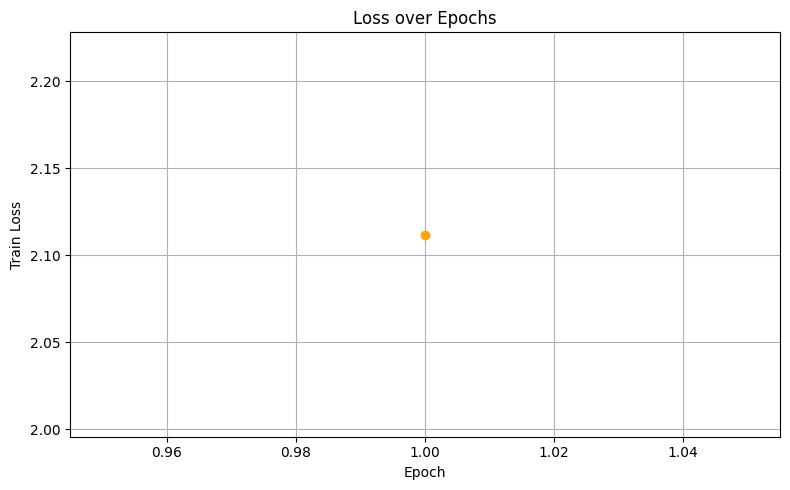

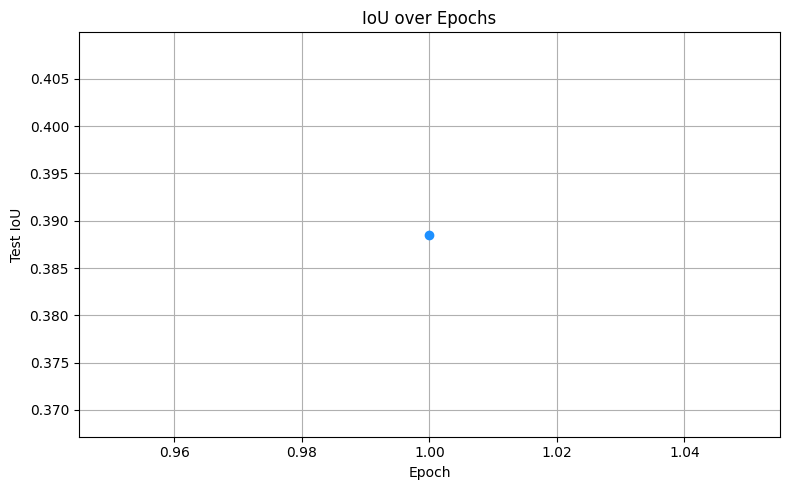

  >> Best model saved at epoch 1 with IoU: 0.3885
[10/183] Loss: 1.8786 Train Acc: 0.4160
[20/183] Loss: 1.8697 Train Acc: 0.3781
[30/183] Loss: 1.7583 Train Acc: 0.4296
[40/183] Loss: 1.8009 Train Acc: 0.3998
[50/183] Loss: 1.6235 Train Acc: 0.4247
[60/183] Loss: 1.7538 Train Acc: 0.3994
[70/183] Loss: 1.8179 Train Acc: 0.3996
[80/183] Loss: 1.7439 Train Acc: 0.4461
[90/183] Loss: 1.8356 Train Acc: 0.3547
[100/183] Loss: 1.8208 Train Acc: 0.4170
[110/183] Loss: 1.7685 Train Acc: 0.3703
[120/183] Loss: 2.0254 Train Acc: 0.3987
[130/183] Loss: 1.9524 Train Acc: 0.3545
[140/183] Loss: 1.6657 Train Acc: 0.4460
[150/183] Loss: 1.7276 Train Acc: 0.4368
[160/183] Loss: 1.6655 Train Acc: 0.4526
[170/183] Loss: 1.7716 Train Acc: 0.4014
[180/183] Loss: 1.7927 Train Acc: 0.3935
Epoch: 02, Test IoU: 0.4223


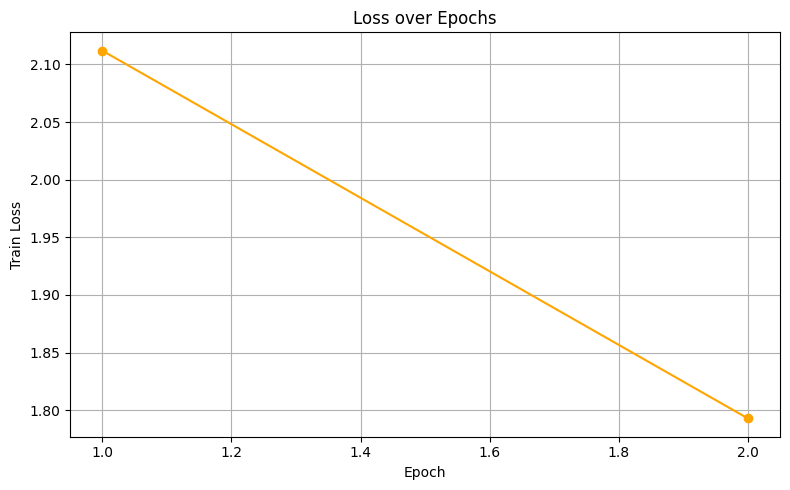

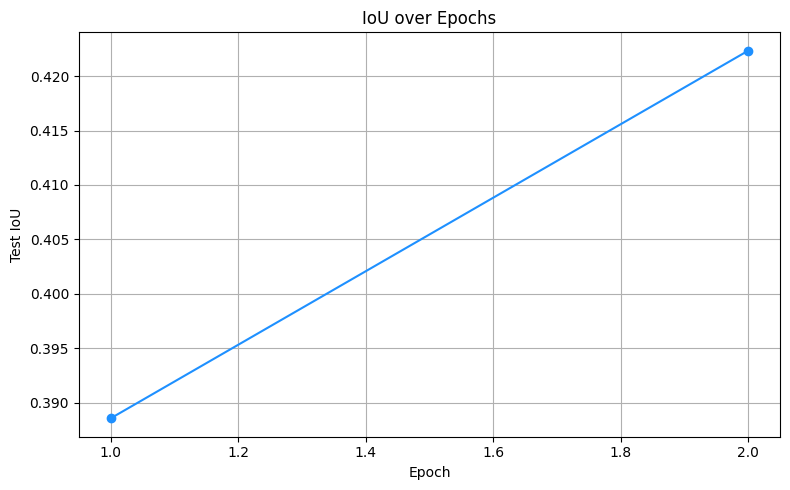

  >> Best model saved at epoch 2 with IoU: 0.4223
[10/183] Loss: 1.7682 Train Acc: 0.4064
[20/183] Loss: 1.5925 Train Acc: 0.4911
[30/183] Loss: 1.8129 Train Acc: 0.3523
[40/183] Loss: 2.1207 Train Acc: 0.3663
[50/183] Loss: 1.8501 Train Acc: 0.3891
[60/183] Loss: 1.6009 Train Acc: 0.4792
[70/183] Loss: 1.7554 Train Acc: 0.4141
[80/183] Loss: 1.7223 Train Acc: 0.4410
[90/183] Loss: 1.7752 Train Acc: 0.4266
[100/183] Loss: 1.7814 Train Acc: 0.4274
[110/183] Loss: 1.5476 Train Acc: 0.4592
[120/183] Loss: 1.8448 Train Acc: 0.3553
[130/183] Loss: 1.8682 Train Acc: 0.4241
[140/183] Loss: 1.8774 Train Acc: 0.3931
[150/183] Loss: 1.6108 Train Acc: 0.4450
[160/183] Loss: 1.8019 Train Acc: 0.4328
[170/183] Loss: 1.6720 Train Acc: 0.4598
[180/183] Loss: 1.7476 Train Acc: 0.4455
Epoch: 03, Test IoU: 0.4395


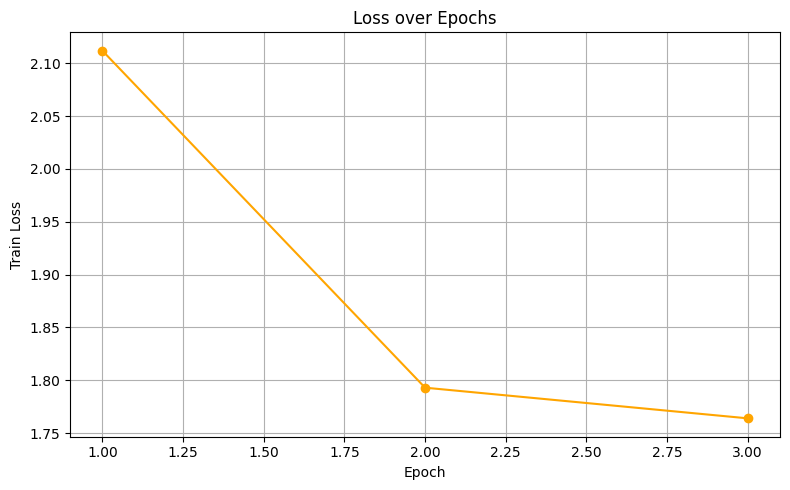

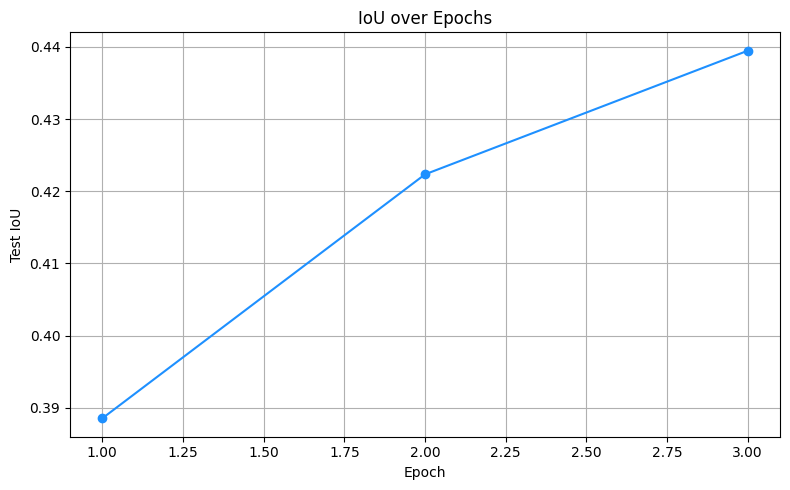

  >> Best model saved at epoch 3 with IoU: 0.4395
[10/183] Loss: 1.5617 Train Acc: 0.4654
[20/183] Loss: 1.6470 Train Acc: 0.4485
[30/183] Loss: 1.5306 Train Acc: 0.4934
[40/183] Loss: 1.7136 Train Acc: 0.4009
[50/183] Loss: 1.7233 Train Acc: 0.4345
[60/183] Loss: 1.9319 Train Acc: 0.3544
[70/183] Loss: 1.7926 Train Acc: 0.4326
[80/183] Loss: 1.6360 Train Acc: 0.4828
[90/183] Loss: 1.7739 Train Acc: 0.4346
[100/183] Loss: 1.5045 Train Acc: 0.4905
[110/183] Loss: 1.6596 Train Acc: 0.4539
[120/183] Loss: 1.8430 Train Acc: 0.3906
[130/183] Loss: 1.5087 Train Acc: 0.4914
[140/183] Loss: 1.6245 Train Acc: 0.4622
[150/183] Loss: 1.4525 Train Acc: 0.5097
[160/183] Loss: 1.6240 Train Acc: 0.4645
[170/183] Loss: 1.7598 Train Acc: 0.4507
[180/183] Loss: 1.6231 Train Acc: 0.4631
Epoch: 04, Test IoU: 0.4623


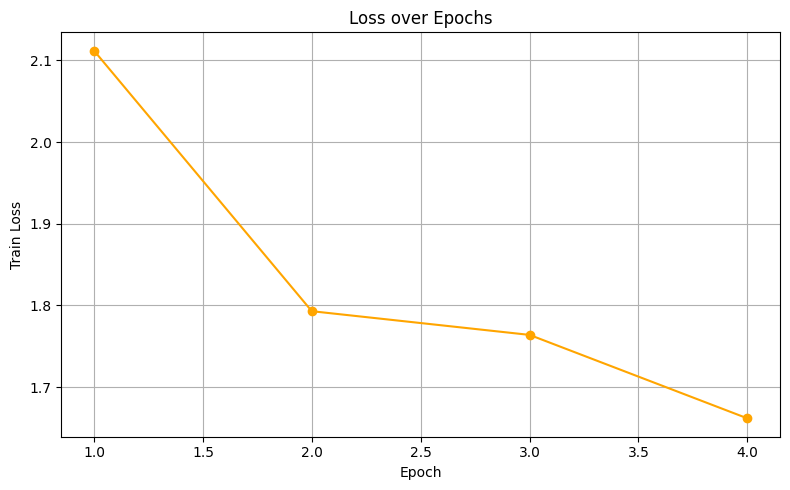

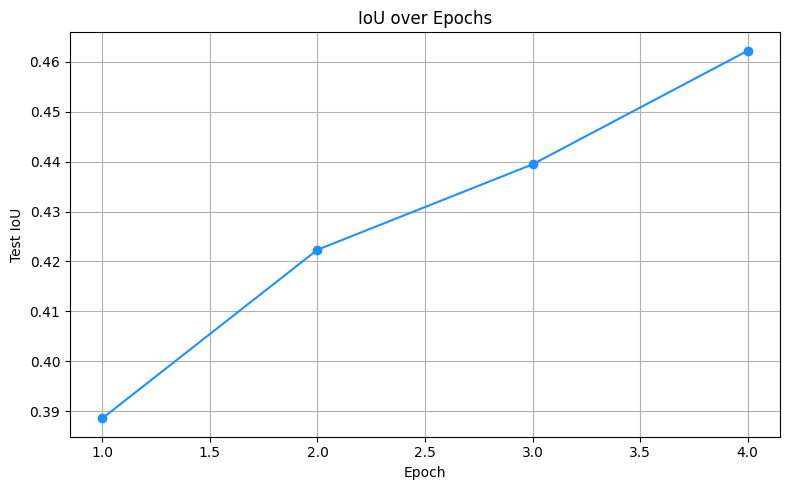

  >> Best model saved at epoch 4 with IoU: 0.4623
[10/183] Loss: 1.4604 Train Acc: 0.5047
[20/183] Loss: 1.6638 Train Acc: 0.4609
[30/183] Loss: 1.6007 Train Acc: 0.5135
[40/183] Loss: 1.6226 Train Acc: 0.4608
[50/183] Loss: 1.6067 Train Acc: 0.4670
[60/183] Loss: 1.6574 Train Acc: 0.4503
[70/183] Loss: 1.6293 Train Acc: 0.4417
[80/183] Loss: 1.5948 Train Acc: 0.5051
[90/183] Loss: 1.7310 Train Acc: 0.4106
[100/183] Loss: 1.4830 Train Acc: 0.4972
[110/183] Loss: 1.4414 Train Acc: 0.5230
[120/183] Loss: 2.0046 Train Acc: 0.4069
[130/183] Loss: 1.6141 Train Acc: 0.4357
[140/183] Loss: 1.5177 Train Acc: 0.4775
[150/183] Loss: 1.6193 Train Acc: 0.4793
[160/183] Loss: 1.5516 Train Acc: 0.4821
[170/183] Loss: 1.6763 Train Acc: 0.4648
[180/183] Loss: 1.5183 Train Acc: 0.4897
Epoch: 05, Test IoU: 0.4649


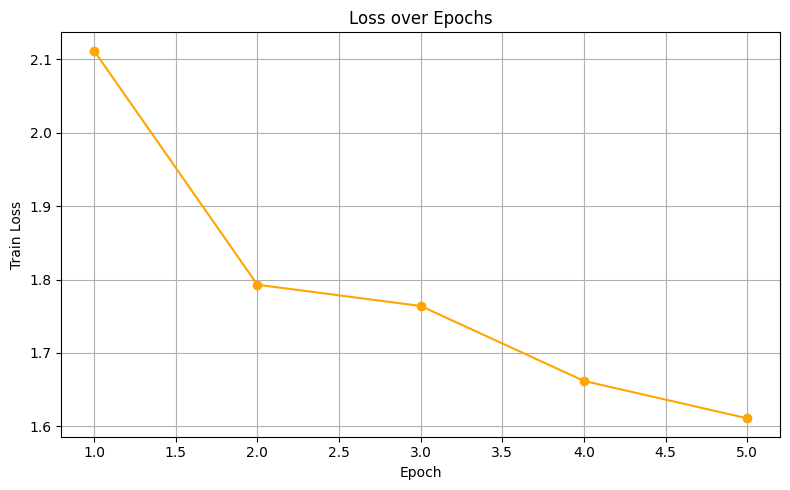

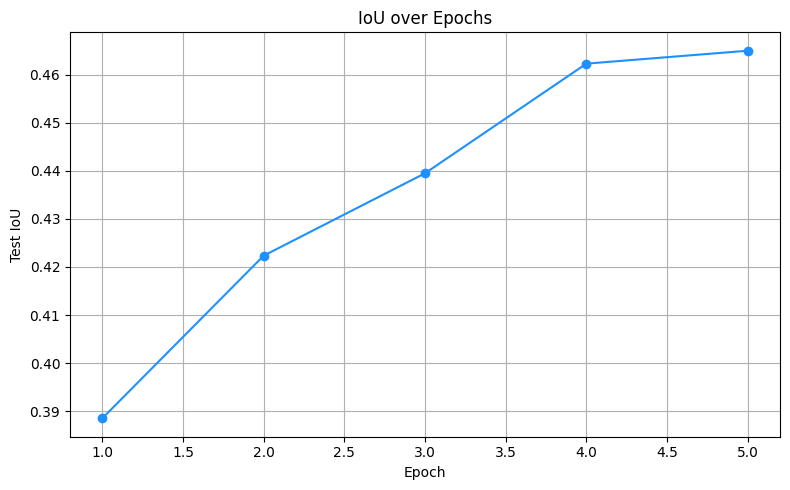

  >> Best model saved at epoch 5 with IoU: 0.4649
[10/183] Loss: 1.5887 Train Acc: 0.4706
[20/183] Loss: 1.4823 Train Acc: 0.4985
[30/183] Loss: 1.6083 Train Acc: 0.4798
[40/183] Loss: 1.4641 Train Acc: 0.5044
[50/183] Loss: 1.6044 Train Acc: 0.4581
[60/183] Loss: 1.5699 Train Acc: 0.4835
[70/183] Loss: 1.5813 Train Acc: 0.4783
[80/183] Loss: 1.4408 Train Acc: 0.5037
[90/183] Loss: 1.6749 Train Acc: 0.4474
[100/183] Loss: 1.6941 Train Acc: 0.4604
[110/183] Loss: 1.3674 Train Acc: 0.5594
[120/183] Loss: 1.2605 Train Acc: 0.5799
[130/183] Loss: 1.3773 Train Acc: 0.5515
[140/183] Loss: 1.4635 Train Acc: 0.5102
[150/183] Loss: 1.5893 Train Acc: 0.4816
[160/183] Loss: 1.5691 Train Acc: 0.4935
[170/183] Loss: 1.5098 Train Acc: 0.5111
[180/183] Loss: 1.3587 Train Acc: 0.5773
Epoch: 06, Test IoU: 0.4956


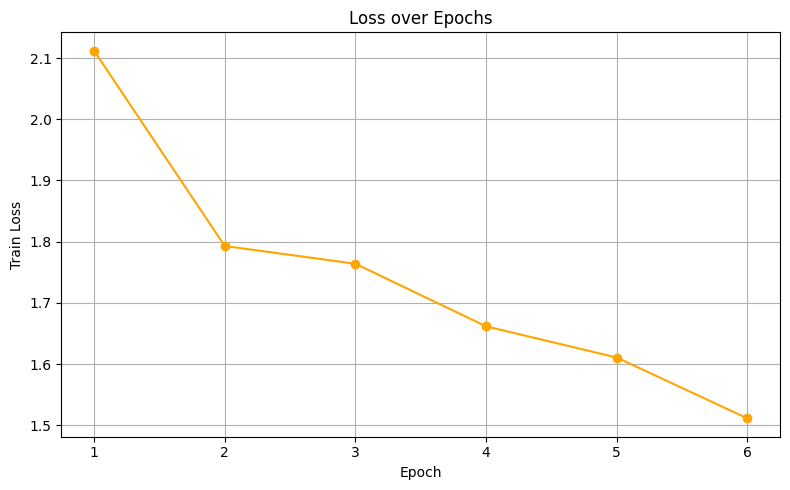

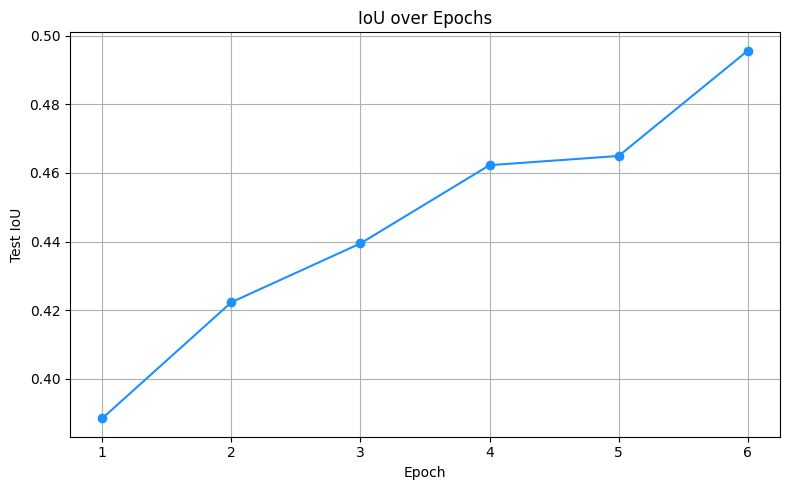

  >> Best model saved at epoch 6 with IoU: 0.4956
[10/183] Loss: 1.4579 Train Acc: 0.5267
[20/183] Loss: 1.4927 Train Acc: 0.5011
[30/183] Loss: 1.1746 Train Acc: 0.5927
[40/183] Loss: 1.2809 Train Acc: 0.5533
[50/183] Loss: 1.3903 Train Acc: 0.5175
[60/183] Loss: 1.4386 Train Acc: 0.4975
[70/183] Loss: 1.4398 Train Acc: 0.5122
[80/183] Loss: 1.3269 Train Acc: 0.5506
[90/183] Loss: 1.2714 Train Acc: 0.5751
[100/183] Loss: 1.6349 Train Acc: 0.5048
[110/183] Loss: 1.5735 Train Acc: 0.4609
[120/183] Loss: 1.4832 Train Acc: 0.5239
[130/183] Loss: 1.6811 Train Acc: 0.4603
[140/183] Loss: 1.2647 Train Acc: 0.6044
[150/183] Loss: 1.3630 Train Acc: 0.5585
[160/183] Loss: 1.5029 Train Acc: 0.5274
[170/183] Loss: 1.5553 Train Acc: 0.4929
[180/183] Loss: 1.3521 Train Acc: 0.5385
Epoch: 07, Test IoU: 0.4993


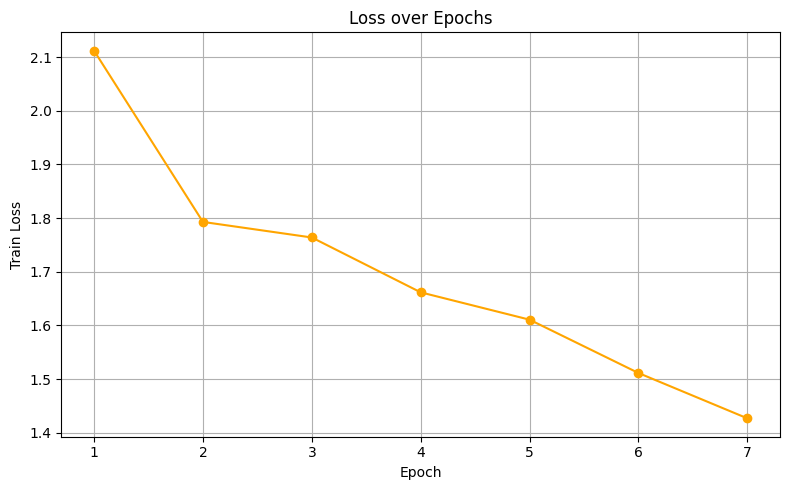

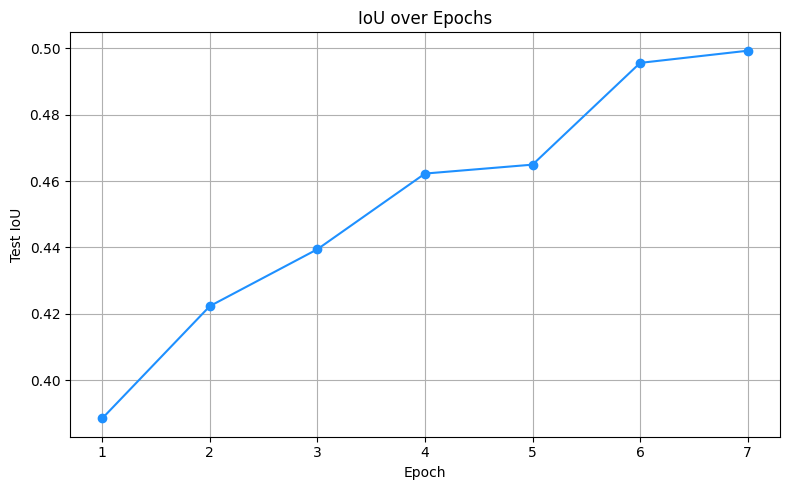

  >> Best model saved at epoch 7 with IoU: 0.4993
[10/183] Loss: 1.3486 Train Acc: 0.5478
[20/183] Loss: 1.4559 Train Acc: 0.5291
[30/183] Loss: 1.4867 Train Acc: 0.5137
[40/183] Loss: 1.5205 Train Acc: 0.5050
[50/183] Loss: 1.4083 Train Acc: 0.5389
[60/183] Loss: 1.2308 Train Acc: 0.5749
[70/183] Loss: 1.2936 Train Acc: 0.5623
[80/183] Loss: 1.4166 Train Acc: 0.5384
[90/183] Loss: 1.3788 Train Acc: 0.5333
[100/183] Loss: 1.1659 Train Acc: 0.5876
[110/183] Loss: 1.2505 Train Acc: 0.5874
[120/183] Loss: 1.3305 Train Acc: 0.5404
[130/183] Loss: 1.2970 Train Acc: 0.5570
[140/183] Loss: 1.1381 Train Acc: 0.5995
[150/183] Loss: 1.1637 Train Acc: 0.5719
[160/183] Loss: 1.3237 Train Acc: 0.5380
[170/183] Loss: 1.1246 Train Acc: 0.5971
[180/183] Loss: 1.3828 Train Acc: 0.5656
Epoch: 08, Test IoU: 0.5410


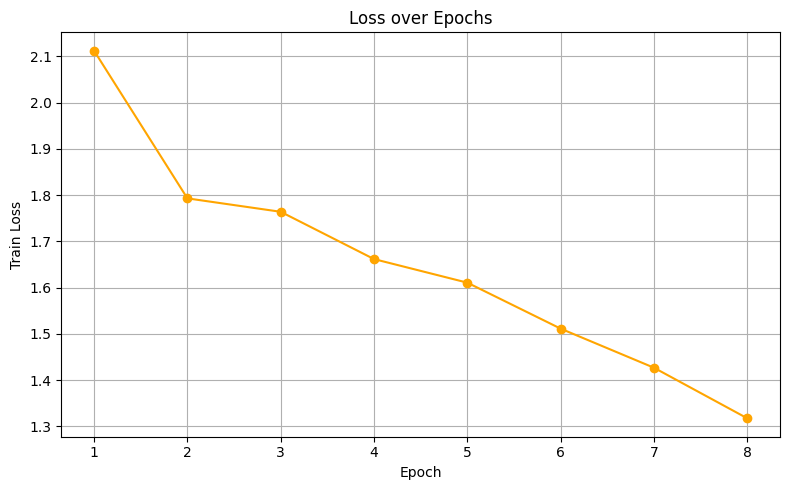

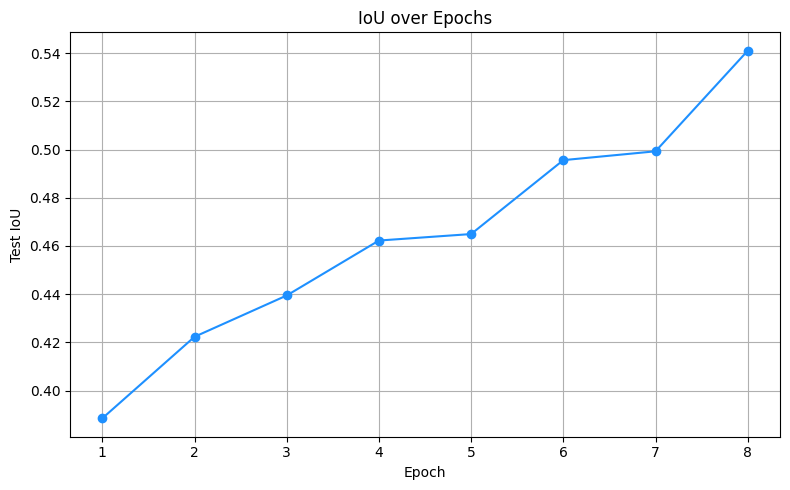

  >> Best model saved at epoch 8 with IoU: 0.5410
[10/183] Loss: 1.2020 Train Acc: 0.5899
[20/183] Loss: 1.3653 Train Acc: 0.5667
[30/183] Loss: 1.3195 Train Acc: 0.5660
[40/183] Loss: 1.3942 Train Acc: 0.5142
[50/183] Loss: 1.2289 Train Acc: 0.5884
[60/183] Loss: 1.5951 Train Acc: 0.4892
[70/183] Loss: 1.4576 Train Acc: 0.5004
[80/183] Loss: 1.3692 Train Acc: 0.5479
[90/183] Loss: 1.3348 Train Acc: 0.5687
[100/183] Loss: 1.3353 Train Acc: 0.5622
[110/183] Loss: 1.2284 Train Acc: 0.5684
[120/183] Loss: 1.2619 Train Acc: 0.5778
[130/183] Loss: 1.2166 Train Acc: 0.5821
[140/183] Loss: 1.2569 Train Acc: 0.5618
[150/183] Loss: 1.2753 Train Acc: 0.5583
[160/183] Loss: 1.3707 Train Acc: 0.5560
[170/183] Loss: 1.4127 Train Acc: 0.5504
[180/183] Loss: 1.3456 Train Acc: 0.5432
Epoch: 09, Test IoU: 0.5194


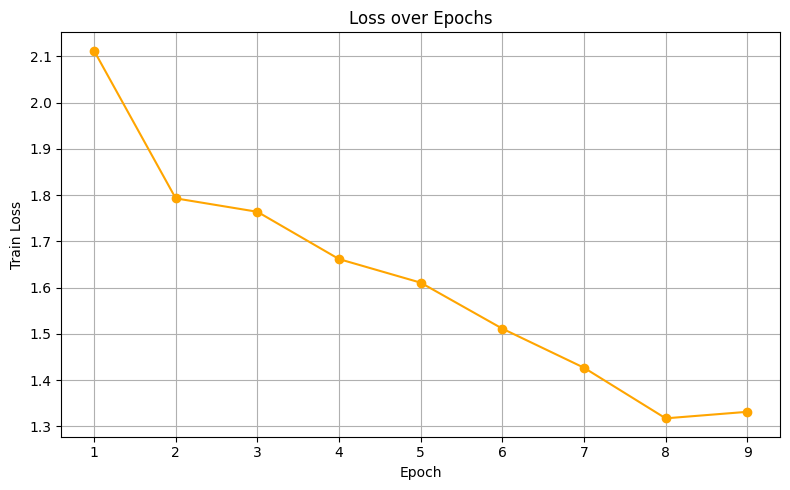

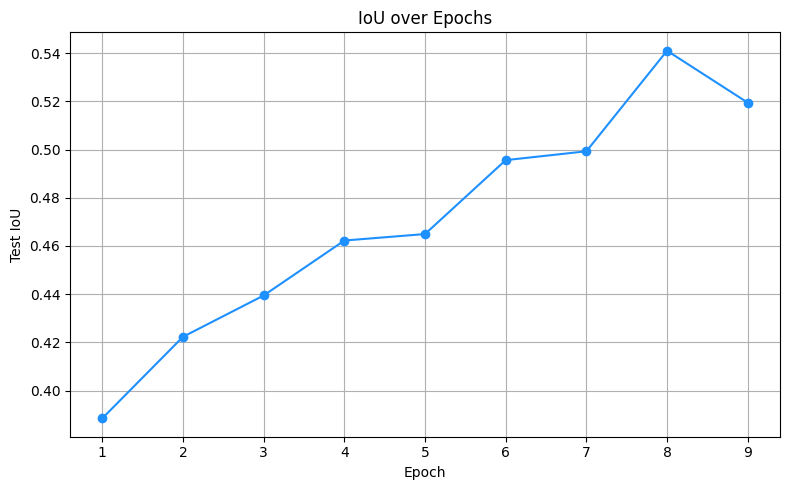

[10/183] Loss: 1.2039 Train Acc: 0.5797
[20/183] Loss: 1.2700 Train Acc: 0.5947
[30/183] Loss: 1.2439 Train Acc: 0.5980
[40/183] Loss: 1.1908 Train Acc: 0.6091
[50/183] Loss: 1.1311 Train Acc: 0.6023
[60/183] Loss: 1.2646 Train Acc: 0.5736
[70/183] Loss: 1.5111 Train Acc: 0.5026
[80/183] Loss: 1.3943 Train Acc: 0.5589
[90/183] Loss: 1.3323 Train Acc: 0.5480
[100/183] Loss: 1.6257 Train Acc: 0.5069
[110/183] Loss: 1.4892 Train Acc: 0.4903
[120/183] Loss: 1.1418 Train Acc: 0.6351
[130/183] Loss: 1.4686 Train Acc: 0.5056
[140/183] Loss: 1.3538 Train Acc: 0.5505
[150/183] Loss: 1.1437 Train Acc: 0.6148
[160/183] Loss: 1.3495 Train Acc: 0.5797
[170/183] Loss: 1.2770 Train Acc: 0.5750
[180/183] Loss: 1.3122 Train Acc: 0.5717
Epoch: 10, Test IoU: 0.5479


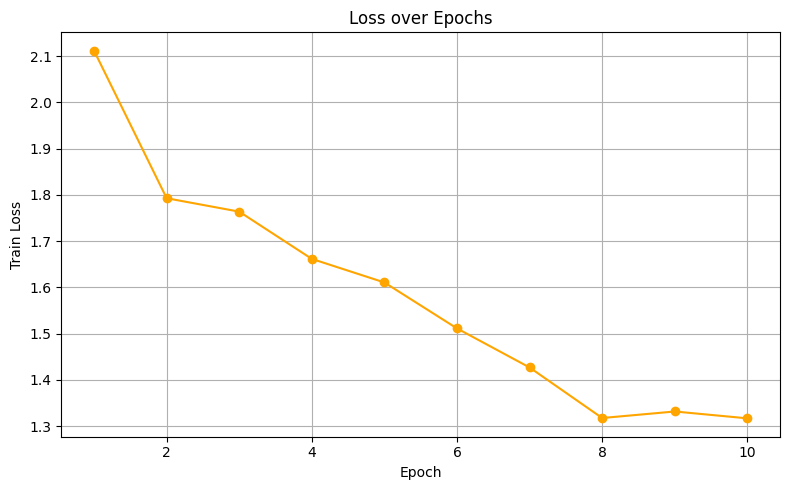

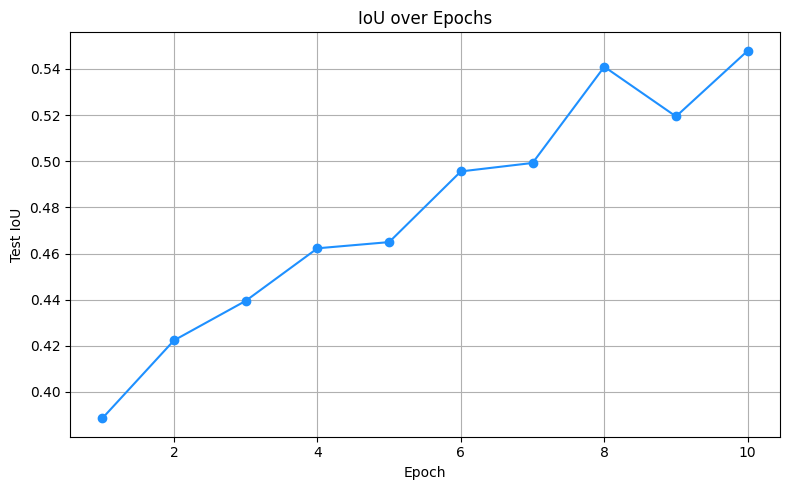

  >> Best model saved at epoch 10 with IoU: 0.5479
[10/183] Loss: 1.2651 Train Acc: 0.6220
[20/183] Loss: 1.2446 Train Acc: 0.5835
[30/183] Loss: 1.2970 Train Acc: 0.5760
[40/183] Loss: 1.4764 Train Acc: 0.5195
[50/183] Loss: 1.2302 Train Acc: 0.5863
[60/183] Loss: 1.3846 Train Acc: 0.5649
[70/183] Loss: 1.3332 Train Acc: 0.5544
[80/183] Loss: 1.3045 Train Acc: 0.5608
[90/183] Loss: 1.3688 Train Acc: 0.5188
[100/183] Loss: 1.2468 Train Acc: 0.5609
[110/183] Loss: 1.2237 Train Acc: 0.5780
[120/183] Loss: 1.2805 Train Acc: 0.5826
[130/183] Loss: 1.2857 Train Acc: 0.5511
[140/183] Loss: 1.1672 Train Acc: 0.6039
[150/183] Loss: 1.2545 Train Acc: 0.5809
[160/183] Loss: 1.1085 Train Acc: 0.6084
[170/183] Loss: 1.1112 Train Acc: 0.6116
[180/183] Loss: 1.1858 Train Acc: 0.5947
Epoch: 11, Test IoU: 0.5552


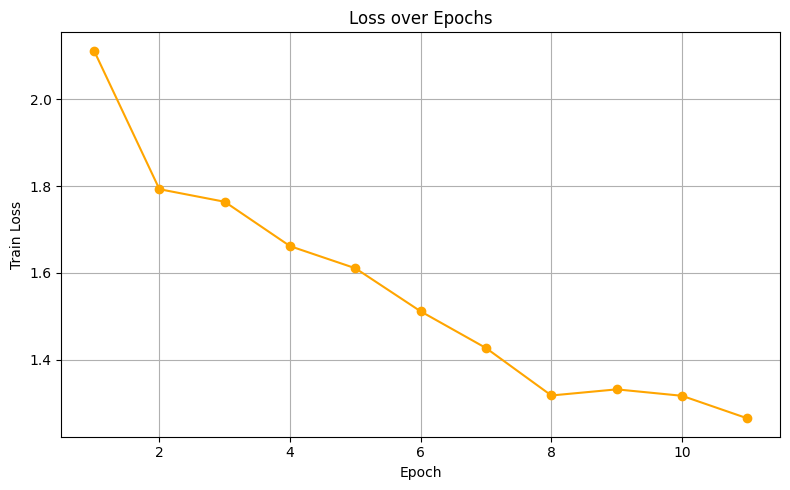

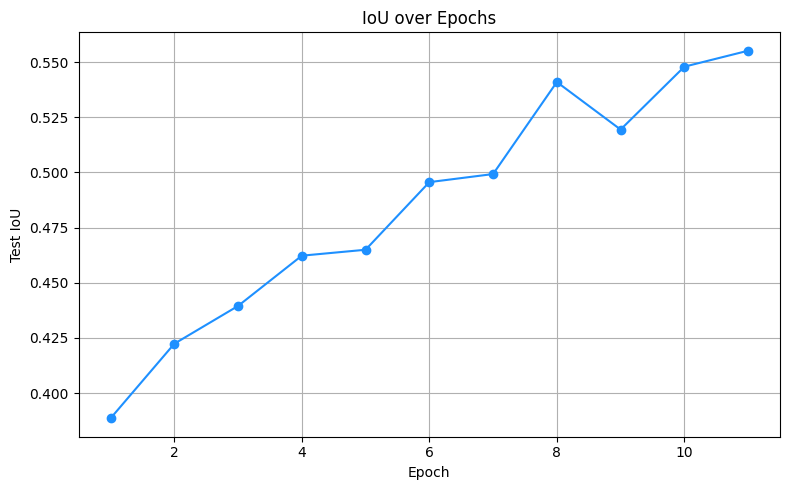

  >> Best model saved at epoch 11 with IoU: 0.5552
[10/183] Loss: 1.2355 Train Acc: 0.5987
[20/183] Loss: 1.1165 Train Acc: 0.6096
[30/183] Loss: 1.2574 Train Acc: 0.5687
[40/183] Loss: 1.2876 Train Acc: 0.5938
[50/183] Loss: 1.1752 Train Acc: 0.5949
[60/183] Loss: 1.1904 Train Acc: 0.5789
[70/183] Loss: 1.3232 Train Acc: 0.5764
[80/183] Loss: 1.3094 Train Acc: 0.5711
[90/183] Loss: 1.1144 Train Acc: 0.6055
[100/183] Loss: 1.1244 Train Acc: 0.6188
[110/183] Loss: 1.2198 Train Acc: 0.5807
[120/183] Loss: 1.3882 Train Acc: 0.5580
[130/183] Loss: 1.1159 Train Acc: 0.6273
[140/183] Loss: 1.1548 Train Acc: 0.5978
[150/183] Loss: 1.0578 Train Acc: 0.6676
[160/183] Loss: 1.1898 Train Acc: 0.6094
[170/183] Loss: 1.3175 Train Acc: 0.5512
[180/183] Loss: 1.4012 Train Acc: 0.5709
Epoch: 12, Test IoU: 0.5802


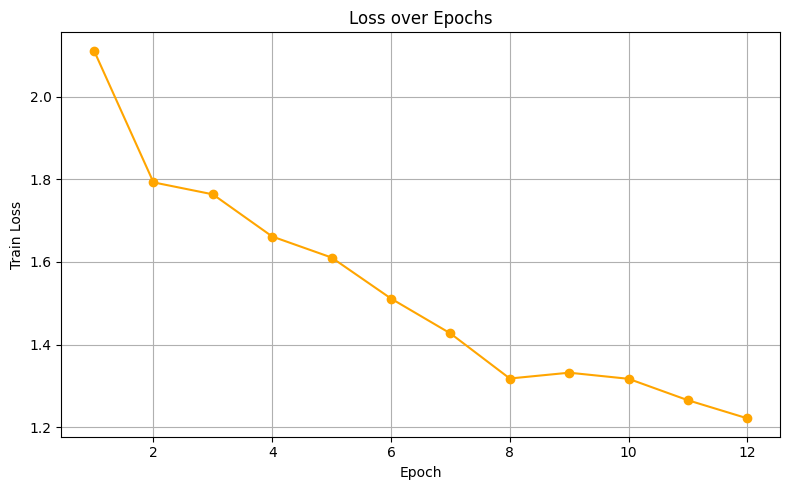

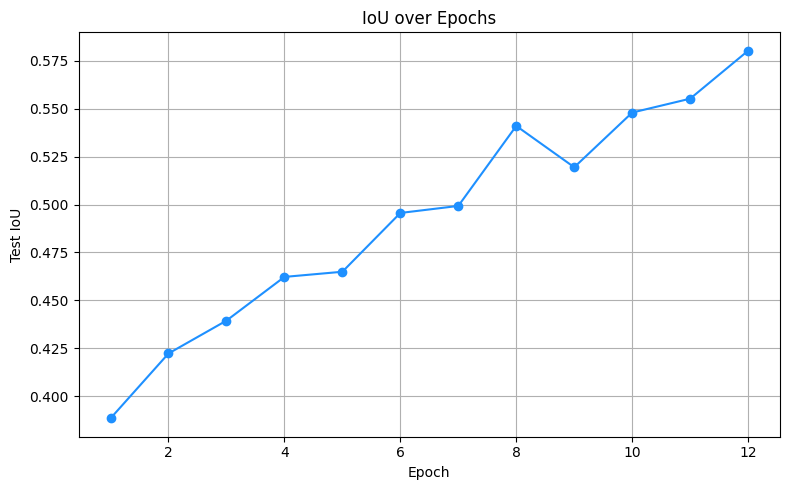

  >> Best model saved at epoch 12 with IoU: 0.5802
[10/183] Loss: 1.1594 Train Acc: 0.6008
[20/183] Loss: 1.0622 Train Acc: 0.6369
[30/183] Loss: 1.2099 Train Acc: 0.6046
[40/183] Loss: 1.1059 Train Acc: 0.6495
[50/183] Loss: 1.2540 Train Acc: 0.5937
[60/183] Loss: 1.3855 Train Acc: 0.5341
[70/183] Loss: 1.2010 Train Acc: 0.5882
[80/183] Loss: 1.4221 Train Acc: 0.5153
[90/183] Loss: 1.3851 Train Acc: 0.5248
[100/183] Loss: 1.2965 Train Acc: 0.5688
[110/183] Loss: 1.1421 Train Acc: 0.6356
[120/183] Loss: 1.1452 Train Acc: 0.5955
[130/183] Loss: 1.0755 Train Acc: 0.6486
[140/183] Loss: 1.1809 Train Acc: 0.6096
[150/183] Loss: 1.1336 Train Acc: 0.6245
[160/183] Loss: 1.1096 Train Acc: 0.6209
[170/183] Loss: 1.2243 Train Acc: 0.6055
[180/183] Loss: 1.0075 Train Acc: 0.6748
Epoch: 13, Test IoU: 0.5488


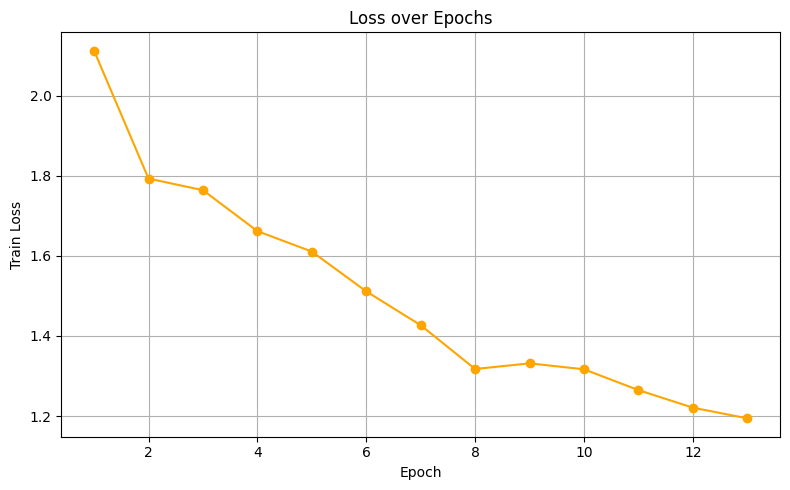

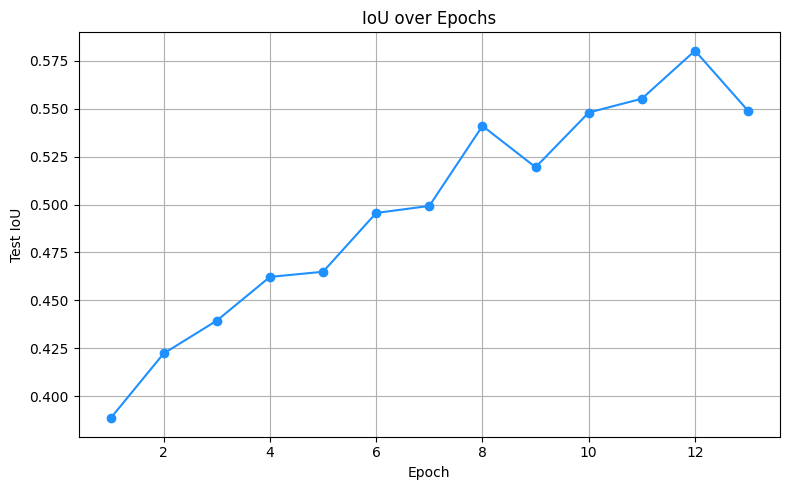

[10/183] Loss: 1.0959 Train Acc: 0.6265
[20/183] Loss: 1.0734 Train Acc: 0.6207
[30/183] Loss: 1.1742 Train Acc: 0.6147
[40/183] Loss: 1.1177 Train Acc: 0.6322
[50/183] Loss: 1.1181 Train Acc: 0.6201
[60/183] Loss: 1.0034 Train Acc: 0.6655
[70/183] Loss: 1.0787 Train Acc: 0.6317
[80/183] Loss: 1.1306 Train Acc: 0.6077
[90/183] Loss: 1.0597 Train Acc: 0.6476
[100/183] Loss: 1.3507 Train Acc: 0.5918
[110/183] Loss: 1.4956 Train Acc: 0.5733
[120/183] Loss: 1.2000 Train Acc: 0.5853
[130/183] Loss: 1.1647 Train Acc: 0.6044
[140/183] Loss: 1.1980 Train Acc: 0.5886
[150/183] Loss: 1.2412 Train Acc: 0.5930
[160/183] Loss: 1.2140 Train Acc: 0.6079
[170/183] Loss: 1.2599 Train Acc: 0.5632
[180/183] Loss: 0.9854 Train Acc: 0.6676
Epoch: 14, Test IoU: 0.5754


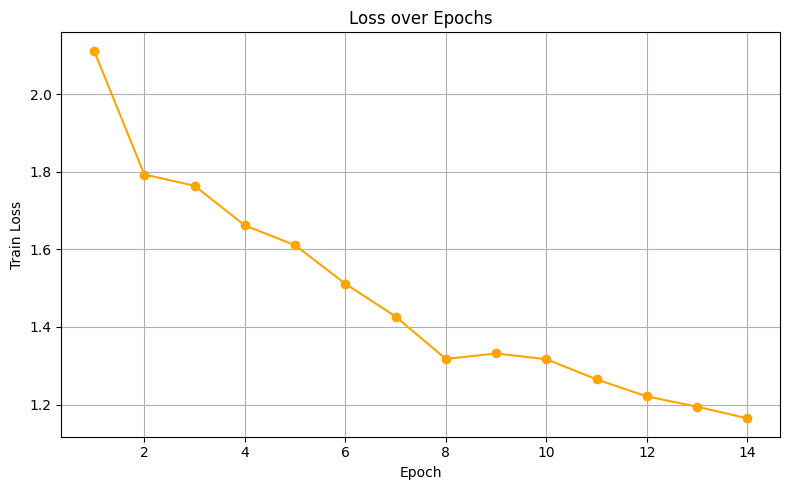

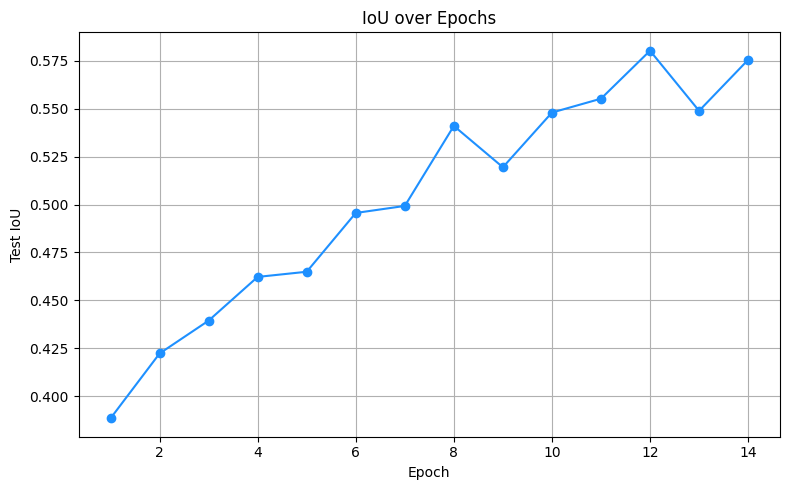

[10/183] Loss: 1.2951 Train Acc: 0.5834
[20/183] Loss: 1.4388 Train Acc: 0.5384
[30/183] Loss: 1.1100 Train Acc: 0.6226
[40/183] Loss: 1.2475 Train Acc: 0.5809
[50/183] Loss: 1.2816 Train Acc: 0.5566
[60/183] Loss: 1.1694 Train Acc: 0.5978
[70/183] Loss: 1.1720 Train Acc: 0.6003
[80/183] Loss: 1.1605 Train Acc: 0.6252
[90/183] Loss: 1.0186 Train Acc: 0.6423
[100/183] Loss: 1.0807 Train Acc: 0.6290
[110/183] Loss: 1.0907 Train Acc: 0.6410
[120/183] Loss: 0.8938 Train Acc: 0.7035
[130/183] Loss: 1.0613 Train Acc: 0.6349
[140/183] Loss: 1.1772 Train Acc: 0.6090
[150/183] Loss: 1.0742 Train Acc: 0.6443
[160/183] Loss: 1.1275 Train Acc: 0.6269
[170/183] Loss: 1.1455 Train Acc: 0.6280
[180/183] Loss: 1.1427 Train Acc: 0.6300
Epoch: 15, Test IoU: 0.5711


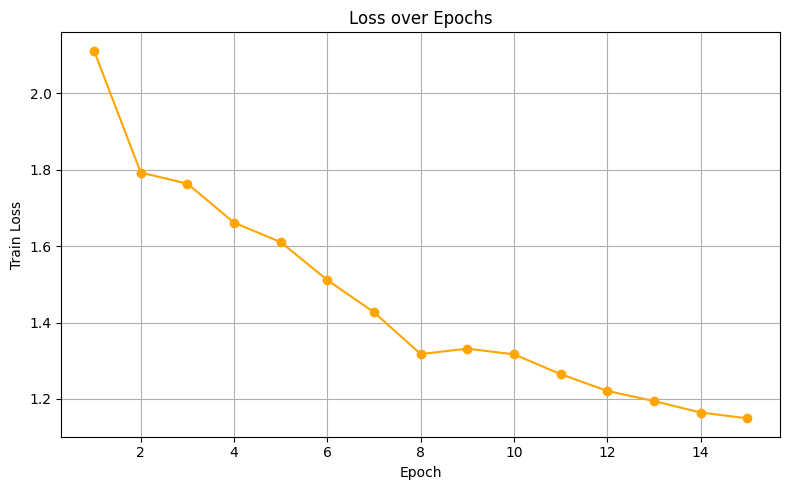

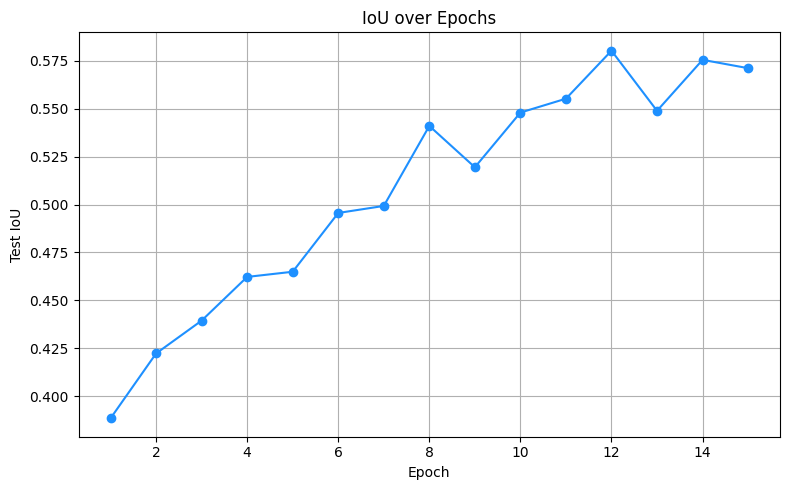

[10/183] Loss: 1.1836 Train Acc: 0.5826
[20/183] Loss: 1.1329 Train Acc: 0.6384
[30/183] Loss: 1.1980 Train Acc: 0.5963
[40/183] Loss: 1.1455 Train Acc: 0.6173
[50/183] Loss: 0.9182 Train Acc: 0.7023
[60/183] Loss: 1.0435 Train Acc: 0.6392
[70/183] Loss: 1.1530 Train Acc: 0.6071
[80/183] Loss: 1.1988 Train Acc: 0.5993
[90/183] Loss: 1.3492 Train Acc: 0.5471
[100/183] Loss: 1.0679 Train Acc: 0.6464
[110/183] Loss: 1.0552 Train Acc: 0.6684
[120/183] Loss: 1.2790 Train Acc: 0.5883
[130/183] Loss: 1.1036 Train Acc: 0.6269
[140/183] Loss: 1.1808 Train Acc: 0.6088
[150/183] Loss: 1.3185 Train Acc: 0.5668
[160/183] Loss: 1.0892 Train Acc: 0.6492
[170/183] Loss: 1.1147 Train Acc: 0.6178
[180/183] Loss: 1.0502 Train Acc: 0.6310
Epoch: 16, Test IoU: 0.5943


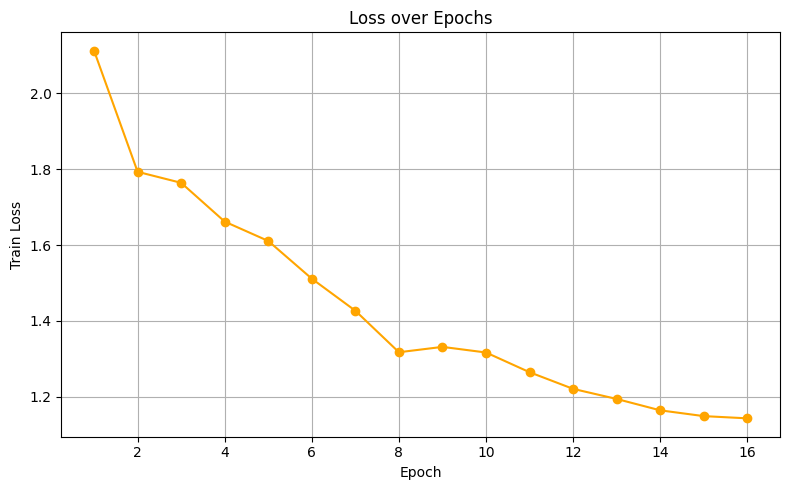

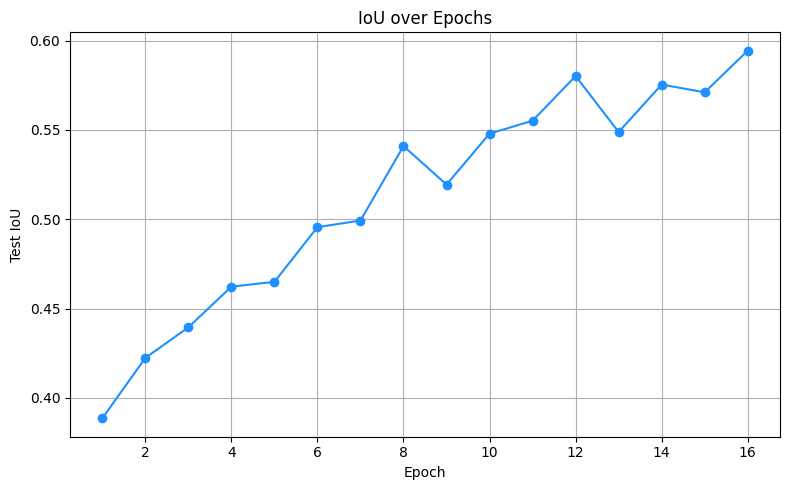

  >> Best model saved at epoch 16 with IoU: 0.5943
[10/183] Loss: 1.0764 Train Acc: 0.6655
[20/183] Loss: 1.3857 Train Acc: 0.5592
[30/183] Loss: 1.0419 Train Acc: 0.6625
[40/183] Loss: 1.2124 Train Acc: 0.5883
[50/183] Loss: 1.1499 Train Acc: 0.6365
[60/183] Loss: 1.1736 Train Acc: 0.6132
[70/183] Loss: 1.1972 Train Acc: 0.5891
[80/183] Loss: 1.0915 Train Acc: 0.6209
[90/183] Loss: 0.8756 Train Acc: 0.7090
[100/183] Loss: 1.0810 Train Acc: 0.6508
[110/183] Loss: 1.0094 Train Acc: 0.6546
[120/183] Loss: 1.0532 Train Acc: 0.6496
[130/183] Loss: 1.1967 Train Acc: 0.6082
[140/183] Loss: 1.1203 Train Acc: 0.6235
[150/183] Loss: 1.1686 Train Acc: 0.6199
[160/183] Loss: 1.0549 Train Acc: 0.6403
[170/183] Loss: 1.1094 Train Acc: 0.6129
[180/183] Loss: 1.0608 Train Acc: 0.6381
Epoch: 17, Test IoU: 0.5906


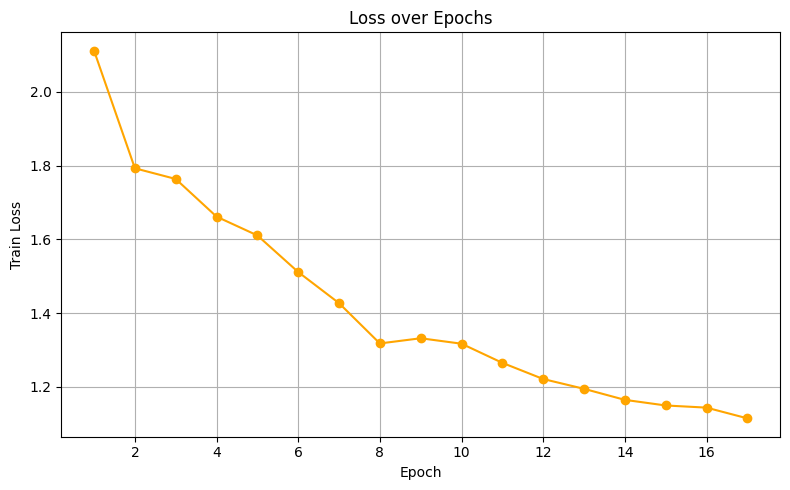

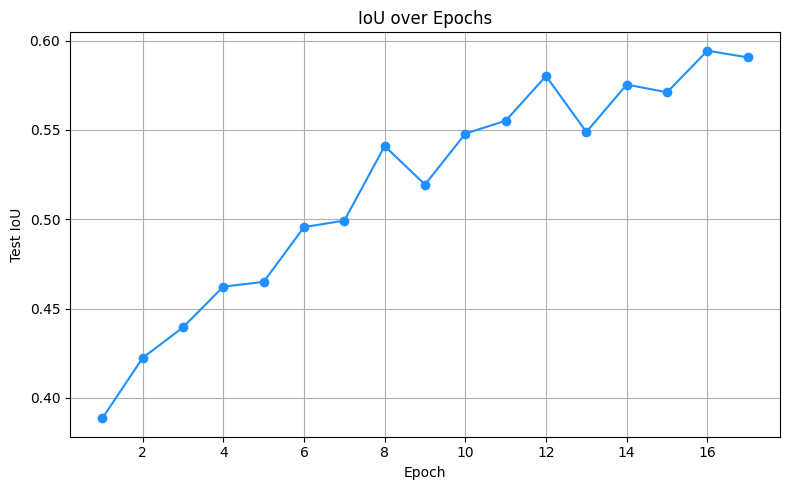

[10/183] Loss: 1.1320 Train Acc: 0.6098
[20/183] Loss: 1.0257 Train Acc: 0.6414
[30/183] Loss: 1.1502 Train Acc: 0.6207
[40/183] Loss: 1.1091 Train Acc: 0.6300
[50/183] Loss: 0.9934 Train Acc: 0.6578
[60/183] Loss: 0.8933 Train Acc: 0.6959
[70/183] Loss: 1.2399 Train Acc: 0.5881
[80/183] Loss: 0.9708 Train Acc: 0.6766
[90/183] Loss: 0.9834 Train Acc: 0.6625
[100/183] Loss: 1.1788 Train Acc: 0.6266
[110/183] Loss: 1.2354 Train Acc: 0.5806
[120/183] Loss: 1.0311 Train Acc: 0.6647
[130/183] Loss: 1.1114 Train Acc: 0.6389
[140/183] Loss: 1.0713 Train Acc: 0.6460
[150/183] Loss: 1.0306 Train Acc: 0.6499
[160/183] Loss: 1.1236 Train Acc: 0.6242
[170/183] Loss: 1.0411 Train Acc: 0.6634
[180/183] Loss: 1.0962 Train Acc: 0.6375
Epoch: 18, Test IoU: 0.5839


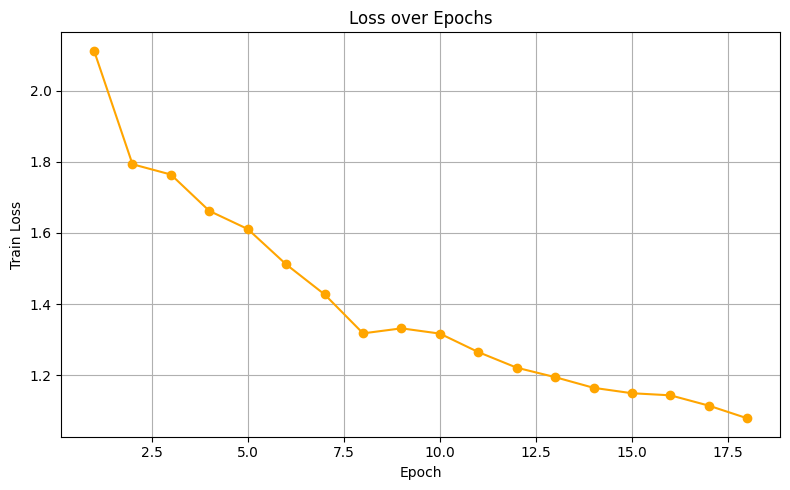

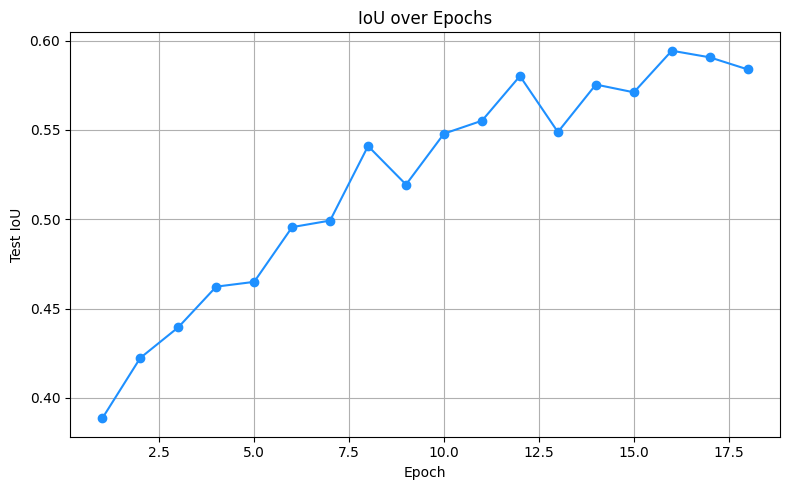

[10/183] Loss: 0.8936 Train Acc: 0.6896
[20/183] Loss: 0.9006 Train Acc: 0.6941
[30/183] Loss: 1.0936 Train Acc: 0.6169
[40/183] Loss: 0.9544 Train Acc: 0.6805
[50/183] Loss: 1.2572 Train Acc: 0.6146
[60/183] Loss: 0.9066 Train Acc: 0.6737
[70/183] Loss: 1.1897 Train Acc: 0.6214
[80/183] Loss: 1.0778 Train Acc: 0.6355
[90/183] Loss: 1.0716 Train Acc: 0.6229
[100/183] Loss: 0.9365 Train Acc: 0.6899
[110/183] Loss: 1.0271 Train Acc: 0.6303
[120/183] Loss: 0.9821 Train Acc: 0.6550
[130/183] Loss: 1.0625 Train Acc: 0.6423
[140/183] Loss: 1.0600 Train Acc: 0.6481
[150/183] Loss: 1.1512 Train Acc: 0.6164
[160/183] Loss: 1.0101 Train Acc: 0.6510
[170/183] Loss: 1.1861 Train Acc: 0.6182
[180/183] Loss: 1.3697 Train Acc: 0.5653
Epoch: 19, Test IoU: 0.4832


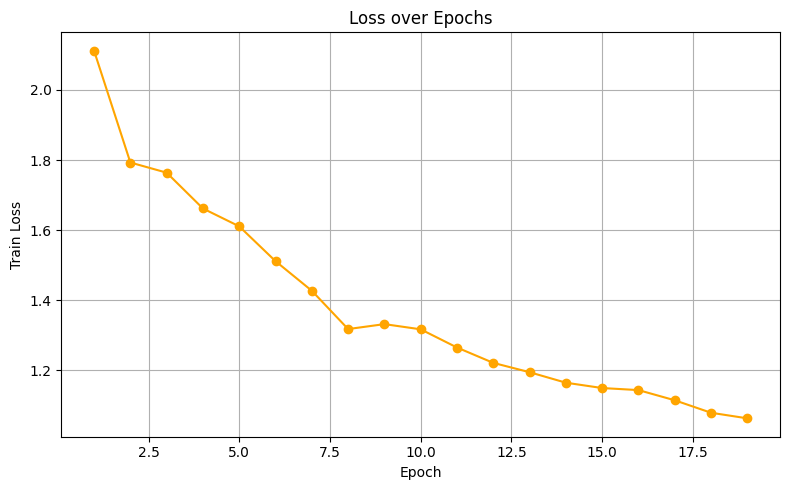

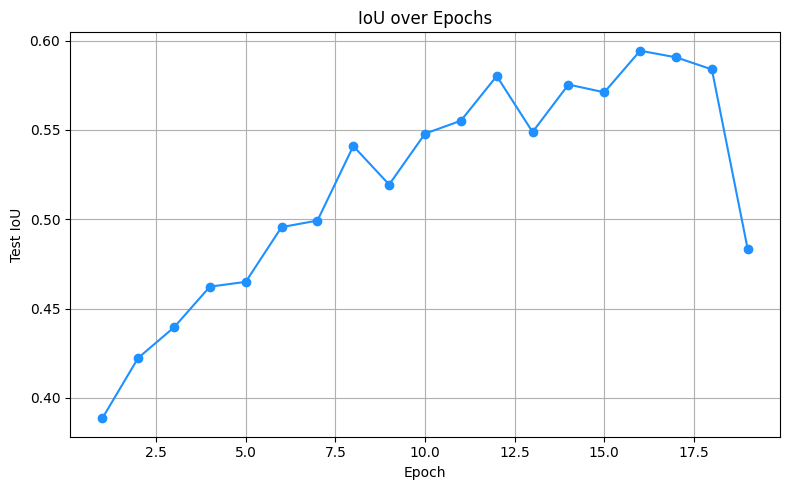

[10/183] Loss: 1.2928 Train Acc: 0.5852
[20/183] Loss: 1.1941 Train Acc: 0.6081
[30/183] Loss: 1.1156 Train Acc: 0.6324
[40/183] Loss: 0.9957 Train Acc: 0.6706
[50/183] Loss: 1.2123 Train Acc: 0.5873
[60/183] Loss: 0.9989 Train Acc: 0.6538
[70/183] Loss: 1.1114 Train Acc: 0.6281
[80/183] Loss: 0.9463 Train Acc: 0.6780
[90/183] Loss: 1.0501 Train Acc: 0.6373
[100/183] Loss: 0.9392 Train Acc: 0.6951
[110/183] Loss: 0.9430 Train Acc: 0.6874
[120/183] Loss: 0.9189 Train Acc: 0.6811
[130/183] Loss: 0.9204 Train Acc: 0.6657
[140/183] Loss: 0.9827 Train Acc: 0.6381
[150/183] Loss: 0.9849 Train Acc: 0.6616
[160/183] Loss: 1.1503 Train Acc: 0.6019
[170/183] Loss: 1.2276 Train Acc: 0.5997
[180/183] Loss: 0.8418 Train Acc: 0.7128
Epoch: 20, Test IoU: 0.6160


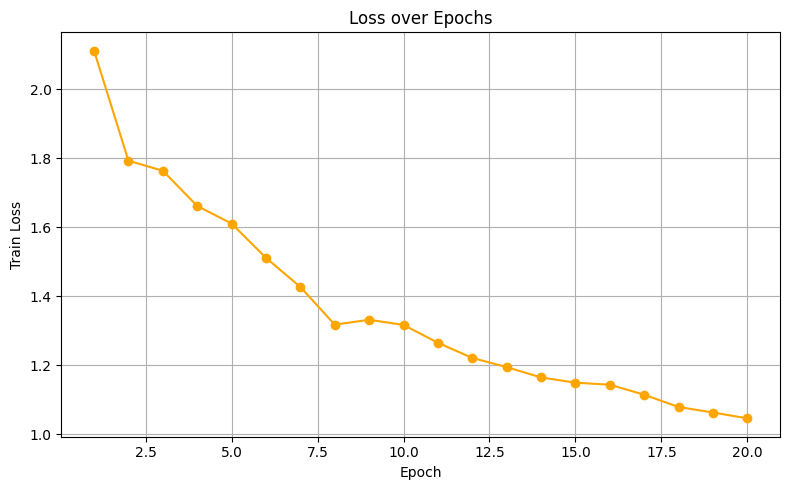

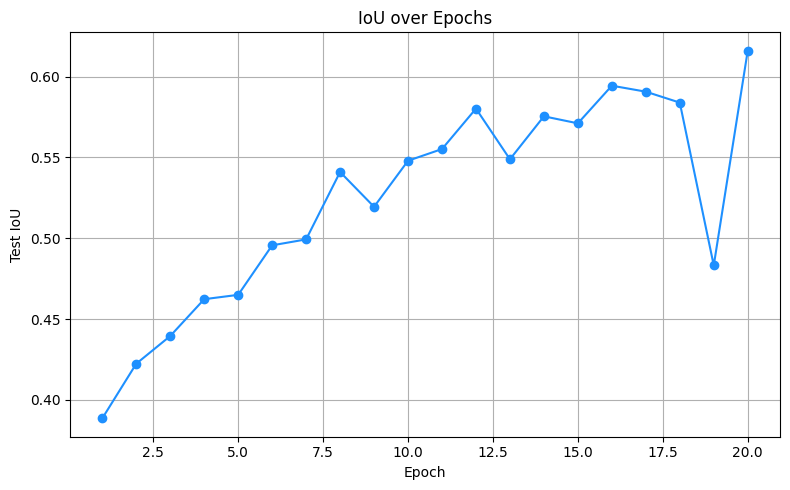

  >> Best model saved at epoch 20 with IoU: 0.6160
[10/183] Loss: 1.1250 Train Acc: 0.6354
[20/183] Loss: 0.8997 Train Acc: 0.6856
[30/183] Loss: 1.0762 Train Acc: 0.6131
[40/183] Loss: 0.8985 Train Acc: 0.6793
[50/183] Loss: 0.9588 Train Acc: 0.6797
[60/183] Loss: 0.9645 Train Acc: 0.6559
[70/183] Loss: 1.2041 Train Acc: 0.6081
[80/183] Loss: 0.9473 Train Acc: 0.6921
[90/183] Loss: 1.0499 Train Acc: 0.6193
[100/183] Loss: 1.0255 Train Acc: 0.6479
[110/183] Loss: 0.9883 Train Acc: 0.6506
[120/183] Loss: 0.9464 Train Acc: 0.6874
[130/183] Loss: 0.7807 Train Acc: 0.7264
[140/183] Loss: 1.0052 Train Acc: 0.6452
[150/183] Loss: 0.9061 Train Acc: 0.6793
[160/183] Loss: 0.9881 Train Acc: 0.6691
[170/183] Loss: 0.9058 Train Acc: 0.6986
[180/183] Loss: 0.8170 Train Acc: 0.7204
Epoch: 21, Test IoU: 0.6246


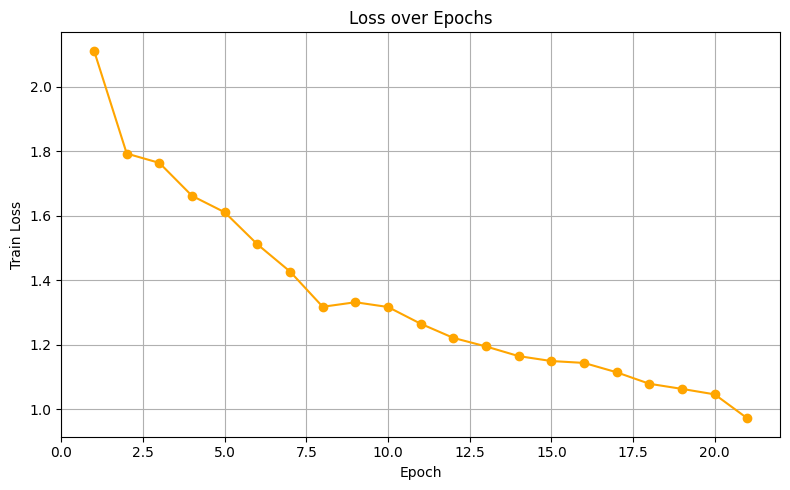

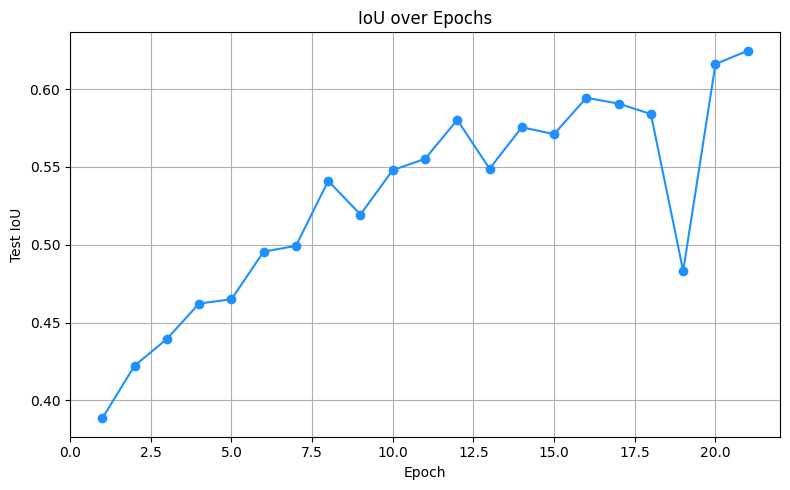

  >> Best model saved at epoch 21 with IoU: 0.6246
[10/183] Loss: 1.0174 Train Acc: 0.6543
[20/183] Loss: 0.9003 Train Acc: 0.6867
[30/183] Loss: 1.0358 Train Acc: 0.6542
[40/183] Loss: 0.8886 Train Acc: 0.7014
[50/183] Loss: 1.0121 Train Acc: 0.6504
[60/183] Loss: 1.2601 Train Acc: 0.6025
[70/183] Loss: 0.8868 Train Acc: 0.6964
[80/183] Loss: 0.9428 Train Acc: 0.6793
[90/183] Loss: 0.9401 Train Acc: 0.6815
[100/183] Loss: 0.9640 Train Acc: 0.6611
[110/183] Loss: 0.8979 Train Acc: 0.6974
[120/183] Loss: 0.9088 Train Acc: 0.6842
[130/183] Loss: 1.0065 Train Acc: 0.6582
[140/183] Loss: 1.0854 Train Acc: 0.6293
[150/183] Loss: 1.0327 Train Acc: 0.6389
[160/183] Loss: 0.9274 Train Acc: 0.6755
[170/183] Loss: 0.8742 Train Acc: 0.6920
[180/183] Loss: 0.8860 Train Acc: 0.6796
Epoch: 22, Test IoU: 0.6253


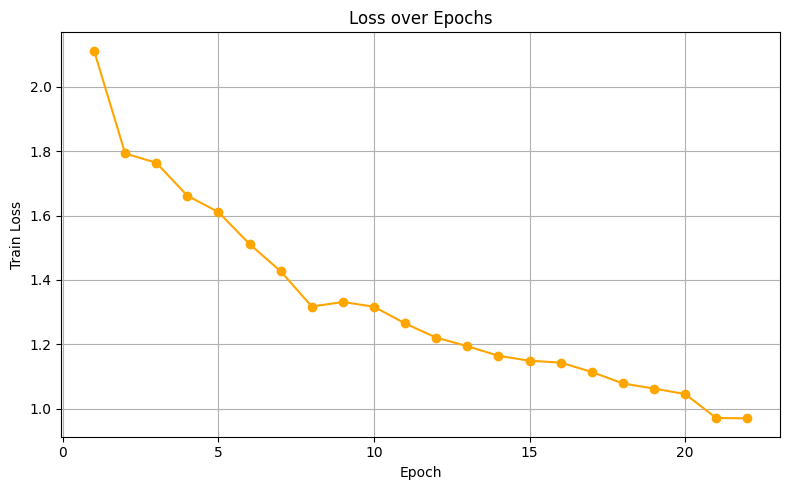

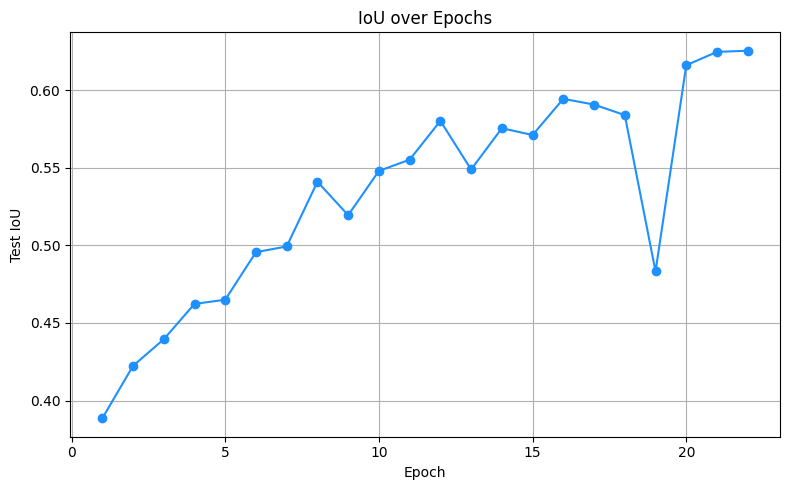

  >> Best model saved at epoch 22 with IoU: 0.6253
[10/183] Loss: 0.9430 Train Acc: 0.6778
[20/183] Loss: 1.0134 Train Acc: 0.6298
[30/183] Loss: 1.2591 Train Acc: 0.6000
[40/183] Loss: 0.9822 Train Acc: 0.6793
[50/183] Loss: 0.9090 Train Acc: 0.6825
[60/183] Loss: 0.8159 Train Acc: 0.7134
[70/183] Loss: 1.0297 Train Acc: 0.6412
[80/183] Loss: 0.7492 Train Acc: 0.7416
[90/183] Loss: 0.9477 Train Acc: 0.6764
[100/183] Loss: 0.9101 Train Acc: 0.6664
[110/183] Loss: 0.8686 Train Acc: 0.6800
[120/183] Loss: 1.2154 Train Acc: 0.6259
[130/183] Loss: 1.0016 Train Acc: 0.6704
[140/183] Loss: 1.1484 Train Acc: 0.6456
[150/183] Loss: 0.9802 Train Acc: 0.6476
[160/183] Loss: 0.9671 Train Acc: 0.6748
[170/183] Loss: 0.7779 Train Acc: 0.7176
[180/183] Loss: 0.8656 Train Acc: 0.7079
Epoch: 23, Test IoU: 0.6326


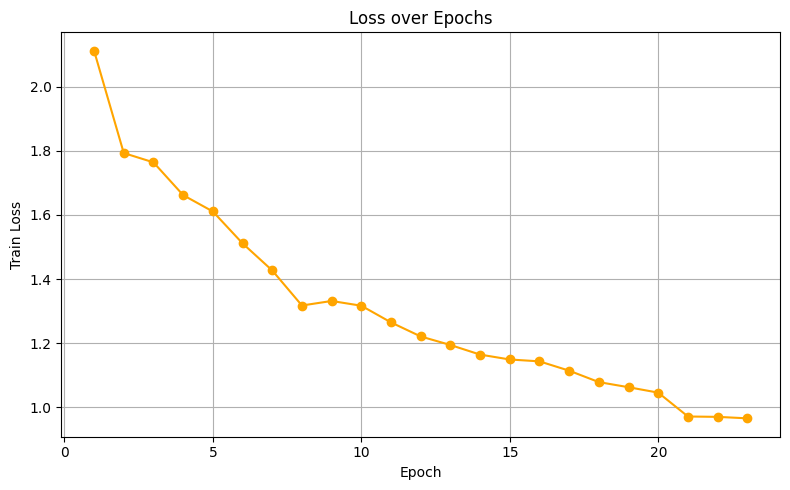

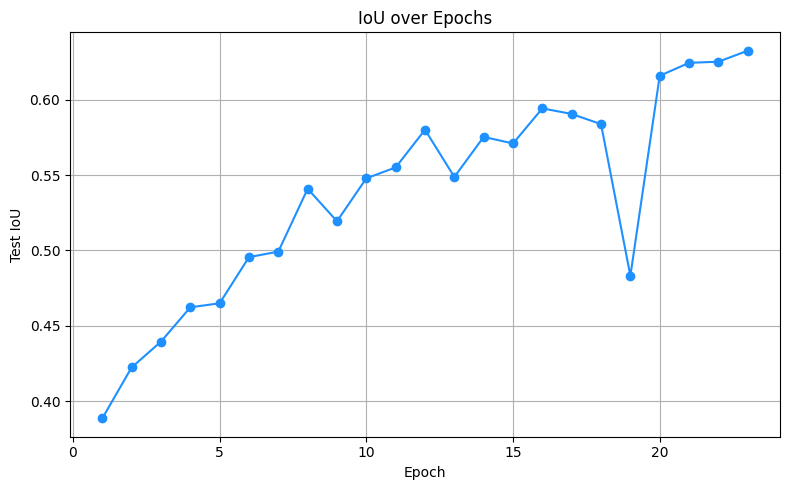

  >> Best model saved at epoch 23 with IoU: 0.6326
[10/183] Loss: 0.9794 Train Acc: 0.6674
[20/183] Loss: 1.0159 Train Acc: 0.6480
[30/183] Loss: 0.8315 Train Acc: 0.7101
[40/183] Loss: 0.9704 Train Acc: 0.6499
[50/183] Loss: 0.8499 Train Acc: 0.6971
[60/183] Loss: 0.9838 Train Acc: 0.6581
[70/183] Loss: 0.9589 Train Acc: 0.6896
[80/183] Loss: 1.0736 Train Acc: 0.6392
[90/183] Loss: 0.9670 Train Acc: 0.6636
[100/183] Loss: 0.8866 Train Acc: 0.6970
[110/183] Loss: 0.7913 Train Acc: 0.7284
[120/183] Loss: 0.8332 Train Acc: 0.7029
[130/183] Loss: 0.9968 Train Acc: 0.6723
[140/183] Loss: 0.9968 Train Acc: 0.6452
[150/183] Loss: 0.9284 Train Acc: 0.6972
[160/183] Loss: 0.9209 Train Acc: 0.6771
[170/183] Loss: 0.8463 Train Acc: 0.7154
[180/183] Loss: 0.9873 Train Acc: 0.6574
Epoch: 24, Test IoU: 0.6410


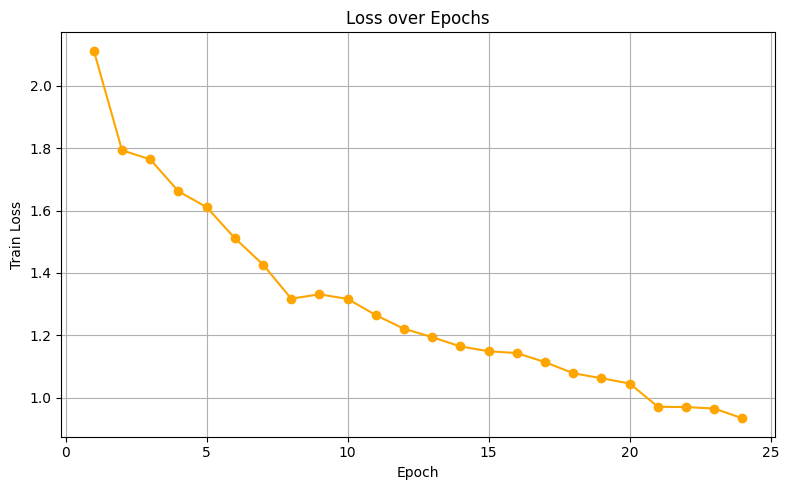

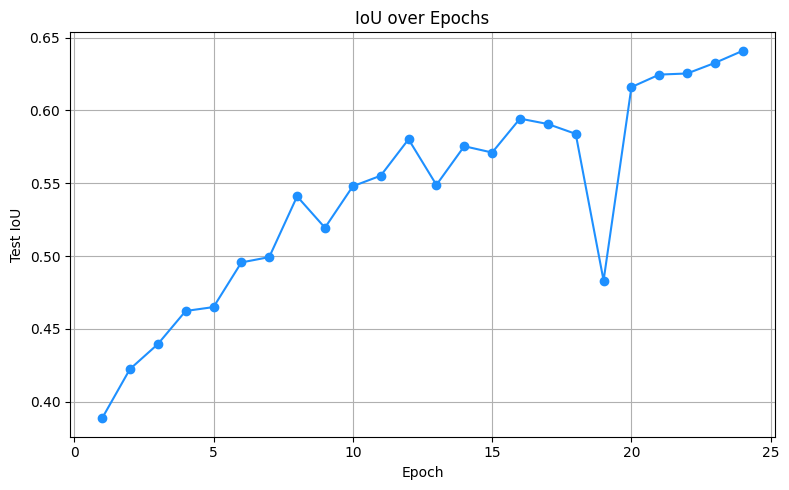

  >> Best model saved at epoch 24 with IoU: 0.6410
[10/183] Loss: 0.8172 Train Acc: 0.7257
[20/183] Loss: 0.9158 Train Acc: 0.6703
[30/183] Loss: 1.0635 Train Acc: 0.6564
[40/183] Loss: 0.8484 Train Acc: 0.6879
[50/183] Loss: 0.8342 Train Acc: 0.7084
[60/183] Loss: 0.7452 Train Acc: 0.7359
[70/183] Loss: 0.8437 Train Acc: 0.7167
[80/183] Loss: 0.8251 Train Acc: 0.7175
[90/183] Loss: 1.0297 Train Acc: 0.6546
[100/183] Loss: 1.0162 Train Acc: 0.6785
[110/183] Loss: 1.0062 Train Acc: 0.6397
[120/183] Loss: 0.8471 Train Acc: 0.7147
[130/183] Loss: 0.8886 Train Acc: 0.6845
[140/183] Loss: 0.8175 Train Acc: 0.6920
[150/183] Loss: 0.9600 Train Acc: 0.6745
[160/183] Loss: 0.8801 Train Acc: 0.6782
[170/183] Loss: 0.8808 Train Acc: 0.6958
[180/183] Loss: 0.8265 Train Acc: 0.7218
Epoch: 25, Test IoU: 0.6644


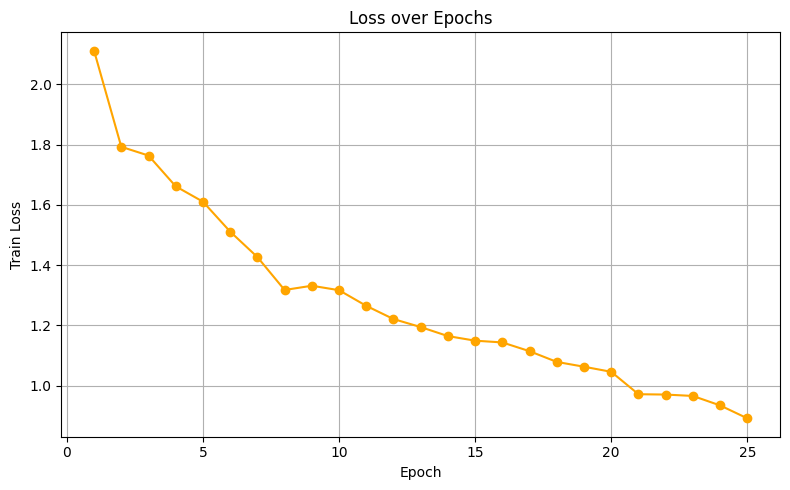

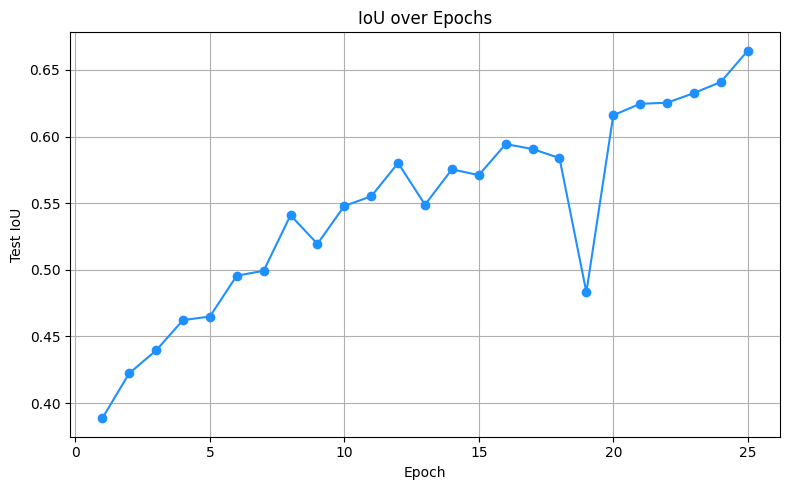

  >> Best model saved at epoch 25 with IoU: 0.6644
[10/183] Loss: 0.7794 Train Acc: 0.7337
[20/183] Loss: 0.8871 Train Acc: 0.6861
[30/183] Loss: 0.8466 Train Acc: 0.6918
[40/183] Loss: 0.8205 Train Acc: 0.7109
[50/183] Loss: 0.8922 Train Acc: 0.6898
[60/183] Loss: 0.7908 Train Acc: 0.7114
[70/183] Loss: 0.8431 Train Acc: 0.7234
[80/183] Loss: 0.9297 Train Acc: 0.6526
[90/183] Loss: 0.9040 Train Acc: 0.6720
[100/183] Loss: 0.7784 Train Acc: 0.7323
[110/183] Loss: 0.9862 Train Acc: 0.6582
[120/183] Loss: 1.0194 Train Acc: 0.6611
[130/183] Loss: 0.7744 Train Acc: 0.7096
[140/183] Loss: 0.9356 Train Acc: 0.6628
[150/183] Loss: 0.9889 Train Acc: 0.6398
[160/183] Loss: 0.7586 Train Acc: 0.7349
[170/183] Loss: 0.9947 Train Acc: 0.6451
[180/183] Loss: 1.0041 Train Acc: 0.6765
Epoch: 26, Test IoU: 0.6422


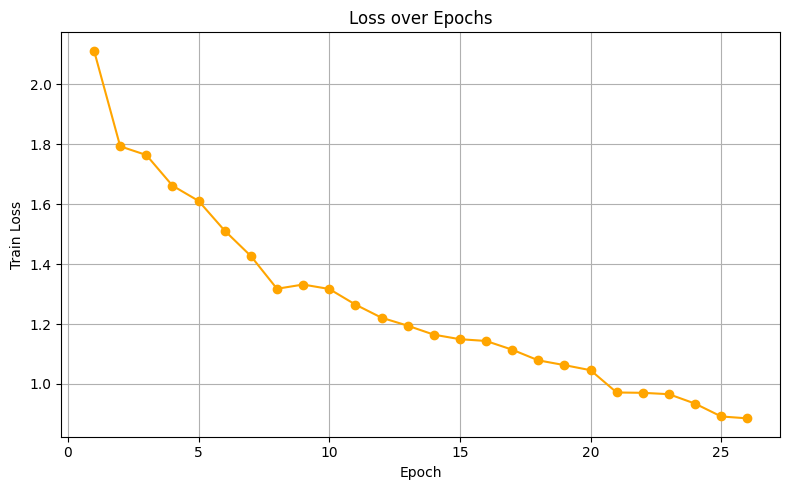

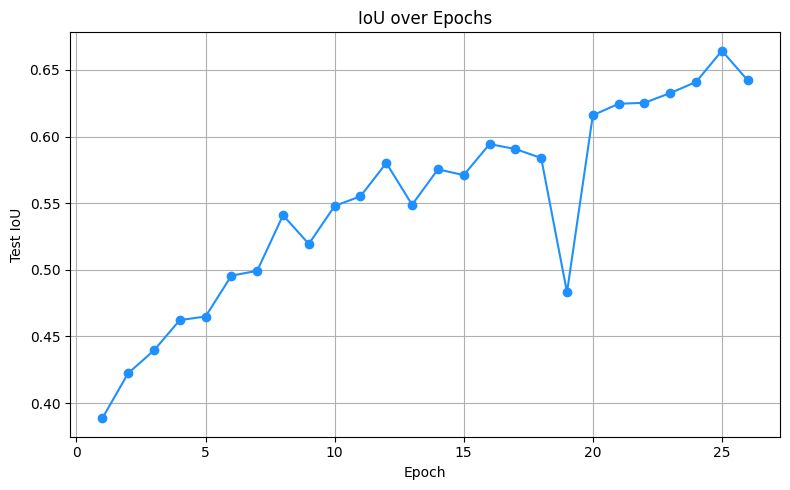

[10/183] Loss: 0.7679 Train Acc: 0.7345
[20/183] Loss: 0.8209 Train Acc: 0.7209
[30/183] Loss: 0.7953 Train Acc: 0.7233
[40/183] Loss: 1.1356 Train Acc: 0.6109
[50/183] Loss: 0.8815 Train Acc: 0.6850
[60/183] Loss: 0.9840 Train Acc: 0.6623
[70/183] Loss: 1.0302 Train Acc: 0.6474
[80/183] Loss: 0.8535 Train Acc: 0.7032
[90/183] Loss: 0.8498 Train Acc: 0.6943
[100/183] Loss: 1.0591 Train Acc: 0.6473
[110/183] Loss: 0.6821 Train Acc: 0.7595
[120/183] Loss: 0.8473 Train Acc: 0.6773
[130/183] Loss: 0.7379 Train Acc: 0.7321
[140/183] Loss: 0.9290 Train Acc: 0.6894
[150/183] Loss: 0.9047 Train Acc: 0.6829
[160/183] Loss: 0.8425 Train Acc: 0.7074
[170/183] Loss: 0.7271 Train Acc: 0.7457
[180/183] Loss: 0.9315 Train Acc: 0.6698
Epoch: 27, Test IoU: 0.6578


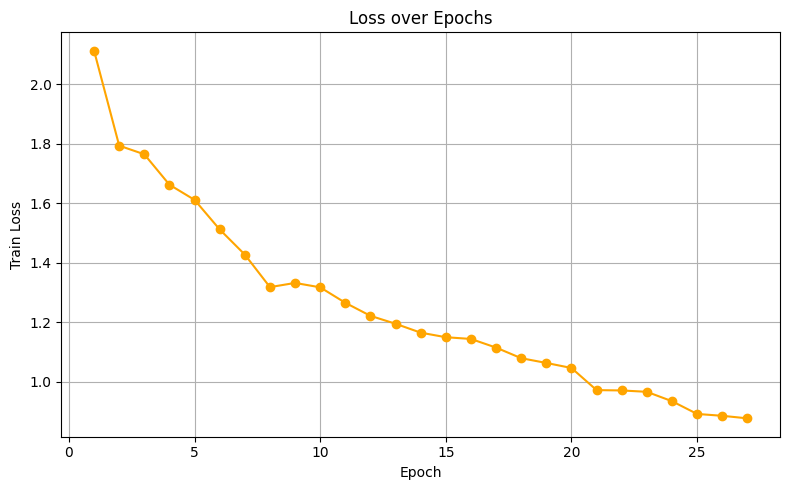

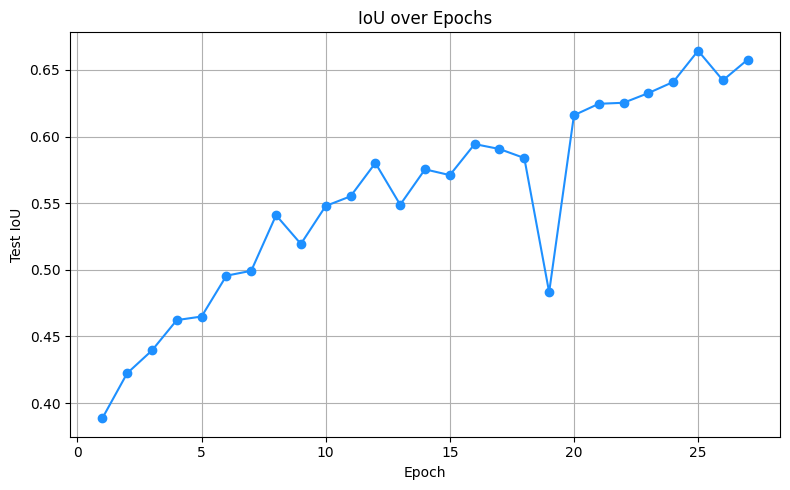

[10/183] Loss: 0.9520 Train Acc: 0.6651
[20/183] Loss: 0.9763 Train Acc: 0.6781
[30/183] Loss: 0.7070 Train Acc: 0.7418
[40/183] Loss: 0.7594 Train Acc: 0.7276
[50/183] Loss: 0.9874 Train Acc: 0.6934
[60/183] Loss: 1.0611 Train Acc: 0.6432
[70/183] Loss: 0.9061 Train Acc: 0.6888
[80/183] Loss: 0.7520 Train Acc: 0.7192
[90/183] Loss: 0.7657 Train Acc: 0.7280
[100/183] Loss: 1.0183 Train Acc: 0.6514
[110/183] Loss: 0.9476 Train Acc: 0.6585
[120/183] Loss: 0.8381 Train Acc: 0.6834
[130/183] Loss: 0.7549 Train Acc: 0.7370
[140/183] Loss: 0.8220 Train Acc: 0.7108
[150/183] Loss: 0.9276 Train Acc: 0.6944
[160/183] Loss: 0.7030 Train Acc: 0.7493
[170/183] Loss: 0.7419 Train Acc: 0.7255
[180/183] Loss: 0.8547 Train Acc: 0.6972
Epoch: 28, Test IoU: 0.6741


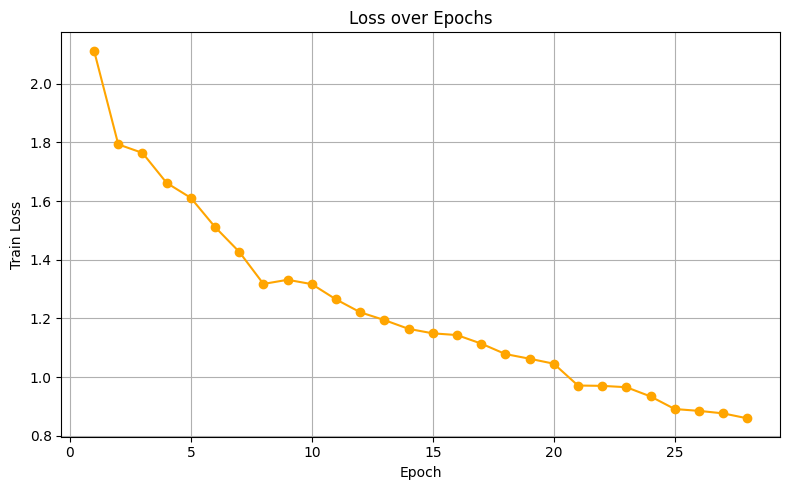

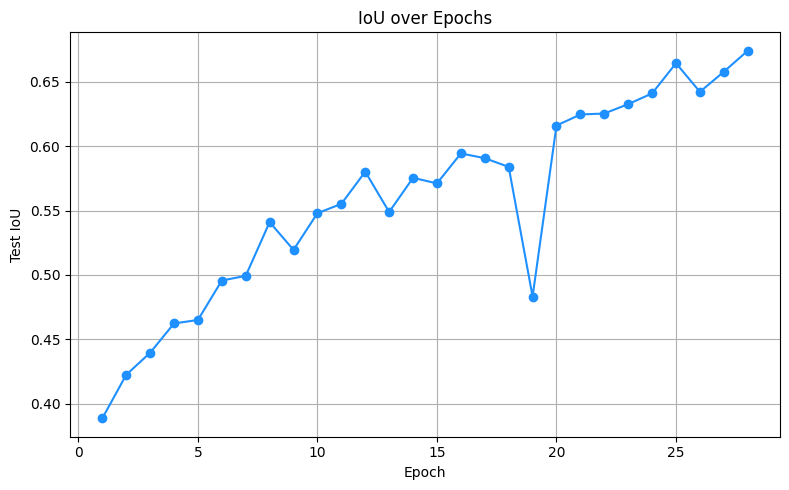

  >> Best model saved at epoch 28 with IoU: 0.6741
[10/183] Loss: 0.8955 Train Acc: 0.6758
[20/183] Loss: 1.0782 Train Acc: 0.6572
[30/183] Loss: 0.8070 Train Acc: 0.7031
[40/183] Loss: 0.6150 Train Acc: 0.7848
[50/183] Loss: 0.7720 Train Acc: 0.7245
[60/183] Loss: 0.8325 Train Acc: 0.7178
[70/183] Loss: 0.8369 Train Acc: 0.6988
[80/183] Loss: 0.7663 Train Acc: 0.7368
[90/183] Loss: 0.6982 Train Acc: 0.7529
[100/183] Loss: 0.7130 Train Acc: 0.7276
[110/183] Loss: 0.7188 Train Acc: 0.7153
[120/183] Loss: 0.7693 Train Acc: 0.7255
[130/183] Loss: 1.0038 Train Acc: 0.6617
[140/183] Loss: 0.9006 Train Acc: 0.6742
[150/183] Loss: 0.7659 Train Acc: 0.7259
[160/183] Loss: 0.9717 Train Acc: 0.6745
[170/183] Loss: 1.0287 Train Acc: 0.6646
[180/183] Loss: 0.8096 Train Acc: 0.7079
Epoch: 29, Test IoU: 0.6759


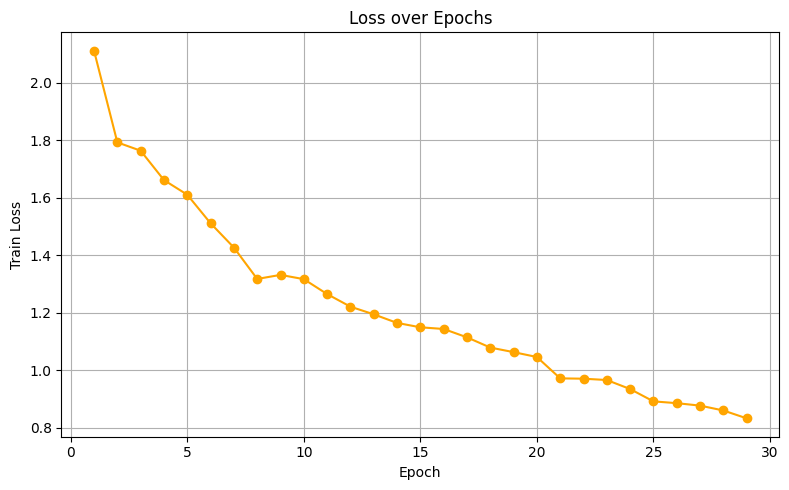

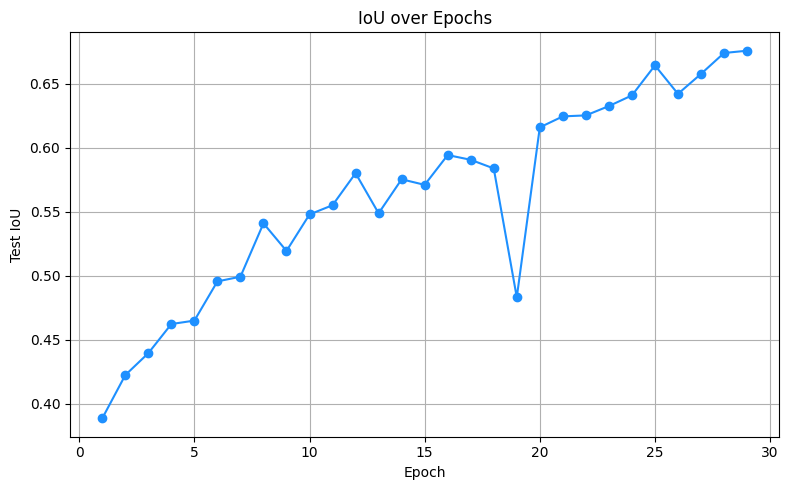

  >> Best model saved at epoch 29 with IoU: 0.6759
[10/183] Loss: 0.8067 Train Acc: 0.7237
[20/183] Loss: 0.8019 Train Acc: 0.7028
[30/183] Loss: 0.9174 Train Acc: 0.6687
[40/183] Loss: 0.7137 Train Acc: 0.7480
[50/183] Loss: 0.8886 Train Acc: 0.6852
[60/183] Loss: 0.8721 Train Acc: 0.6807
[70/183] Loss: 0.7415 Train Acc: 0.7378
[80/183] Loss: 0.7312 Train Acc: 0.7401
[90/183] Loss: 0.6294 Train Acc: 0.7587
[100/183] Loss: 0.9075 Train Acc: 0.6791
[110/183] Loss: 0.8741 Train Acc: 0.6986
[120/183] Loss: 0.6385 Train Acc: 0.7681
[130/183] Loss: 0.8811 Train Acc: 0.6769
[140/183] Loss: 0.7385 Train Acc: 0.7305
[150/183] Loss: 0.7306 Train Acc: 0.7360
[160/183] Loss: 0.8954 Train Acc: 0.6837
[170/183] Loss: 0.8351 Train Acc: 0.6911
[180/183] Loss: 0.7307 Train Acc: 0.7450
Epoch: 30, Test IoU: 0.6686


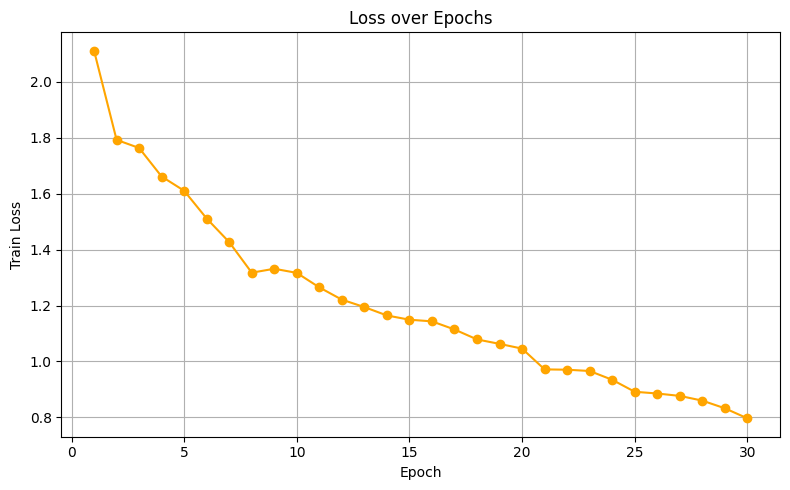

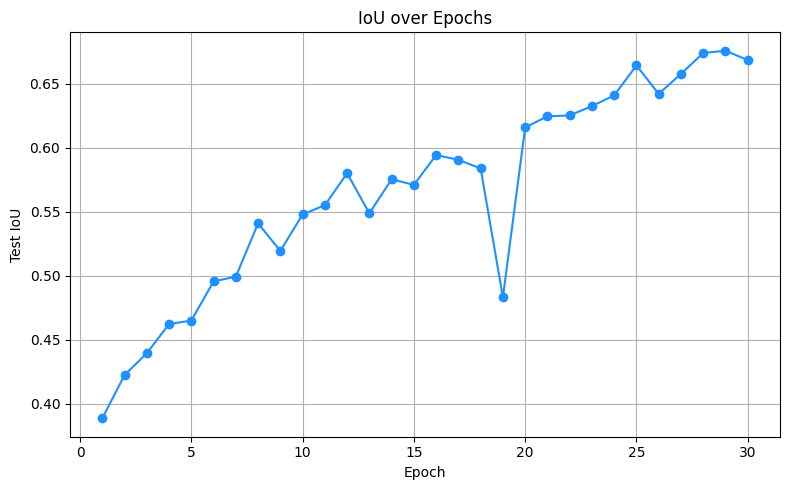

[10/183] Loss: 0.8133 Train Acc: 0.6978
[20/183] Loss: 0.7595 Train Acc: 0.7540
[30/183] Loss: 0.8631 Train Acc: 0.6980
[40/183] Loss: 0.8005 Train Acc: 0.7130
[50/183] Loss: 0.6871 Train Acc: 0.7462
[60/183] Loss: 0.8443 Train Acc: 0.7110
[70/183] Loss: 0.7946 Train Acc: 0.7071
[80/183] Loss: 0.7587 Train Acc: 0.7409
[90/183] Loss: 0.8038 Train Acc: 0.7165
[100/183] Loss: 0.8288 Train Acc: 0.7204
[110/183] Loss: 0.7032 Train Acc: 0.7499
[120/183] Loss: 1.0319 Train Acc: 0.6564
[130/183] Loss: 0.8969 Train Acc: 0.6719
[140/183] Loss: 0.6597 Train Acc: 0.7484
[150/183] Loss: 0.7550 Train Acc: 0.7063
[160/183] Loss: 0.9184 Train Acc: 0.6777
[170/183] Loss: 0.6915 Train Acc: 0.7685
[180/183] Loss: 0.7727 Train Acc: 0.7125
Epoch: 31, Test IoU: 0.6561


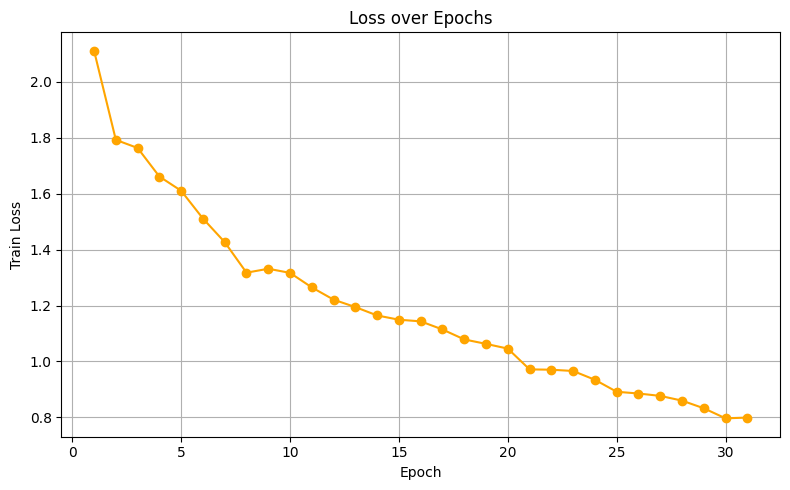

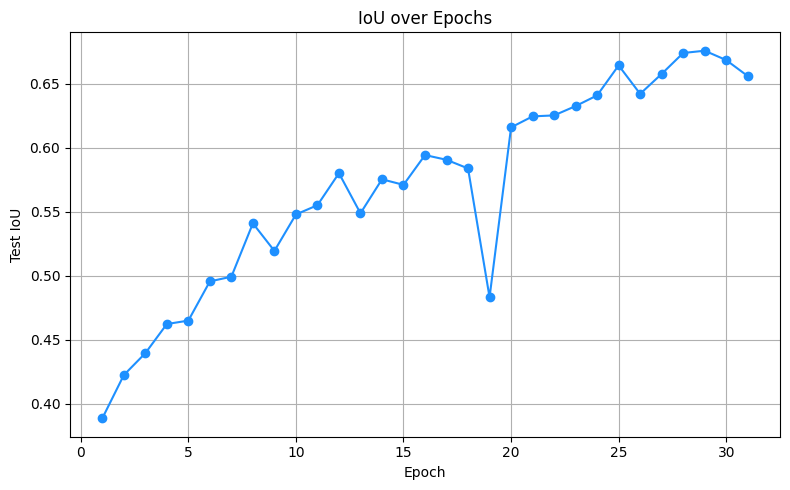

[10/183] Loss: 0.7957 Train Acc: 0.6979
[20/183] Loss: 0.6708 Train Acc: 0.7543
[30/183] Loss: 0.8161 Train Acc: 0.7049
[40/183] Loss: 0.8344 Train Acc: 0.7014
[50/183] Loss: 0.8271 Train Acc: 0.6952
[60/183] Loss: 0.5331 Train Acc: 0.8007
[70/183] Loss: 0.8305 Train Acc: 0.7204
[80/183] Loss: 0.5853 Train Acc: 0.7856
[90/183] Loss: 0.9693 Train Acc: 0.6462
[100/183] Loss: 0.8736 Train Acc: 0.6905
[110/183] Loss: 0.7717 Train Acc: 0.7198
[120/183] Loss: 1.0691 Train Acc: 0.6944
[130/183] Loss: 0.9559 Train Acc: 0.6840
[140/183] Loss: 0.9793 Train Acc: 0.6795
[150/183] Loss: 0.8963 Train Acc: 0.6790
[160/183] Loss: 0.8937 Train Acc: 0.7011
[170/183] Loss: 0.9661 Train Acc: 0.6674
[180/183] Loss: 0.7570 Train Acc: 0.7359
Epoch: 32, Test IoU: 0.6822


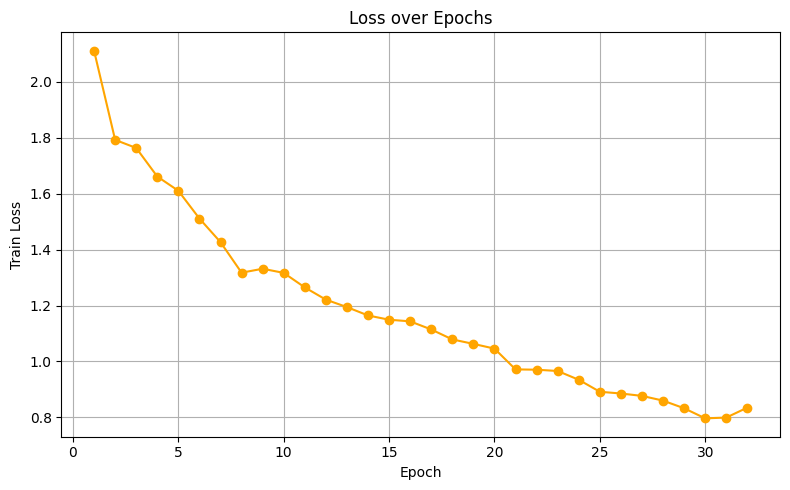

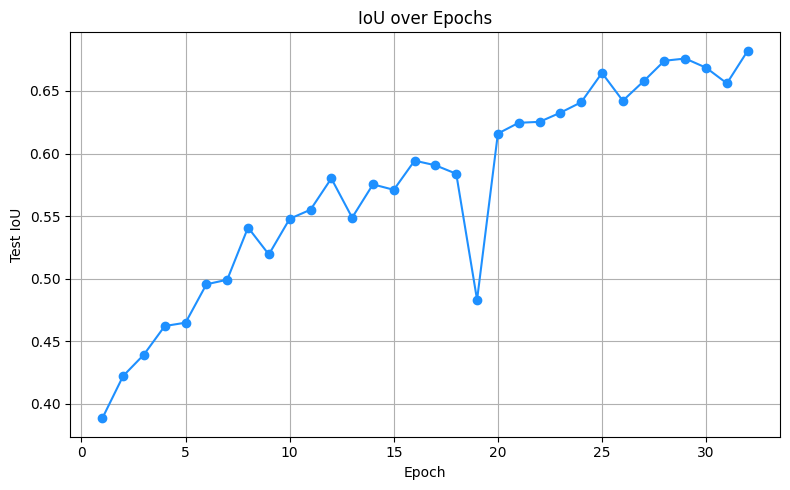

  >> Best model saved at epoch 32 with IoU: 0.6822
[10/183] Loss: 0.7912 Train Acc: 0.7164
[20/183] Loss: 0.8210 Train Acc: 0.7122
[30/183] Loss: 0.7921 Train Acc: 0.7060
[40/183] Loss: 0.8594 Train Acc: 0.7085
[50/183] Loss: 0.7087 Train Acc: 0.7550
[60/183] Loss: 0.8480 Train Acc: 0.6877
[70/183] Loss: 0.7634 Train Acc: 0.7337
[80/183] Loss: 0.7756 Train Acc: 0.7118
[90/183] Loss: 0.6453 Train Acc: 0.7661
[100/183] Loss: 0.6738 Train Acc: 0.7460
[110/183] Loss: 0.8022 Train Acc: 0.6929
[120/183] Loss: 0.6621 Train Acc: 0.7703
[130/183] Loss: 0.7785 Train Acc: 0.7058
[140/183] Loss: 0.7225 Train Acc: 0.7224
[150/183] Loss: 0.7099 Train Acc: 0.7446
[160/183] Loss: 0.9360 Train Acc: 0.7125
[170/183] Loss: 0.7681 Train Acc: 0.7182
[180/183] Loss: 0.7660 Train Acc: 0.7491
Epoch: 33, Test IoU: 0.6494


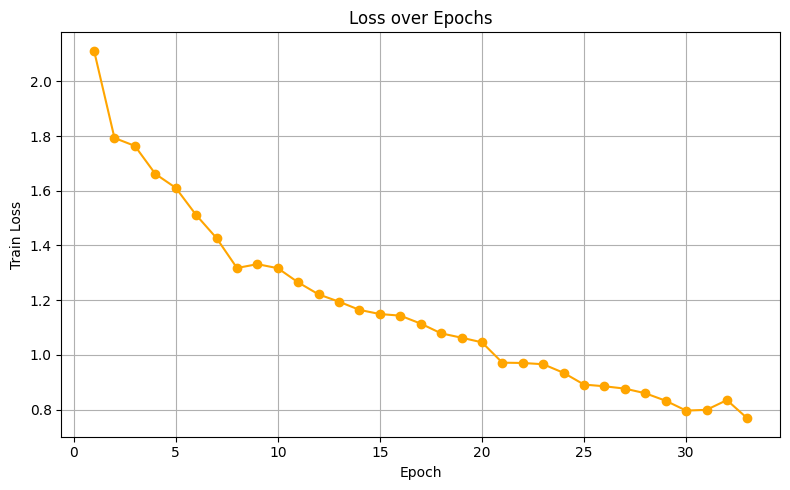

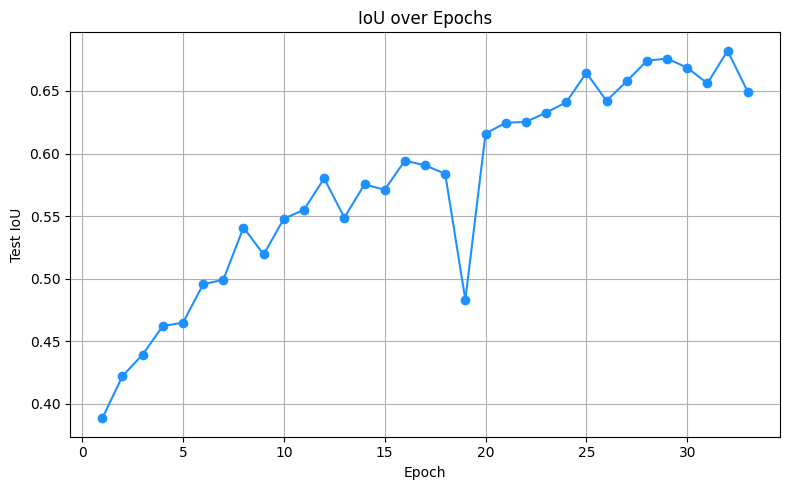

[10/183] Loss: 0.8273 Train Acc: 0.7183
[20/183] Loss: 0.8469 Train Acc: 0.7129
[30/183] Loss: 0.8301 Train Acc: 0.7110
[40/183] Loss: 0.7332 Train Acc: 0.7451
[50/183] Loss: 0.6183 Train Acc: 0.7800
[60/183] Loss: 0.9023 Train Acc: 0.6910
[70/183] Loss: 0.9602 Train Acc: 0.6697
[80/183] Loss: 0.7961 Train Acc: 0.7099
[90/183] Loss: 0.6948 Train Acc: 0.7469
[100/183] Loss: 0.8808 Train Acc: 0.6862
[110/183] Loss: 0.7267 Train Acc: 0.7527
[120/183] Loss: 0.8732 Train Acc: 0.7089
[130/183] Loss: 0.7544 Train Acc: 0.7349
[140/183] Loss: 0.6567 Train Acc: 0.7507
[150/183] Loss: 0.7456 Train Acc: 0.7279
[160/183] Loss: 0.7345 Train Acc: 0.7212
[170/183] Loss: 0.7811 Train Acc: 0.7223
[180/183] Loss: 0.6986 Train Acc: 0.7360
Epoch: 34, Test IoU: 0.7026


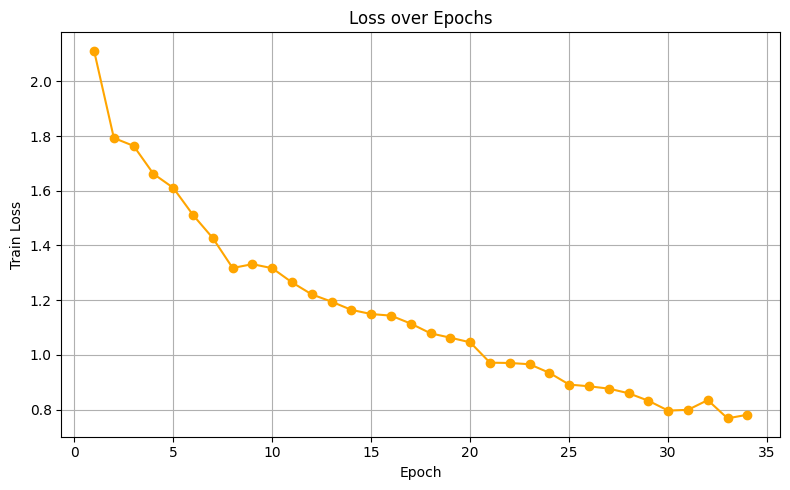

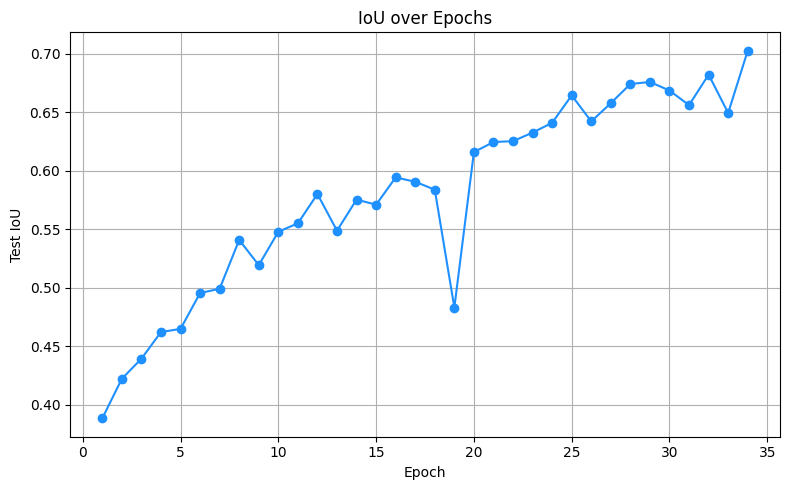

  >> Best model saved at epoch 34 with IoU: 0.7026
[10/183] Loss: 0.7884 Train Acc: 0.7311
[20/183] Loss: 0.7884 Train Acc: 0.7172
[30/183] Loss: 0.7136 Train Acc: 0.7389
[40/183] Loss: 0.6766 Train Acc: 0.7537
[50/183] Loss: 0.7261 Train Acc: 0.7385
[60/183] Loss: 0.9625 Train Acc: 0.6516
[70/183] Loss: 0.6505 Train Acc: 0.7737
[80/183] Loss: 0.7236 Train Acc: 0.7514
[90/183] Loss: 0.7609 Train Acc: 0.7167
[100/183] Loss: 0.7182 Train Acc: 0.7287
[110/183] Loss: 0.5864 Train Acc: 0.7819
[120/183] Loss: 0.6741 Train Acc: 0.7593
[130/183] Loss: 0.8274 Train Acc: 0.7111
[140/183] Loss: 0.7742 Train Acc: 0.7127
[150/183] Loss: 0.7712 Train Acc: 0.7273
[160/183] Loss: 0.6560 Train Acc: 0.7522
[170/183] Loss: 0.7053 Train Acc: 0.7458
[180/183] Loss: 0.7402 Train Acc: 0.7471
Epoch: 35, Test IoU: 0.7019


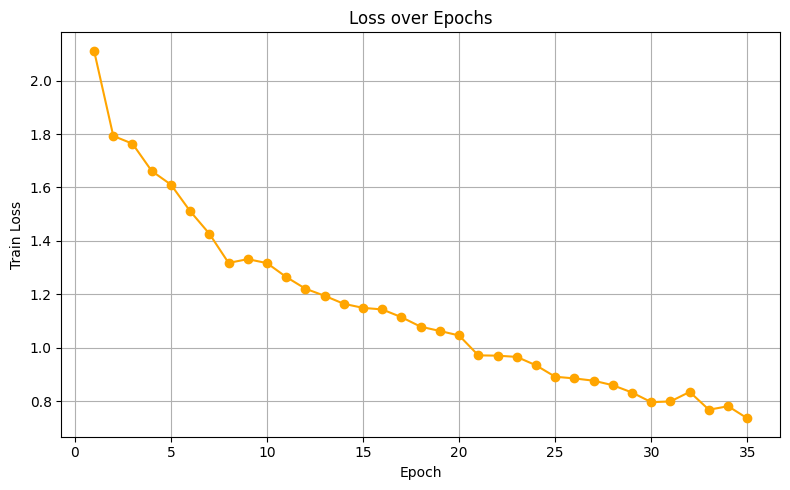

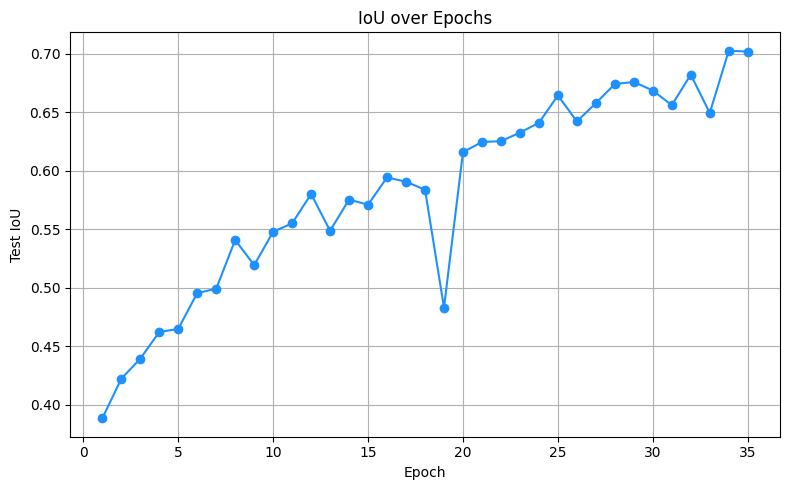

[10/183] Loss: 0.7716 Train Acc: 0.7328
[20/183] Loss: 0.6484 Train Acc: 0.7757
[30/183] Loss: 0.7467 Train Acc: 0.7557
[40/183] Loss: 0.7388 Train Acc: 0.7296
[50/183] Loss: 0.7075 Train Acc: 0.7393
[60/183] Loss: 0.7087 Train Acc: 0.7390
[70/183] Loss: 0.7524 Train Acc: 0.7318
[80/183] Loss: 0.7596 Train Acc: 0.7030
[90/183] Loss: 0.6703 Train Acc: 0.7571
[100/183] Loss: 0.6506 Train Acc: 0.7610
[110/183] Loss: 0.7952 Train Acc: 0.6883
[120/183] Loss: 0.7691 Train Acc: 0.7172
[130/183] Loss: 0.7701 Train Acc: 0.7290
[140/183] Loss: 0.7065 Train Acc: 0.7323
[150/183] Loss: 0.8295 Train Acc: 0.7071
[160/183] Loss: 0.7969 Train Acc: 0.7156
[170/183] Loss: 0.7757 Train Acc: 0.7558
[180/183] Loss: 0.7417 Train Acc: 0.7473
Epoch: 36, Test IoU: 0.6769


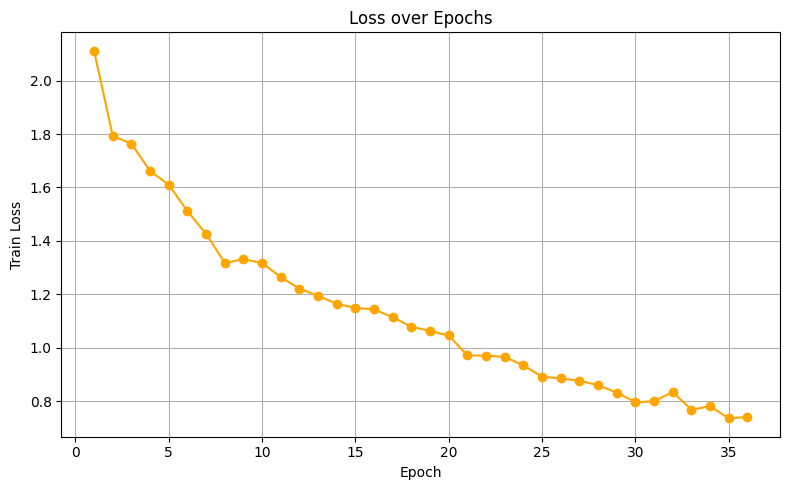

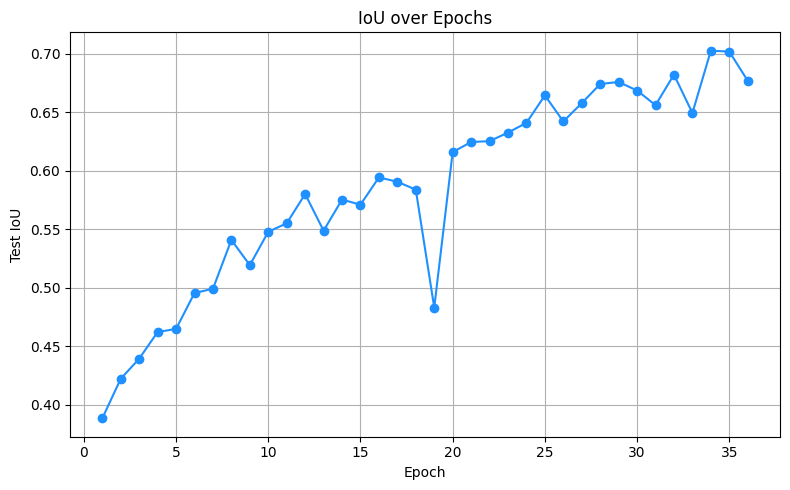

[10/183] Loss: 0.8764 Train Acc: 0.6989
[20/183] Loss: 0.8566 Train Acc: 0.6980
[30/183] Loss: 0.8063 Train Acc: 0.7095
[40/183] Loss: 0.6722 Train Acc: 0.7538
[50/183] Loss: 0.7787 Train Acc: 0.7227
[60/183] Loss: 0.6747 Train Acc: 0.7672
[70/183] Loss: 0.7832 Train Acc: 0.7267
[80/183] Loss: 0.8176 Train Acc: 0.7138
[90/183] Loss: 0.7730 Train Acc: 0.7311
[100/183] Loss: 0.8089 Train Acc: 0.7191
[110/183] Loss: 0.7662 Train Acc: 0.7156
[120/183] Loss: 0.7971 Train Acc: 0.7240
[130/183] Loss: 0.7428 Train Acc: 0.7620
[140/183] Loss: 0.7767 Train Acc: 0.7223
[150/183] Loss: 0.7699 Train Acc: 0.7145
[160/183] Loss: 0.6607 Train Acc: 0.7537
[170/183] Loss: 0.5879 Train Acc: 0.7761
[180/183] Loss: 0.7271 Train Acc: 0.7127
Epoch: 37, Test IoU: 0.7133


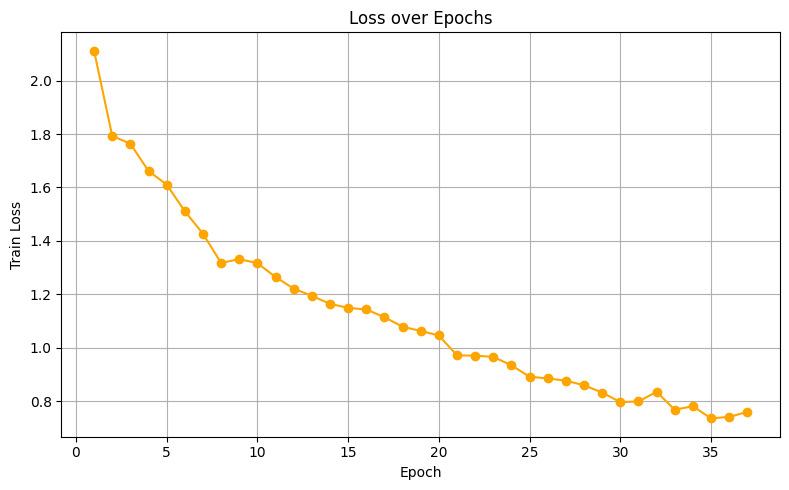

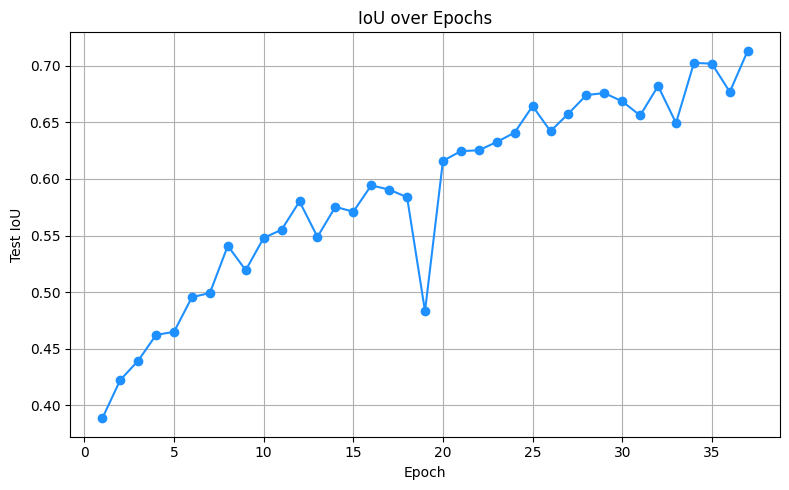

  >> Best model saved at epoch 37 with IoU: 0.7133
[10/183] Loss: 0.7920 Train Acc: 0.7205
[20/183] Loss: 0.6889 Train Acc: 0.7662
[30/183] Loss: 0.8164 Train Acc: 0.7154
[40/183] Loss: 0.6929 Train Acc: 0.7507
[50/183] Loss: 0.6742 Train Acc: 0.7484
[60/183] Loss: 0.7227 Train Acc: 0.7242
[70/183] Loss: 0.6862 Train Acc: 0.7470
[80/183] Loss: 0.6323 Train Acc: 0.7625
[90/183] Loss: 0.7715 Train Acc: 0.7126
[100/183] Loss: 0.6064 Train Acc: 0.7710
[110/183] Loss: 0.6954 Train Acc: 0.7359
[120/183] Loss: 0.6511 Train Acc: 0.7701
[130/183] Loss: 0.8001 Train Acc: 0.6957
[140/183] Loss: 0.8040 Train Acc: 0.7164
[150/183] Loss: 0.6760 Train Acc: 0.7381
[160/183] Loss: 0.6882 Train Acc: 0.7513
[170/183] Loss: 0.5633 Train Acc: 0.7965
[180/183] Loss: 0.7833 Train Acc: 0.7511
Epoch: 38, Test IoU: 0.6762


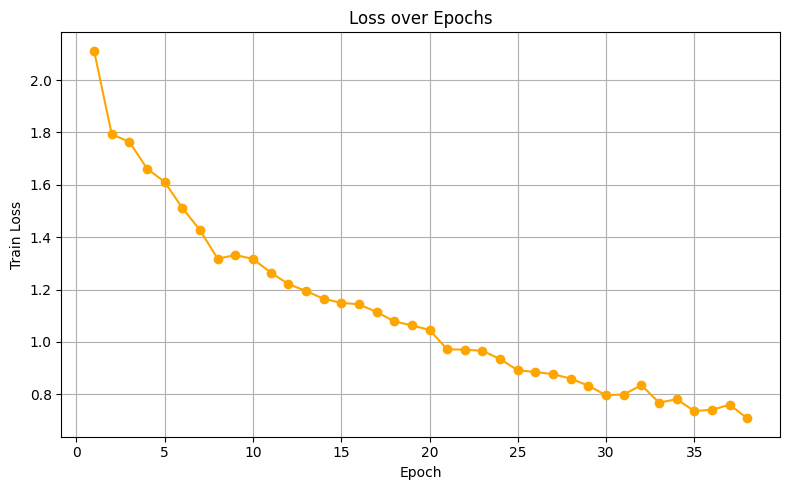

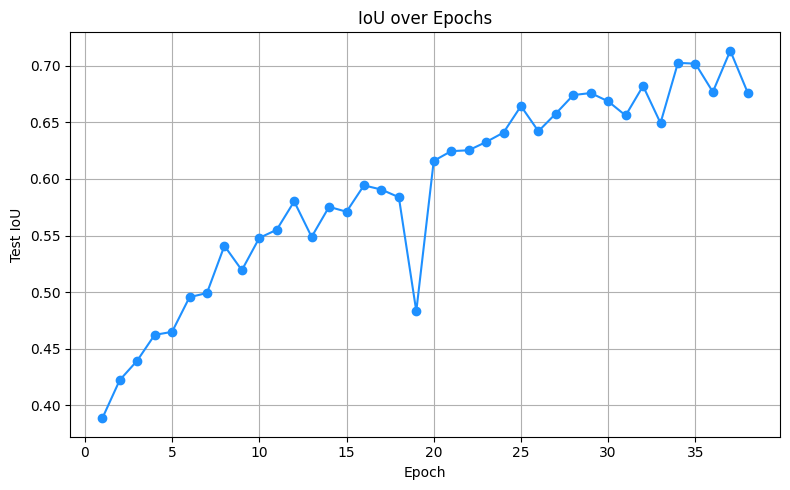

[10/183] Loss: 0.9093 Train Acc: 0.6900
[20/183] Loss: 0.7469 Train Acc: 0.7220
[30/183] Loss: 0.9074 Train Acc: 0.6994
[40/183] Loss: 0.8371 Train Acc: 0.7113
[50/183] Loss: 0.8886 Train Acc: 0.6937
[60/183] Loss: 0.7455 Train Acc: 0.7348
[70/183] Loss: 0.8390 Train Acc: 0.7388
[80/183] Loss: 0.9790 Train Acc: 0.6751
[90/183] Loss: 0.6982 Train Acc: 0.7470
[100/183] Loss: 1.1156 Train Acc: 0.6174
[110/183] Loss: 0.6778 Train Acc: 0.7624
[120/183] Loss: 0.6281 Train Acc: 0.7728
[130/183] Loss: 0.6782 Train Acc: 0.7517
[140/183] Loss: 0.7364 Train Acc: 0.7186
[150/183] Loss: 0.7745 Train Acc: 0.7284
[160/183] Loss: 0.6637 Train Acc: 0.7659
[170/183] Loss: 0.6156 Train Acc: 0.7786
[180/183] Loss: 0.6890 Train Acc: 0.7370
Epoch: 39, Test IoU: 0.7076


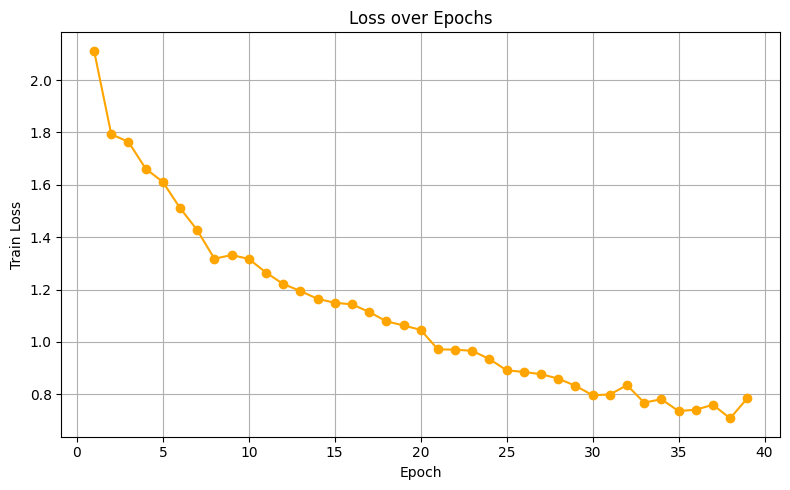

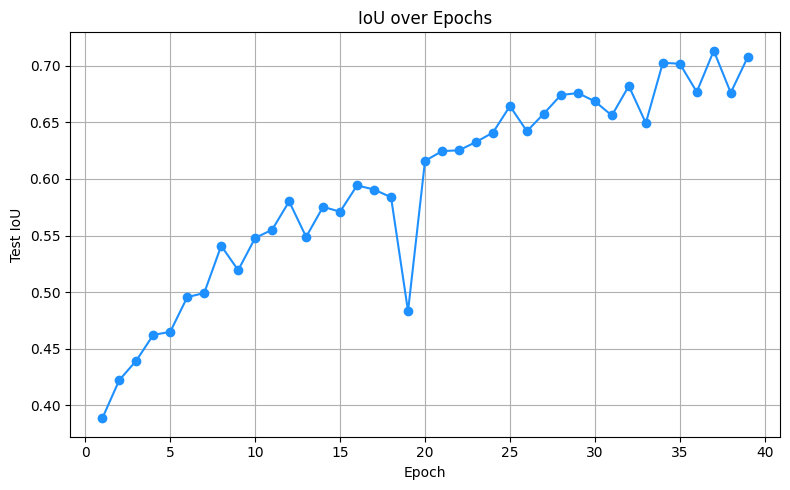

[10/183] Loss: 0.7286 Train Acc: 0.7288
[20/183] Loss: 0.6138 Train Acc: 0.7798
[30/183] Loss: 0.7571 Train Acc: 0.7275
[40/183] Loss: 0.8489 Train Acc: 0.7093
[50/183] Loss: 0.9197 Train Acc: 0.6988
[60/183] Loss: 0.7406 Train Acc: 0.7360
[70/183] Loss: 0.5881 Train Acc: 0.7969
[80/183] Loss: 0.7155 Train Acc: 0.7241
[90/183] Loss: 0.6556 Train Acc: 0.7537
[100/183] Loss: 0.6576 Train Acc: 0.7637
[110/183] Loss: 0.5889 Train Acc: 0.7753
[120/183] Loss: 0.6578 Train Acc: 0.7486
[130/183] Loss: 0.8720 Train Acc: 0.7206
[140/183] Loss: 0.6634 Train Acc: 0.7479
[150/183] Loss: 0.7275 Train Acc: 0.7405
[160/183] Loss: 0.8703 Train Acc: 0.6740
[170/183] Loss: 0.8105 Train Acc: 0.7100
[180/183] Loss: 0.7260 Train Acc: 0.7557
Epoch: 40, Test IoU: 0.7214


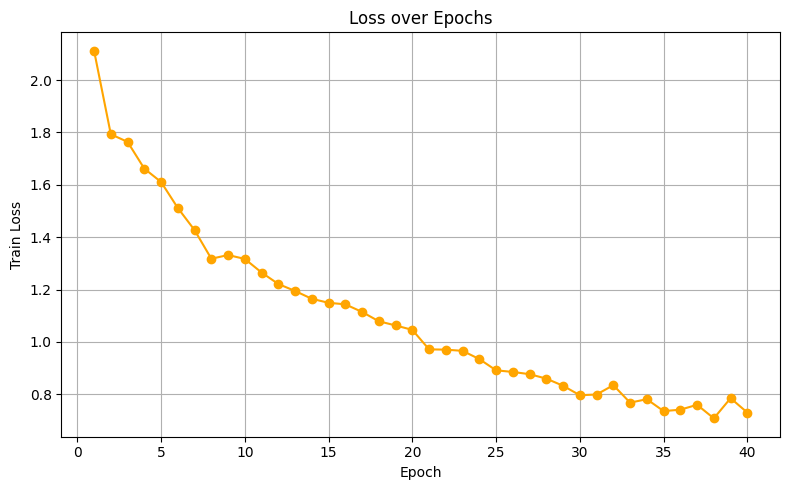

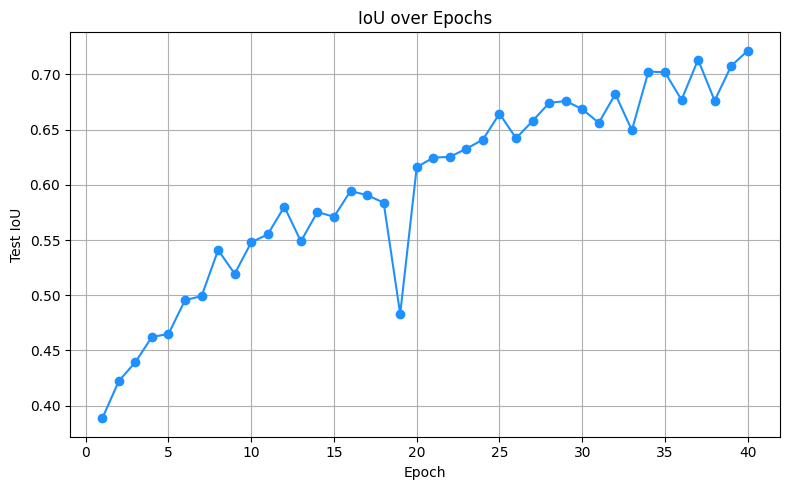

  >> Best model saved at epoch 40 with IoU: 0.7214
[10/183] Loss: 0.7951 Train Acc: 0.7241
[20/183] Loss: 0.8052 Train Acc: 0.7213
[30/183] Loss: 0.6830 Train Acc: 0.7525
[40/183] Loss: 0.5695 Train Acc: 0.7963
[50/183] Loss: 0.6416 Train Acc: 0.7628
[60/183] Loss: 0.6312 Train Acc: 0.7687
[70/183] Loss: 0.5563 Train Acc: 0.7919
[80/183] Loss: 0.5780 Train Acc: 0.7829
[90/183] Loss: 0.5768 Train Acc: 0.7854
[100/183] Loss: 0.7184 Train Acc: 0.7379
[110/183] Loss: 0.7854 Train Acc: 0.7106
[120/183] Loss: 0.7420 Train Acc: 0.7277
[130/183] Loss: 0.6418 Train Acc: 0.7604
[140/183] Loss: 0.5255 Train Acc: 0.8003
[150/183] Loss: 0.6879 Train Acc: 0.7459
[160/183] Loss: 0.7166 Train Acc: 0.7297
[170/183] Loss: 0.6098 Train Acc: 0.7771
[180/183] Loss: 0.5833 Train Acc: 0.7666
Epoch: 41, Test IoU: 0.7394


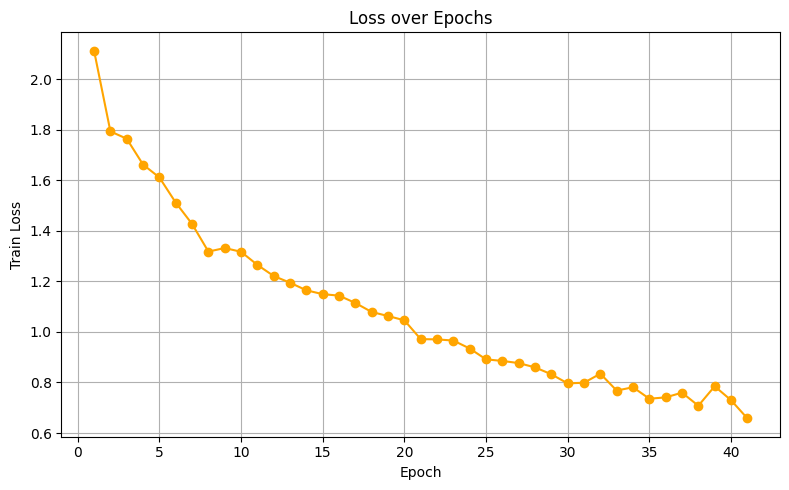

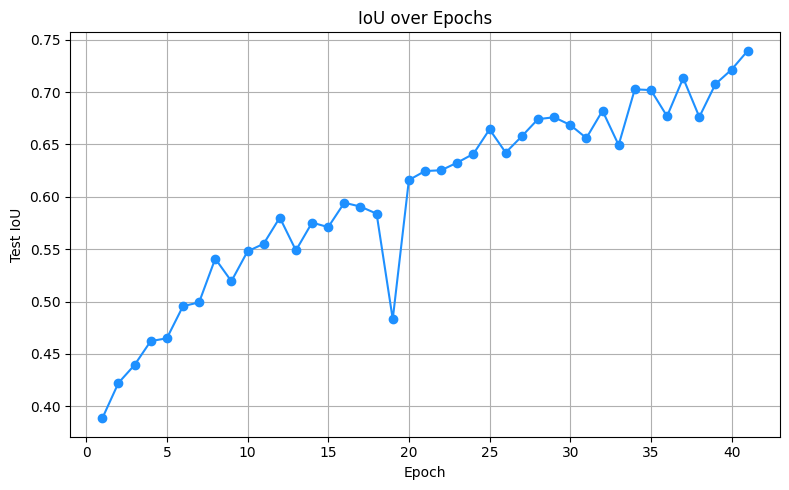

  >> Best model saved at epoch 41 with IoU: 0.7394
[10/183] Loss: 0.7934 Train Acc: 0.7416
[20/183] Loss: 0.5490 Train Acc: 0.7998
[30/183] Loss: 0.6506 Train Acc: 0.7612
[40/183] Loss: 0.5719 Train Acc: 0.7857
[50/183] Loss: 0.6929 Train Acc: 0.7778
[60/183] Loss: 0.7406 Train Acc: 0.7327
[70/183] Loss: 0.7102 Train Acc: 0.7413
[80/183] Loss: 0.6502 Train Acc: 0.7624
[90/183] Loss: 0.6974 Train Acc: 0.7538
[100/183] Loss: 0.6996 Train Acc: 0.7528
[110/183] Loss: 0.6243 Train Acc: 0.7583
[120/183] Loss: 0.6671 Train Acc: 0.7647
[130/183] Loss: 0.6405 Train Acc: 0.7547
[140/183] Loss: 0.8730 Train Acc: 0.6855
[150/183] Loss: 0.6894 Train Acc: 0.7262
[160/183] Loss: 0.5889 Train Acc: 0.7708
[170/183] Loss: 0.6765 Train Acc: 0.7478
[180/183] Loss: 0.5659 Train Acc: 0.7902
Epoch: 42, Test IoU: 0.7360


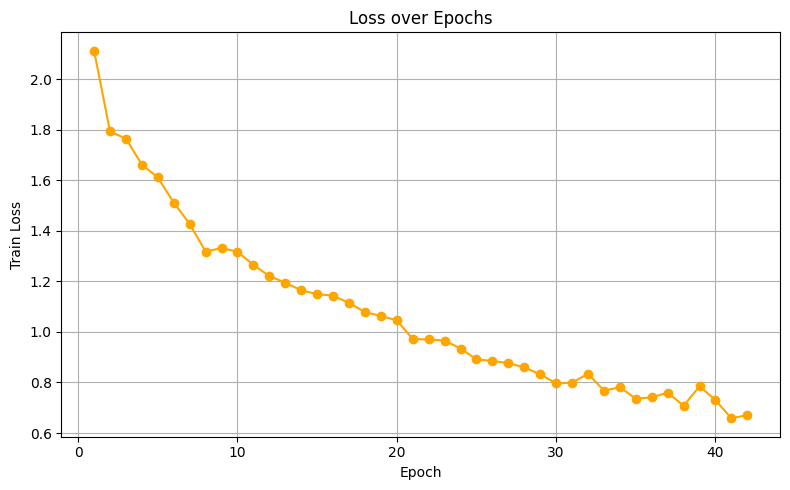

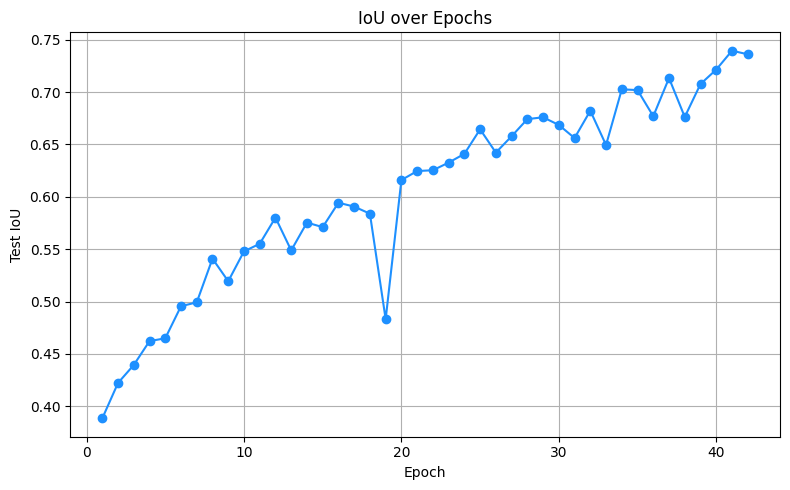

[10/183] Loss: 0.5494 Train Acc: 0.7991
[20/183] Loss: 0.6934 Train Acc: 0.7532
[30/183] Loss: 0.5433 Train Acc: 0.8004
[40/183] Loss: 0.6076 Train Acc: 0.7727
[50/183] Loss: 0.5468 Train Acc: 0.7993
[60/183] Loss: 0.5486 Train Acc: 0.7814
[70/183] Loss: 0.7266 Train Acc: 0.7376
[80/183] Loss: 0.5866 Train Acc: 0.7685
[90/183] Loss: 0.6016 Train Acc: 0.7956
[100/183] Loss: 0.5968 Train Acc: 0.7763
[110/183] Loss: 0.7452 Train Acc: 0.7310
[120/183] Loss: 0.5470 Train Acc: 0.7921
[130/183] Loss: 0.7384 Train Acc: 0.7423
[140/183] Loss: 0.6914 Train Acc: 0.7505
[150/183] Loss: 0.6328 Train Acc: 0.7710
[160/183] Loss: 0.6467 Train Acc: 0.7629
[170/183] Loss: 0.8667 Train Acc: 0.7362
[180/183] Loss: 0.6337 Train Acc: 0.7598
Epoch: 43, Test IoU: 0.7214


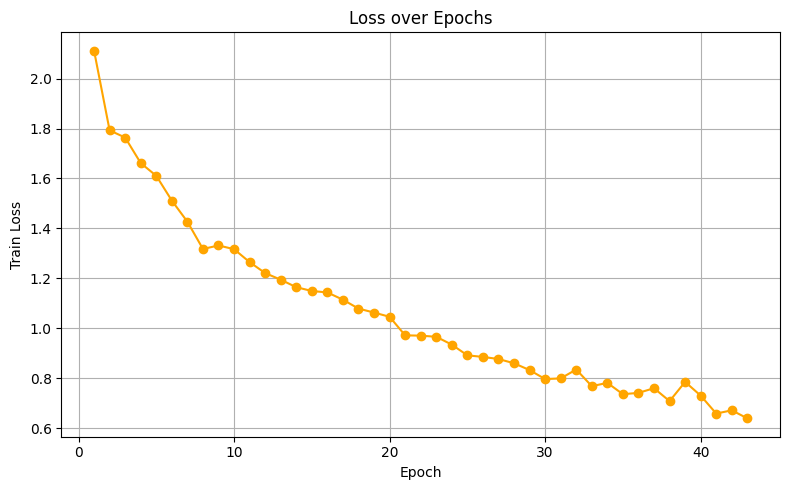

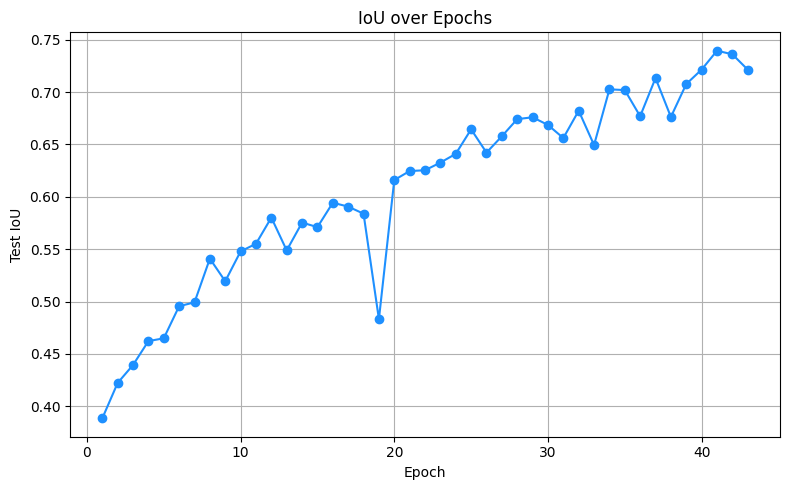

[10/183] Loss: 0.5851 Train Acc: 0.7825
[20/183] Loss: 0.5988 Train Acc: 0.7601
[30/183] Loss: 0.5945 Train Acc: 0.7848
[40/183] Loss: 0.6102 Train Acc: 0.7703
[50/183] Loss: 0.5846 Train Acc: 0.7796
[60/183] Loss: 0.6270 Train Acc: 0.7686
[70/183] Loss: 0.7019 Train Acc: 0.7256
[80/183] Loss: 0.6169 Train Acc: 0.7696
[90/183] Loss: 0.5567 Train Acc: 0.7837
[100/183] Loss: 0.7578 Train Acc: 0.7371
[110/183] Loss: 0.6324 Train Acc: 0.7511
[120/183] Loss: 0.5784 Train Acc: 0.7970
[130/183] Loss: 0.6900 Train Acc: 0.7470
[140/183] Loss: 0.7350 Train Acc: 0.7271
[150/183] Loss: 0.5806 Train Acc: 0.7878
[160/183] Loss: 0.6242 Train Acc: 0.7693
[170/183] Loss: 0.6995 Train Acc: 0.7522
[180/183] Loss: 0.6435 Train Acc: 0.7577
Epoch: 44, Test IoU: 0.7201


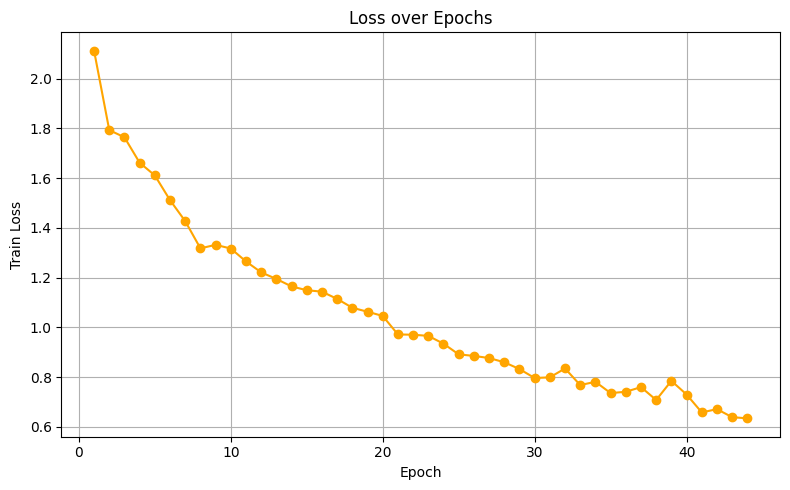

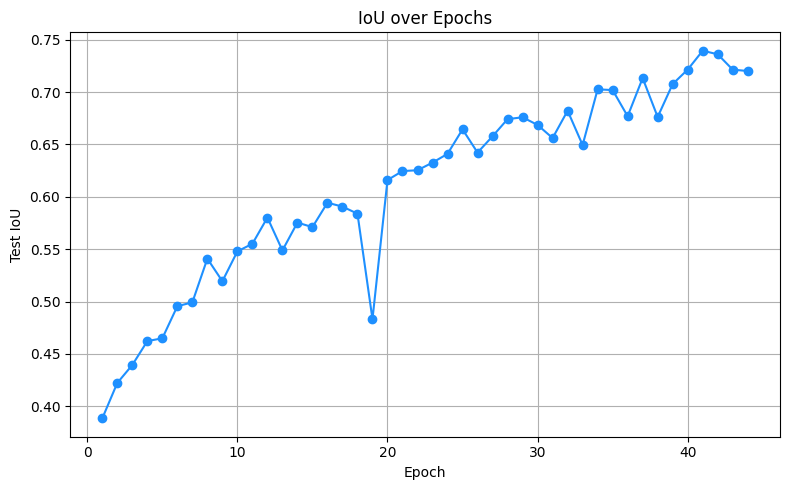

[10/183] Loss: 0.7855 Train Acc: 0.7382
[20/183] Loss: 0.6437 Train Acc: 0.7725
[30/183] Loss: 0.5744 Train Acc: 0.7909
[40/183] Loss: 0.6988 Train Acc: 0.7185
[50/183] Loss: 0.5267 Train Acc: 0.7973
[60/183] Loss: 0.8180 Train Acc: 0.7173
[70/183] Loss: 0.7044 Train Acc: 0.7584
[80/183] Loss: 0.7145 Train Acc: 0.7430
[90/183] Loss: 0.5525 Train Acc: 0.8141
[100/183] Loss: 0.6922 Train Acc: 0.7648
[110/183] Loss: 0.6504 Train Acc: 0.7580
[120/183] Loss: 0.6338 Train Acc: 0.7661
[130/183] Loss: 0.5693 Train Acc: 0.8091
[140/183] Loss: 0.6011 Train Acc: 0.7639
[150/183] Loss: 0.6838 Train Acc: 0.7484
[160/183] Loss: 0.6929 Train Acc: 0.7314
[170/183] Loss: 0.7553 Train Acc: 0.7130
[180/183] Loss: 0.5692 Train Acc: 0.7898
Epoch: 45, Test IoU: 0.7075


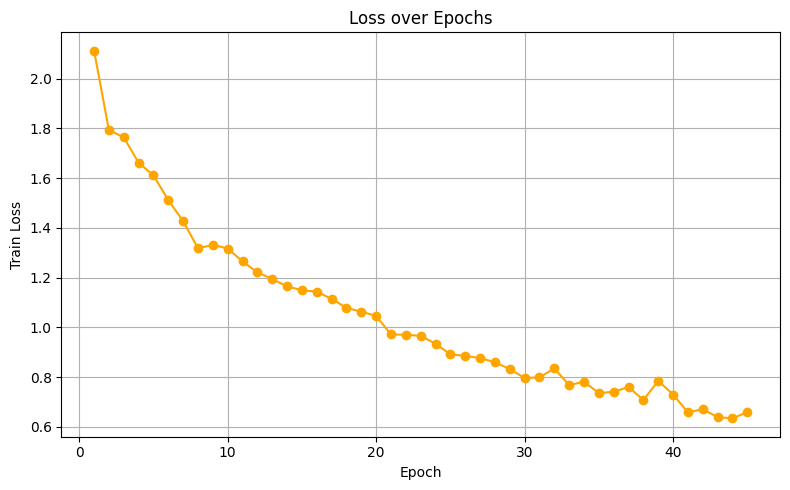

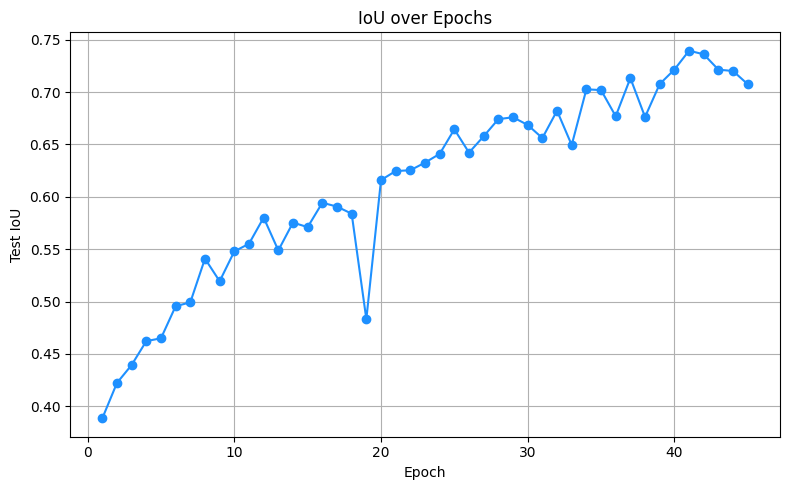

[10/183] Loss: 1.3555 Train Acc: 0.6167
[20/183] Loss: 1.1903 Train Acc: 0.6201
[30/183] Loss: 1.1025 Train Acc: 0.6188
[40/183] Loss: 1.0166 Train Acc: 0.6811
[50/183] Loss: 0.8400 Train Acc: 0.7006
[60/183] Loss: 0.8755 Train Acc: 0.6920
[70/183] Loss: 0.8310 Train Acc: 0.7192
[80/183] Loss: 0.8512 Train Acc: 0.7000
[90/183] Loss: 0.8606 Train Acc: 0.7040
[100/183] Loss: 0.7689 Train Acc: 0.7138
[110/183] Loss: 0.7608 Train Acc: 0.7304
[120/183] Loss: 0.6715 Train Acc: 0.7476
[130/183] Loss: 0.7329 Train Acc: 0.7439
[140/183] Loss: 0.6253 Train Acc: 0.7758
[150/183] Loss: 0.7782 Train Acc: 0.7373
[160/183] Loss: 0.5713 Train Acc: 0.7915
[170/183] Loss: 0.6107 Train Acc: 0.7867
[180/183] Loss: 0.6626 Train Acc: 0.7659
Epoch: 46, Test IoU: 0.7464


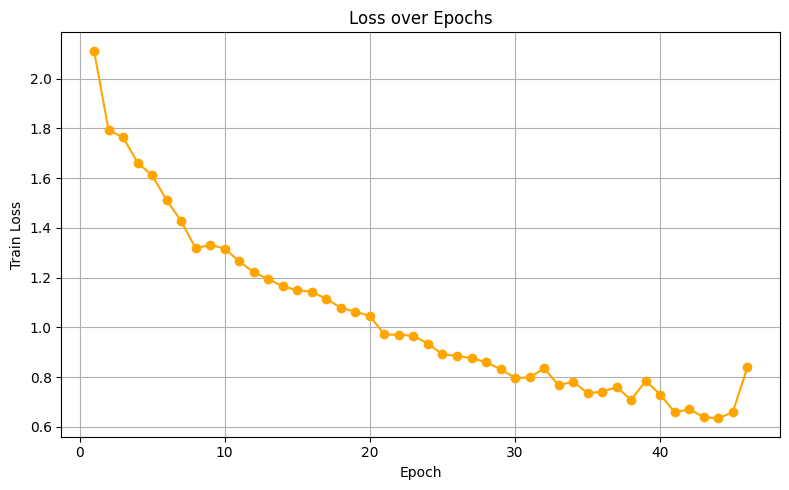

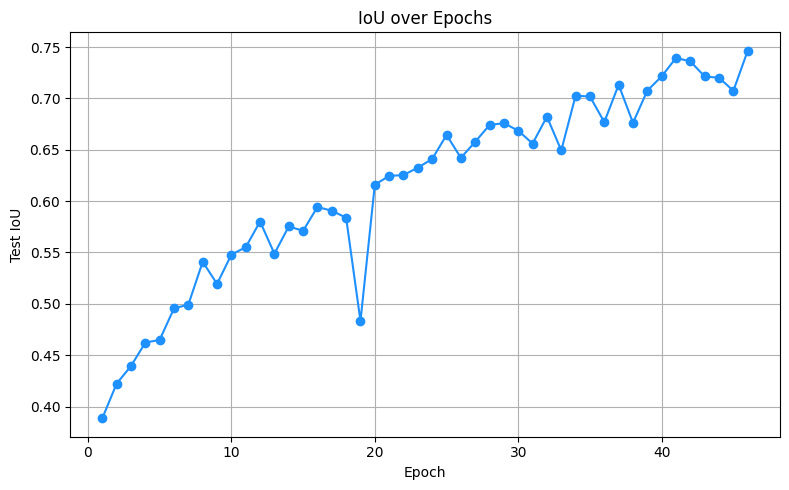

  >> Best model saved at epoch 46 with IoU: 0.7464
[10/183] Loss: 0.6794 Train Acc: 0.7273
[20/183] Loss: 0.5721 Train Acc: 0.7778
[30/183] Loss: 0.5444 Train Acc: 0.7877
[40/183] Loss: 0.8631 Train Acc: 0.6952
[50/183] Loss: 0.7680 Train Acc: 0.7194
[60/183] Loss: 0.6165 Train Acc: 0.7758
[70/183] Loss: 0.7226 Train Acc: 0.7578
[80/183] Loss: 0.8104 Train Acc: 0.7232
[90/183] Loss: 0.7321 Train Acc: 0.7343
[100/183] Loss: 0.7432 Train Acc: 0.7128
[110/183] Loss: 0.6823 Train Acc: 0.7520
[120/183] Loss: 0.6226 Train Acc: 0.7803
[130/183] Loss: 0.5806 Train Acc: 0.7907
[140/183] Loss: 0.5984 Train Acc: 0.7762
[150/183] Loss: 0.6343 Train Acc: 0.7856
[160/183] Loss: 0.6457 Train Acc: 0.7695
[170/183] Loss: 0.5118 Train Acc: 0.8193
[180/183] Loss: 0.6038 Train Acc: 0.7664
Epoch: 47, Test IoU: 0.7536


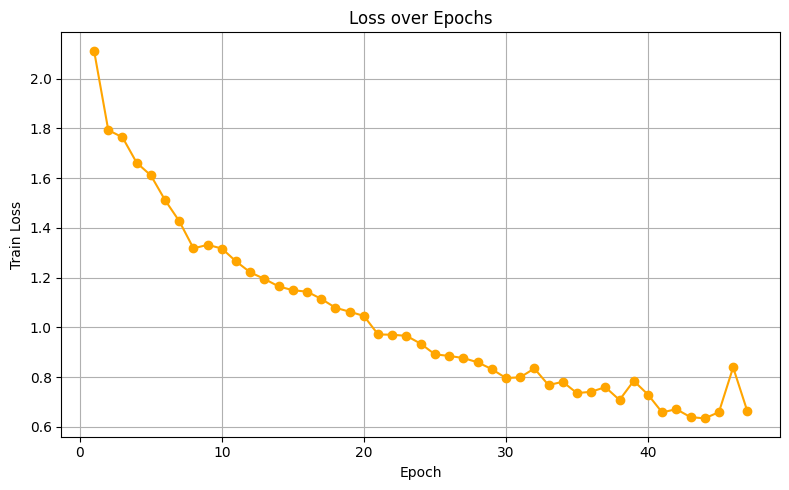

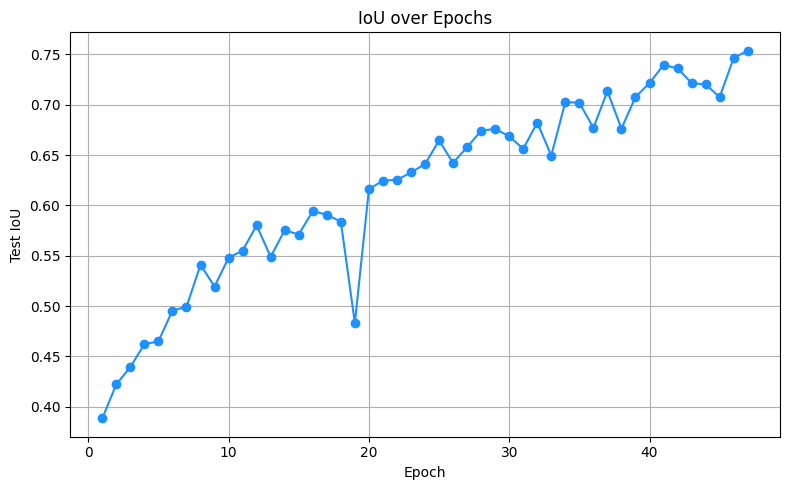

  >> Best model saved at epoch 47 with IoU: 0.7536
[10/183] Loss: 0.6023 Train Acc: 0.7915
[20/183] Loss: 0.6416 Train Acc: 0.7735
[30/183] Loss: 0.5901 Train Acc: 0.7987
[40/183] Loss: 0.5676 Train Acc: 0.8081
[50/183] Loss: 0.5613 Train Acc: 0.8001
[60/183] Loss: 0.6126 Train Acc: 0.7740
[70/183] Loss: 0.6013 Train Acc: 0.7689
[80/183] Loss: 0.6102 Train Acc: 0.7744
[90/183] Loss: 0.6360 Train Acc: 0.7644
[100/183] Loss: 0.5895 Train Acc: 0.7794
[110/183] Loss: 0.5851 Train Acc: 0.7709
[120/183] Loss: 0.5766 Train Acc: 0.7838
[130/183] Loss: 0.7653 Train Acc: 0.7053
[140/183] Loss: 0.5632 Train Acc: 0.7804
[150/183] Loss: 0.5486 Train Acc: 0.7940
[160/183] Loss: 0.6983 Train Acc: 0.7353
[170/183] Loss: 0.6763 Train Acc: 0.7343
[180/183] Loss: 0.7955 Train Acc: 0.7233
Epoch: 48, Test IoU: 0.7581


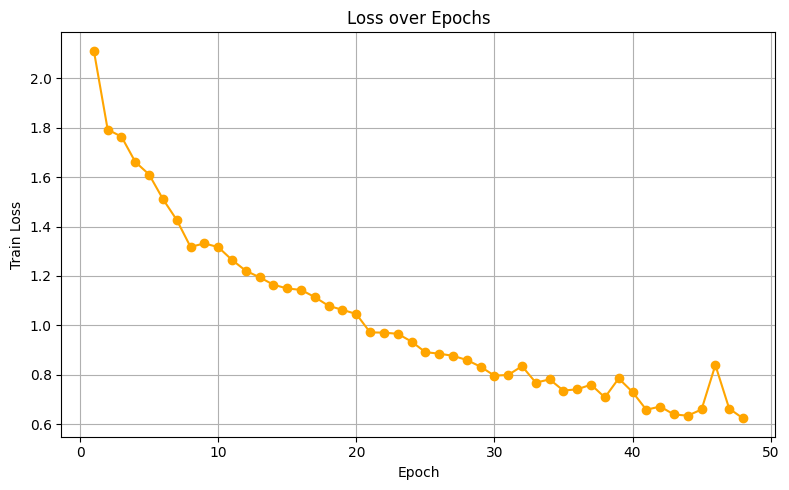

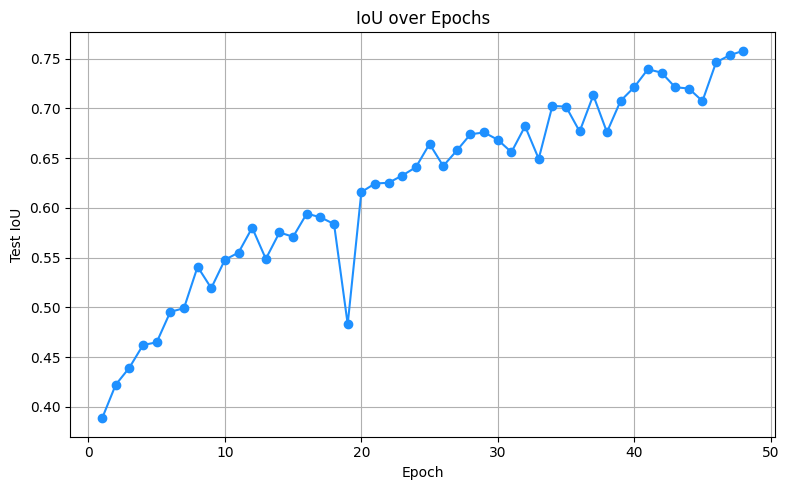

  >> Best model saved at epoch 48 with IoU: 0.7581
[10/183] Loss: 0.6360 Train Acc: 0.7819
[20/183] Loss: 0.6703 Train Acc: 0.7612
[30/183] Loss: 0.7246 Train Acc: 0.7310
[40/183] Loss: 0.6141 Train Acc: 0.7834
[50/183] Loss: 0.5167 Train Acc: 0.8019
[60/183] Loss: 0.6451 Train Acc: 0.7572
[70/183] Loss: 0.6423 Train Acc: 0.7717
[80/183] Loss: 0.5498 Train Acc: 0.7987
[90/183] Loss: 0.6388 Train Acc: 0.7620
[100/183] Loss: 0.5226 Train Acc: 0.7797
[110/183] Loss: 0.5698 Train Acc: 0.7913
[120/183] Loss: 0.6777 Train Acc: 0.7494
[130/183] Loss: 0.6208 Train Acc: 0.7717
[140/183] Loss: 0.5998 Train Acc: 0.7765
[150/183] Loss: 0.6256 Train Acc: 0.7770
[160/183] Loss: 0.6441 Train Acc: 0.7785
[170/183] Loss: 0.6703 Train Acc: 0.7637
[180/183] Loss: 0.5713 Train Acc: 0.7832
Epoch: 49, Test IoU: 0.7610


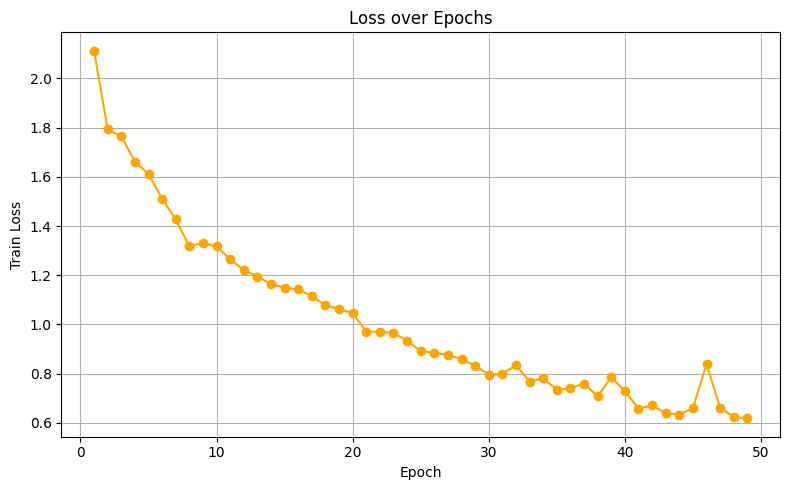

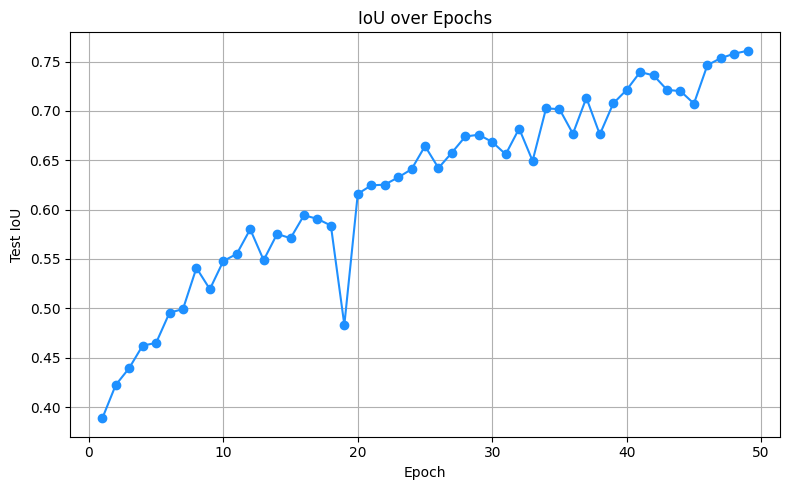

  >> Best model saved at epoch 49 with IoU: 0.7610
[10/183] Loss: 0.5229 Train Acc: 0.8155
[20/183] Loss: 0.6678 Train Acc: 0.7610
[30/183] Loss: 0.6579 Train Acc: 0.7539
[40/183] Loss: 0.5681 Train Acc: 0.7792
[50/183] Loss: 0.5532 Train Acc: 0.8032
[60/183] Loss: 0.4543 Train Acc: 0.8322
[70/183] Loss: 0.6608 Train Acc: 0.7618
[80/183] Loss: 0.5774 Train Acc: 0.7825
[90/183] Loss: 0.5018 Train Acc: 0.8203
[100/183] Loss: 0.6638 Train Acc: 0.7546
[110/183] Loss: 0.5610 Train Acc: 0.7807
[120/183] Loss: 0.5416 Train Acc: 0.8037
[130/183] Loss: 0.5979 Train Acc: 0.7704
[140/183] Loss: 0.6734 Train Acc: 0.7463
[150/183] Loss: 0.6218 Train Acc: 0.7790
[160/183] Loss: 0.8112 Train Acc: 0.7237
[170/183] Loss: 0.5700 Train Acc: 0.7901
[180/183] Loss: 0.6455 Train Acc: 0.7594
Epoch: 50, Test IoU: 0.7623


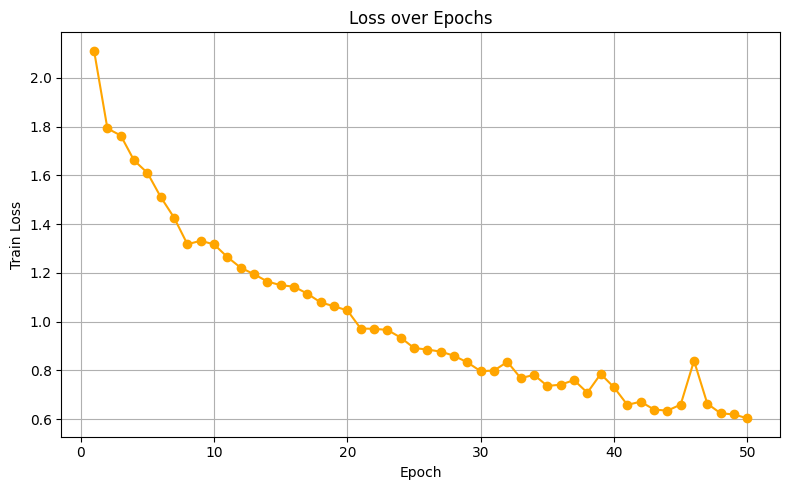

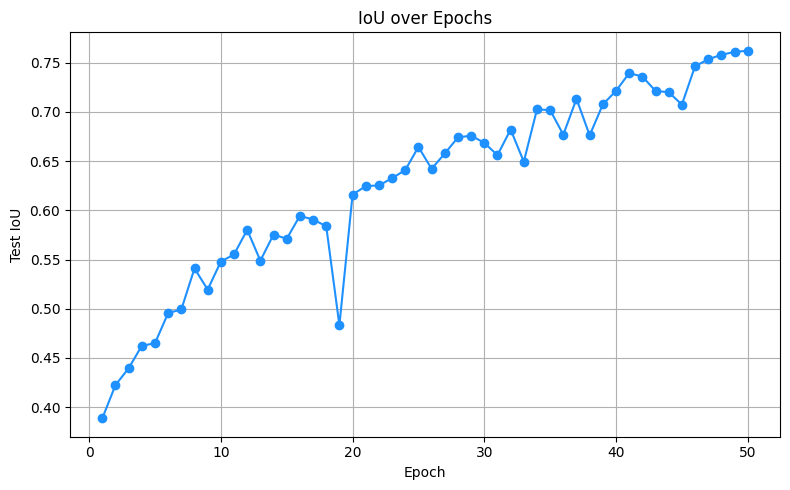

  >> Best model saved at epoch 50 with IoU: 0.7623
[10/183] Loss: 0.5658 Train Acc: 0.7863
[20/183] Loss: 0.5555 Train Acc: 0.7879
[30/183] Loss: 0.6401 Train Acc: 0.7613
[40/183] Loss: 0.5969 Train Acc: 0.7878
[50/183] Loss: 0.5692 Train Acc: 0.7808
[60/183] Loss: 0.4634 Train Acc: 0.8096
[70/183] Loss: 0.7616 Train Acc: 0.7271
[80/183] Loss: 0.5774 Train Acc: 0.7879
[90/183] Loss: 0.5531 Train Acc: 0.7856
[100/183] Loss: 0.5101 Train Acc: 0.8026
[110/183] Loss: 0.7700 Train Acc: 0.7306
[120/183] Loss: 0.6481 Train Acc: 0.7507
[130/183] Loss: 0.5706 Train Acc: 0.7816
[140/183] Loss: 0.6487 Train Acc: 0.7770
[150/183] Loss: 0.6697 Train Acc: 0.7396
[160/183] Loss: 0.5984 Train Acc: 0.7907
[170/183] Loss: 0.6109 Train Acc: 0.7923
[180/183] Loss: 0.5897 Train Acc: 0.7736
Epoch: 51, Test IoU: 0.7398


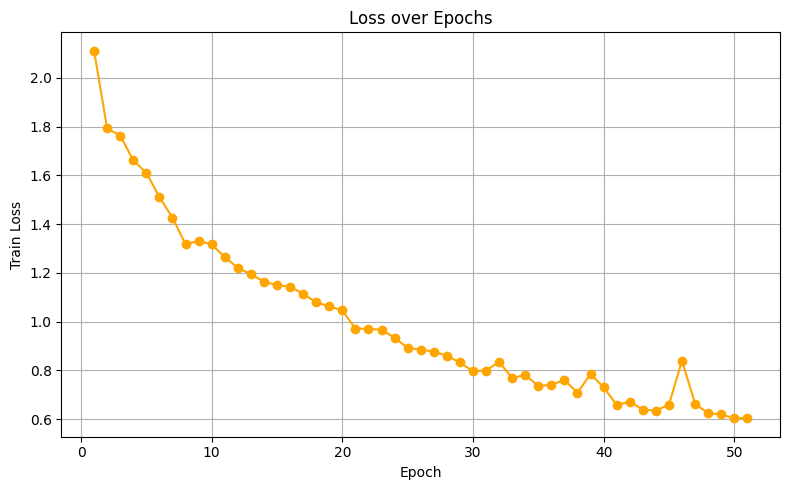

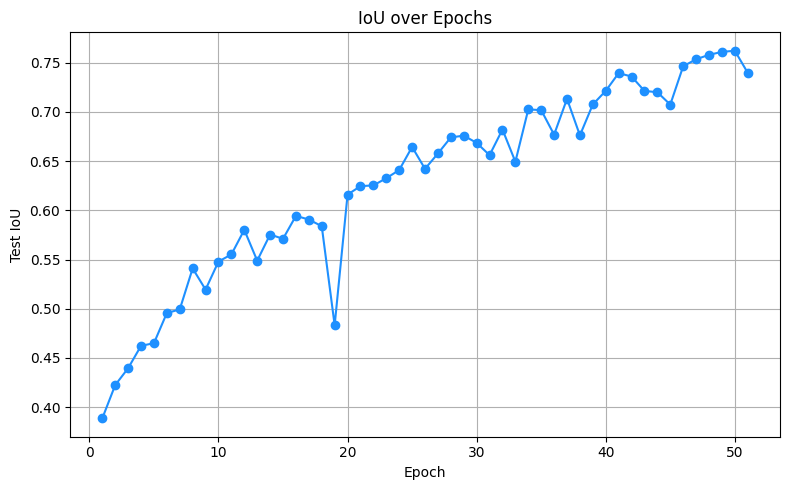

[10/183] Loss: 0.7764 Train Acc: 0.7311
[20/183] Loss: 0.7819 Train Acc: 0.7178
[30/183] Loss: 0.6573 Train Acc: 0.7640
[40/183] Loss: 0.6402 Train Acc: 0.7710
[50/183] Loss: 0.6588 Train Acc: 0.7665
[60/183] Loss: 0.6215 Train Acc: 0.7638
[70/183] Loss: 0.6079 Train Acc: 0.7750
[80/183] Loss: 0.5587 Train Acc: 0.7847
[90/183] Loss: 0.6547 Train Acc: 0.7542
[100/183] Loss: 0.5224 Train Acc: 0.8088
[110/183] Loss: 0.7095 Train Acc: 0.7513
[120/183] Loss: 0.5317 Train Acc: 0.8095
[130/183] Loss: 0.6623 Train Acc: 0.7480
[140/183] Loss: 0.6170 Train Acc: 0.7777
[150/183] Loss: 0.5457 Train Acc: 0.7905
[160/183] Loss: 0.5354 Train Acc: 0.7958
[170/183] Loss: 0.5173 Train Acc: 0.8288
[180/183] Loss: 0.5649 Train Acc: 0.7830
Epoch: 52, Test IoU: 0.7626


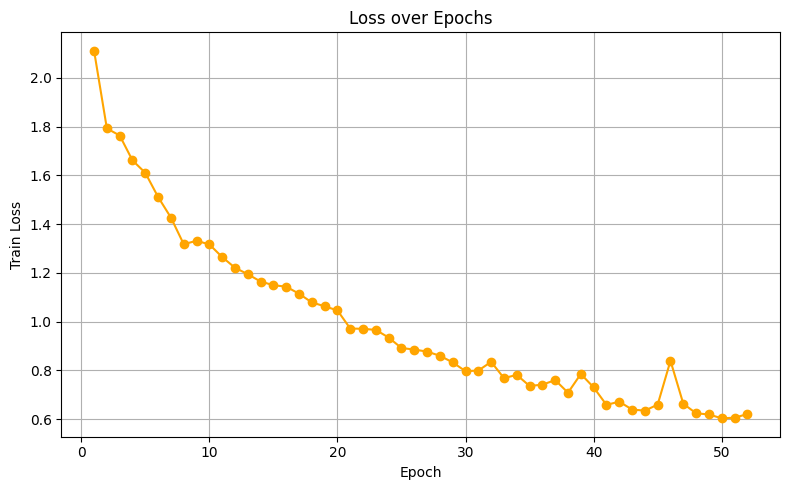

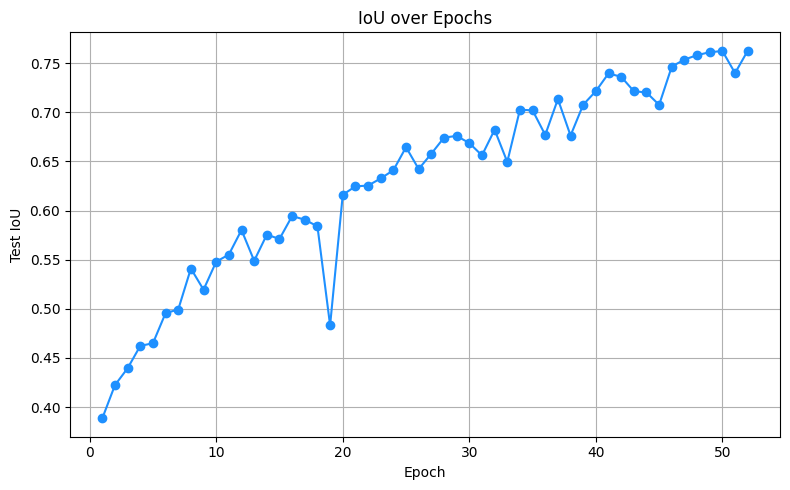

  >> Best model saved at epoch 52 with IoU: 0.7626
[10/183] Loss: 0.4953 Train Acc: 0.8037
[20/183] Loss: 0.5992 Train Acc: 0.7907
[30/183] Loss: 0.4853 Train Acc: 0.8066
[40/183] Loss: 0.5000 Train Acc: 0.8095
[50/183] Loss: 0.6016 Train Acc: 0.7782
[60/183] Loss: 0.6629 Train Acc: 0.7691
[70/183] Loss: 0.6131 Train Acc: 0.7696
[80/183] Loss: 0.5117 Train Acc: 0.8051
[90/183] Loss: 0.6221 Train Acc: 0.7672
[100/183] Loss: 0.4860 Train Acc: 0.8093
[110/183] Loss: 0.6932 Train Acc: 0.7169
[120/183] Loss: 0.5476 Train Acc: 0.7927
[130/183] Loss: 0.5906 Train Acc: 0.7709
[140/183] Loss: 0.4664 Train Acc: 0.8215
[150/183] Loss: 0.5907 Train Acc: 0.7812
[160/183] Loss: 0.5519 Train Acc: 0.8033
[170/183] Loss: 0.6062 Train Acc: 0.7669
[180/183] Loss: 0.5904 Train Acc: 0.7857
Epoch: 53, Test IoU: 0.7460


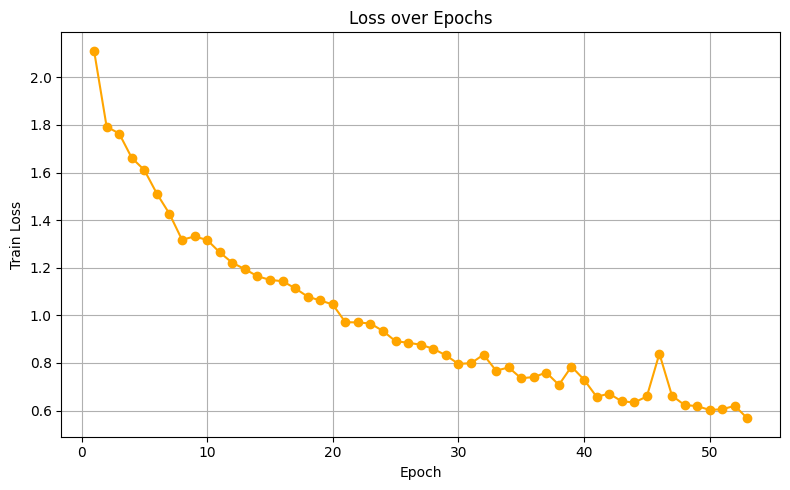

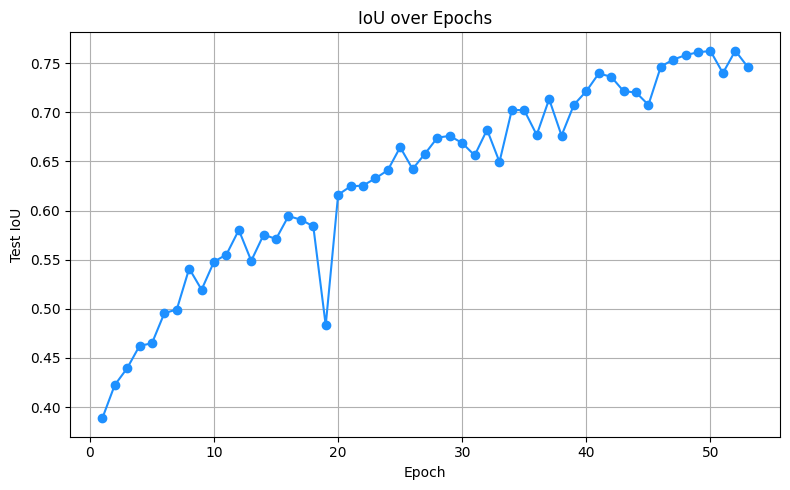

[10/183] Loss: 0.4874 Train Acc: 0.8077
[20/183] Loss: 0.6280 Train Acc: 0.7502
[30/183] Loss: 0.5511 Train Acc: 0.7964
[40/183] Loss: 0.5972 Train Acc: 0.7791
[50/183] Loss: 0.5717 Train Acc: 0.8082
[60/183] Loss: 0.5031 Train Acc: 0.8158
[70/183] Loss: 0.5983 Train Acc: 0.7937
[80/183] Loss: 0.5242 Train Acc: 0.8111
[90/183] Loss: 0.5781 Train Acc: 0.7849
[100/183] Loss: 0.7047 Train Acc: 0.7246
[110/183] Loss: 0.6271 Train Acc: 0.7700
[120/183] Loss: 0.5361 Train Acc: 0.8042
[130/183] Loss: 0.6951 Train Acc: 0.7859
[140/183] Loss: 1.1119 Train Acc: 0.6559
[150/183] Loss: 0.9486 Train Acc: 0.6642
[160/183] Loss: 0.8888 Train Acc: 0.6988
[170/183] Loss: 0.7987 Train Acc: 0.7149
[180/183] Loss: 0.6675 Train Acc: 0.7527
Epoch: 54, Test IoU: 0.7075


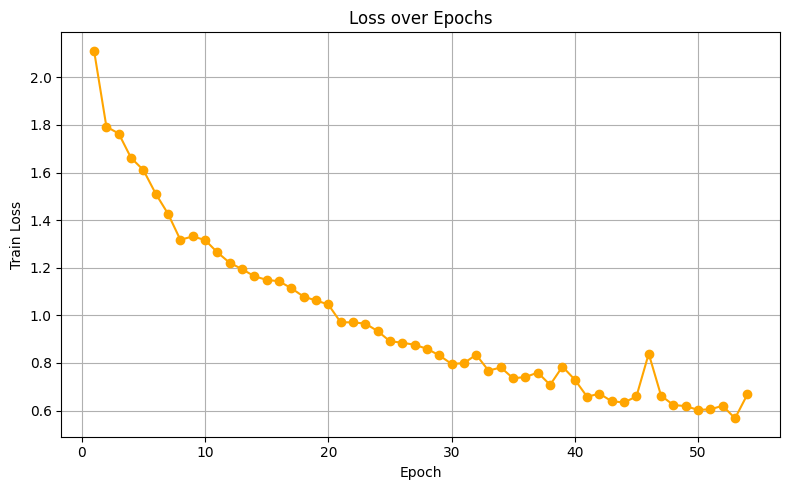

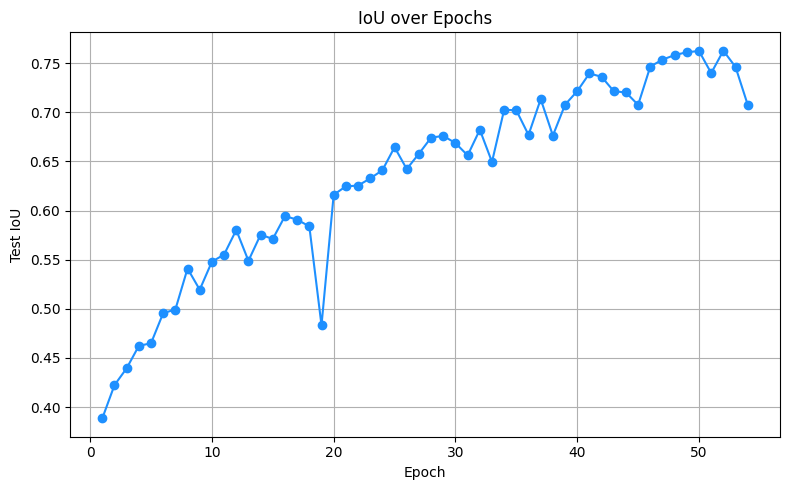

[10/183] Loss: 0.6446 Train Acc: 0.7604
[20/183] Loss: 0.7078 Train Acc: 0.7402
[30/183] Loss: 0.6509 Train Acc: 0.7566
[40/183] Loss: 0.6311 Train Acc: 0.7606
[50/183] Loss: 0.6100 Train Acc: 0.7672
[60/183] Loss: 0.5975 Train Acc: 0.7765
[70/183] Loss: 0.6421 Train Acc: 0.7486
[80/183] Loss: 0.7626 Train Acc: 0.7116
[90/183] Loss: 0.4916 Train Acc: 0.8147
[100/183] Loss: 0.6263 Train Acc: 0.7849
[110/183] Loss: 0.5802 Train Acc: 0.7728
[120/183] Loss: 0.5244 Train Acc: 0.7964
[130/183] Loss: 0.7004 Train Acc: 0.7461
[140/183] Loss: 0.4725 Train Acc: 0.8274
[150/183] Loss: 0.5853 Train Acc: 0.7849
[160/183] Loss: 0.6151 Train Acc: 0.7663
[170/183] Loss: 0.5224 Train Acc: 0.7908
[180/183] Loss: 0.6860 Train Acc: 0.7700
Epoch: 55, Test IoU: 0.7464


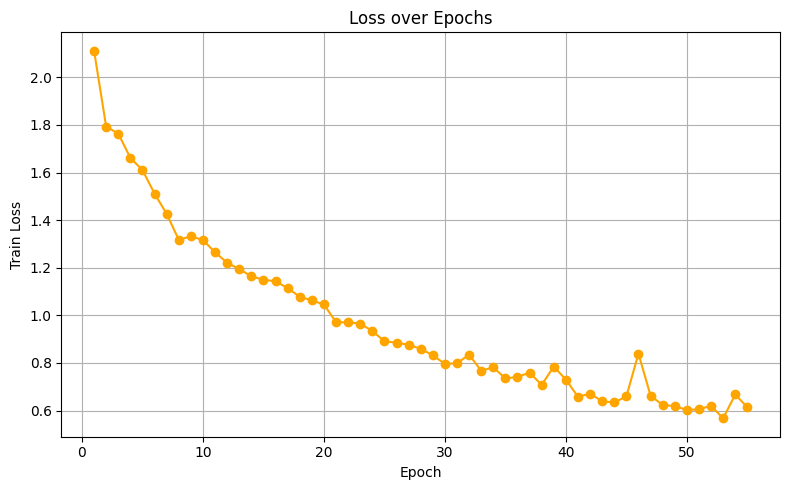

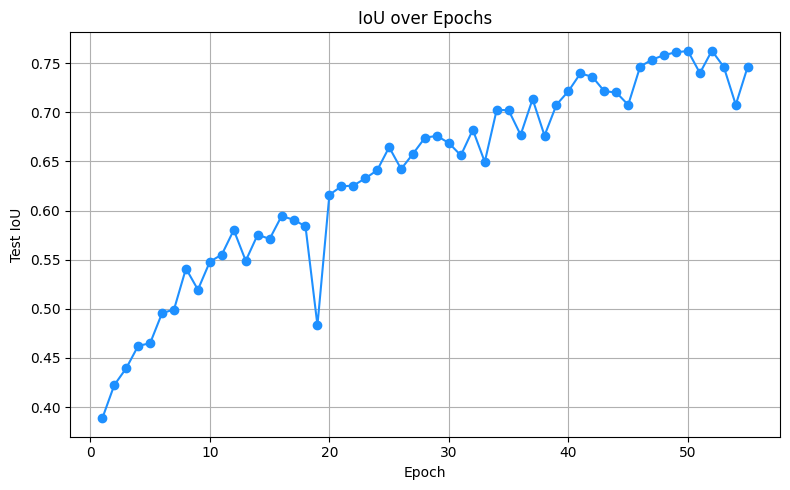

[10/183] Loss: 0.7422 Train Acc: 0.7299
[20/183] Loss: 0.5937 Train Acc: 0.7873
[30/183] Loss: 0.8758 Train Acc: 0.7135
[40/183] Loss: 0.6324 Train Acc: 0.7887
[50/183] Loss: 0.5411 Train Acc: 0.8116
[60/183] Loss: 0.5311 Train Acc: 0.7975
[70/183] Loss: 0.5798 Train Acc: 0.7683
[80/183] Loss: 0.6489 Train Acc: 0.7660
[90/183] Loss: 0.6210 Train Acc: 0.7716
[100/183] Loss: 0.5642 Train Acc: 0.8037
[110/183] Loss: 0.6366 Train Acc: 0.7637
[120/183] Loss: 0.5117 Train Acc: 0.8005
[130/183] Loss: 0.5200 Train Acc: 0.8159
[140/183] Loss: 0.5806 Train Acc: 0.7778
[150/183] Loss: 0.6048 Train Acc: 0.7625
[160/183] Loss: 0.5736 Train Acc: 0.7670
[170/183] Loss: 0.5247 Train Acc: 0.8090
[180/183] Loss: 0.6548 Train Acc: 0.7710
Epoch: 56, Test IoU: 0.7547


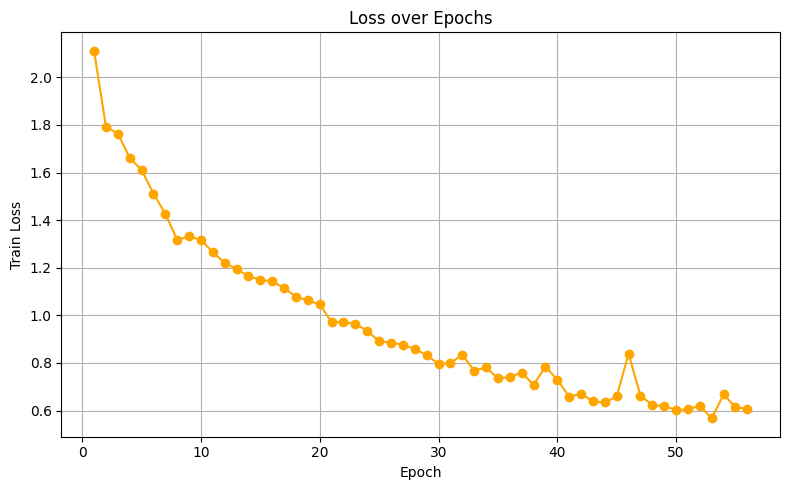

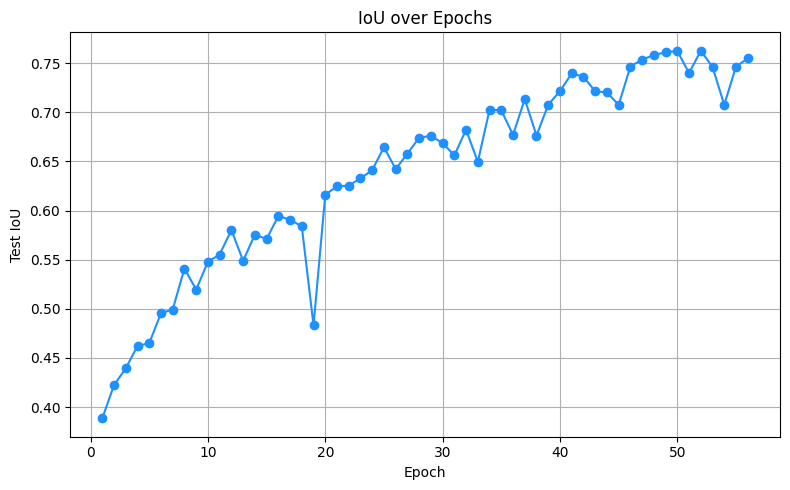

[10/183] Loss: 0.5668 Train Acc: 0.7757
[20/183] Loss: 0.5425 Train Acc: 0.8127
[30/183] Loss: 0.6602 Train Acc: 0.7545
[40/183] Loss: 0.5450 Train Acc: 0.8113
[50/183] Loss: 0.6169 Train Acc: 0.7750
[60/183] Loss: 0.5581 Train Acc: 0.7717
[70/183] Loss: 0.4493 Train Acc: 0.8273
[80/183] Loss: 0.5389 Train Acc: 0.7920
[90/183] Loss: 0.5964 Train Acc: 0.7514
[100/183] Loss: 0.5508 Train Acc: 0.7702
[110/183] Loss: 0.5486 Train Acc: 0.7945
[120/183] Loss: 0.6427 Train Acc: 0.7529
[130/183] Loss: 0.6568 Train Acc: 0.7616
[140/183] Loss: 0.6032 Train Acc: 0.7956
[150/183] Loss: 0.5603 Train Acc: 0.7950
[160/183] Loss: 0.7422 Train Acc: 0.7477
[170/183] Loss: 0.6496 Train Acc: 0.7532
[180/183] Loss: 0.5722 Train Acc: 0.7916
Epoch: 57, Test IoU: 0.7640


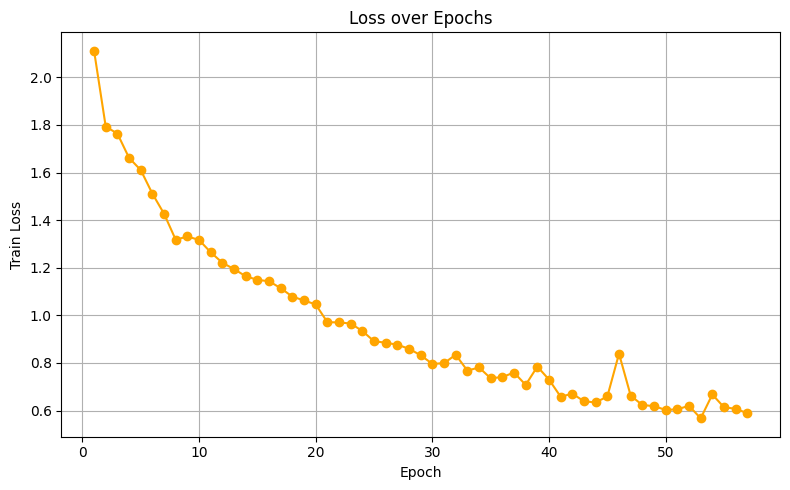

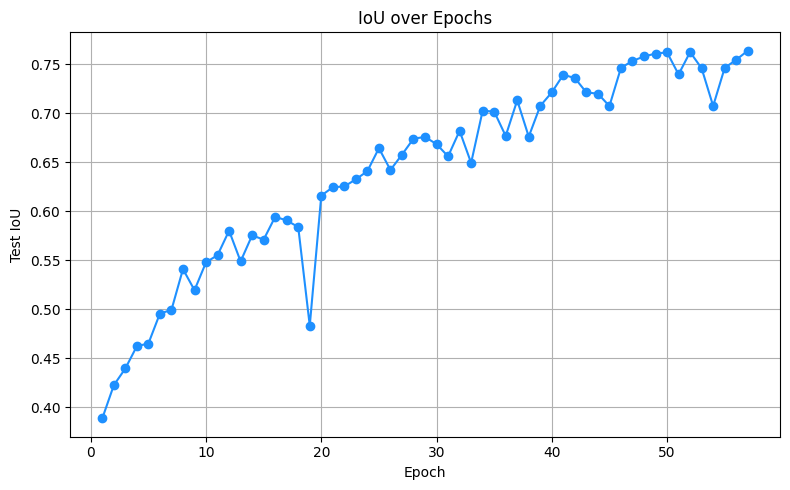

  >> Best model saved at epoch 57 with IoU: 0.7640
[10/183] Loss: 0.4906 Train Acc: 0.8112
[20/183] Loss: 0.6023 Train Acc: 0.7922
[30/183] Loss: 0.5723 Train Acc: 0.7810
[40/183] Loss: 0.6092 Train Acc: 0.7798
[50/183] Loss: 0.5417 Train Acc: 0.8005
[60/183] Loss: 0.5730 Train Acc: 0.7979
[70/183] Loss: 0.4992 Train Acc: 0.7947
[80/183] Loss: 0.5687 Train Acc: 0.8163
[90/183] Loss: 0.7134 Train Acc: 0.7457
[100/183] Loss: 0.5996 Train Acc: 0.7635
[110/183] Loss: 0.6922 Train Acc: 0.7340
[120/183] Loss: 0.6264 Train Acc: 0.7558
[130/183] Loss: 0.5241 Train Acc: 0.7994
[140/183] Loss: 0.5422 Train Acc: 0.7855
[150/183] Loss: 0.6353 Train Acc: 0.7659
[160/183] Loss: 0.5775 Train Acc: 0.7870
[170/183] Loss: 0.4908 Train Acc: 0.8175
[180/183] Loss: 0.5382 Train Acc: 0.7977
Epoch: 58, Test IoU: 0.7720


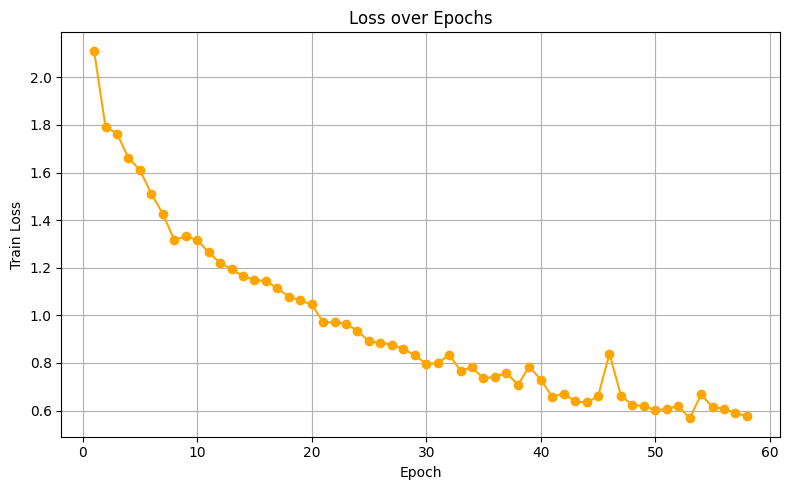

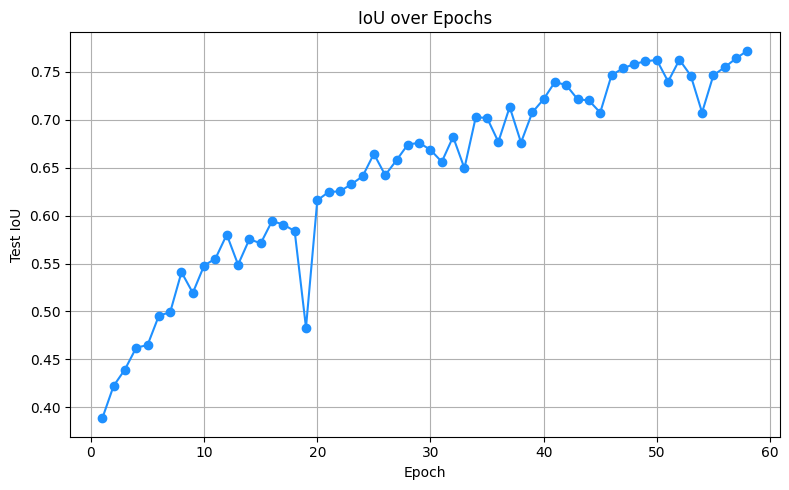

  >> Best model saved at epoch 58 with IoU: 0.7720
[10/183] Loss: 0.7294 Train Acc: 0.7451
[20/183] Loss: 0.8628 Train Acc: 0.6989
[30/183] Loss: 0.6824 Train Acc: 0.7593
[40/183] Loss: 0.6110 Train Acc: 0.7678
[50/183] Loss: 0.5697 Train Acc: 0.7895
[60/183] Loss: 0.6370 Train Acc: 0.7713
[70/183] Loss: 0.8801 Train Acc: 0.7361
[80/183] Loss: 0.7894 Train Acc: 0.7112
[90/183] Loss: 0.7312 Train Acc: 0.7620
[100/183] Loss: 0.6393 Train Acc: 0.7748
[110/183] Loss: 0.5837 Train Acc: 0.7887
[120/183] Loss: 0.5267 Train Acc: 0.7988
[130/183] Loss: 0.5952 Train Acc: 0.7736
[140/183] Loss: 0.4663 Train Acc: 0.8239
[150/183] Loss: 0.4852 Train Acc: 0.8158
[160/183] Loss: 0.4937 Train Acc: 0.8186
[170/183] Loss: 0.4958 Train Acc: 0.8080
[180/183] Loss: 0.5959 Train Acc: 0.7861
Epoch: 59, Test IoU: 0.7716


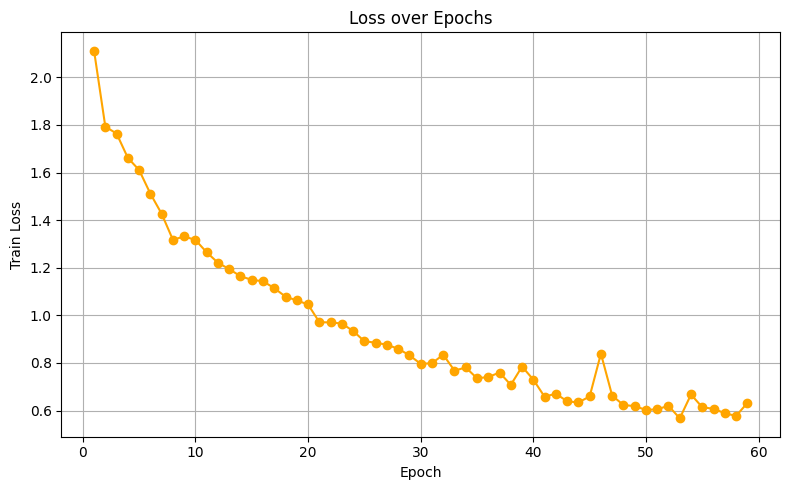

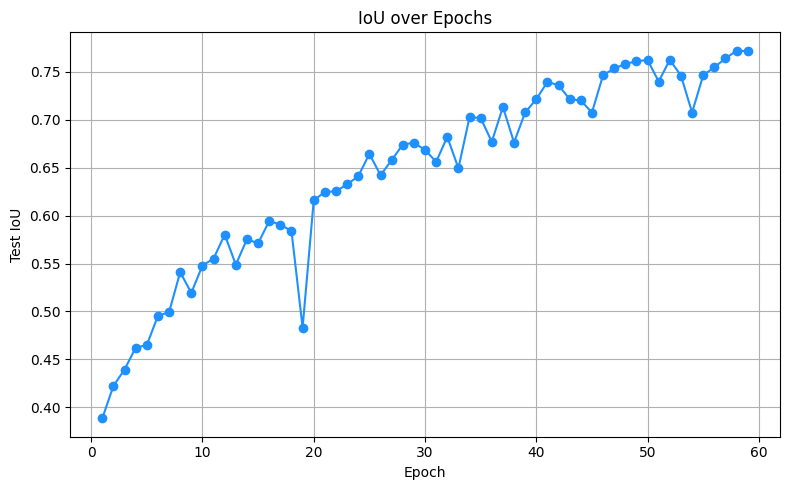

[10/183] Loss: 0.5224 Train Acc: 0.7997
[20/183] Loss: 0.5430 Train Acc: 0.7988
[30/183] Loss: 0.5488 Train Acc: 0.7962
[40/183] Loss: 0.5393 Train Acc: 0.7994
[50/183] Loss: 0.6709 Train Acc: 0.7465
[60/183] Loss: 0.5863 Train Acc: 0.7853
[70/183] Loss: 0.6009 Train Acc: 0.7800
[80/183] Loss: 0.6159 Train Acc: 0.7823
[90/183] Loss: 0.5776 Train Acc: 0.7949
[100/183] Loss: 0.5916 Train Acc: 0.7775
[110/183] Loss: 0.4313 Train Acc: 0.8574
[120/183] Loss: 0.6010 Train Acc: 0.7916
[130/183] Loss: 0.5042 Train Acc: 0.7925
[140/183] Loss: 0.5736 Train Acc: 0.7773
[150/183] Loss: 0.5521 Train Acc: 0.7821
[160/183] Loss: 0.4476 Train Acc: 0.8228
[170/183] Loss: 0.6380 Train Acc: 0.7335
[180/183] Loss: 0.5250 Train Acc: 0.7915
Epoch: 60, Test IoU: 0.7768


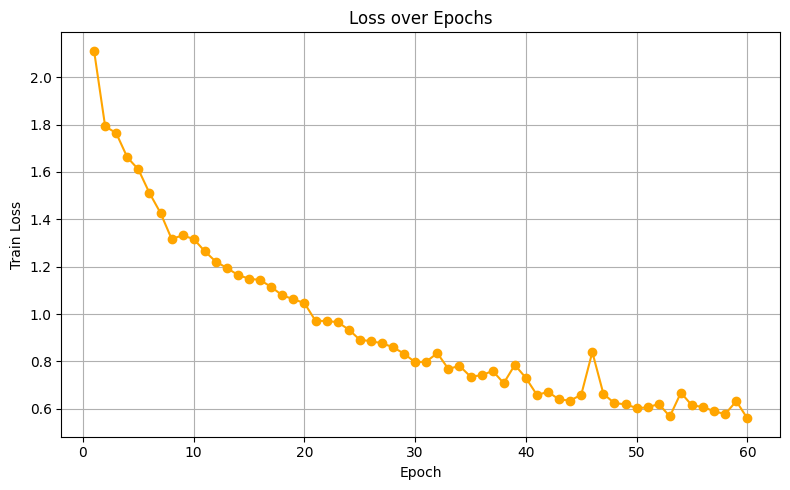

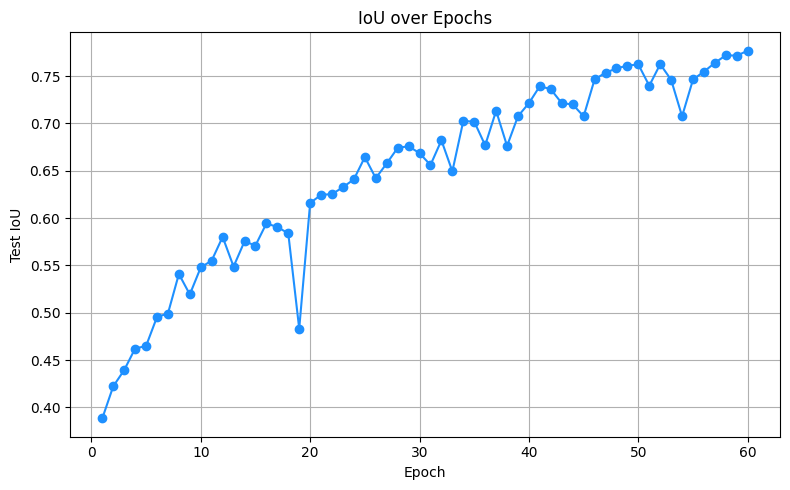

  >> Best model saved at epoch 60 with IoU: 0.7768
CPU times: user 1h 14min 59s, sys: 39.8 s, total: 1h 15min 39s
Wall time: 1h 17min 23s


In [13]:
%%time
iou_list = []
loss_list = []

best_iou = 0.0  # or float('-inf') if you're maximizing
best_model_path = "PTF.pth"

for epoch in range(1, 61):
    loss, acc = train()
    loss_list.append(loss)
    iou = test(test_loader)
    iou_list.append(iou)
    print(f'Epoch: {epoch:02d}, Test IoU: {iou:.4f}')
    plot_loss_over_epochs(loss_list)
    plot_iou_over_epochs(iou_list)
    scheduler.step()
    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), best_model_path)
        print(f"  >> Best model saved at epoch {epoch} with IoU: {best_iou:.4f}")



In [14]:
print(max(iou_list))


0.7767911553382874


#Test


In [15]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [19]:
import os
import numpy as np
from pathlib import Path

@torch.no_grad()
def predict_and_save_per_sample(loader, output_dir="break_result"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    idx = 0  # sample index

    for data in loader:
        data = data.to(device)
        outs = model(data.x, data.pos, data.batch)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)  # assume input is point positions

        ys = data.y.split(sizes)
        categories = data.category.tolist()

        for x, out, y, category in zip(xs, outs.split(sizes), ys, categories):
            category_str = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category_str]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            y_pred = out[:, part].argmax(dim=-1)
            y_true = y_map[y]

            # Save as npz
            file_path = Path(output_dir) / f"sample_{idx:04d}.npz"
            np.savez_compressed(
                file_path,
                x=x.cpu().numpy(),             # 3D points
                y_true=y_true.cpu().numpy(),   # ground truth labels
                y_pred=y_pred.cpu().numpy()    # predicted labels
            )
            idx += 1

    print(f"Saved {idx} samples to: {output_dir}")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])
pred_cmap = np.array([
    [0.054, 0.705, 0.054],  # Blue
    [1.000, 0.498, 0.054],  # Orange
])

def visualize_sample_npz(file_path):
    data = np.load(file_path)
    x = data['x']           # shape: (N, 3)
    y_true = data['y_true'] # shape: (N,)
    print(np.unique(y_true))
    y_pred = data['y_pred'] # shape: (N,)
    print(np.unique(y_pred))

    gt_colors = gt_cmap[y_true]
    pred_colors = pred_cmap[y_pred]

    fig = plt.figure(figsize=(12, 6))

    # --- Ground Truth ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], x[:, 2], c=gt_colors, s=5)
    ax1.set_title("Ground Truth Labels")
    ax1.axis('off')

    # --- Prediction ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], x[:, 2], c=pred_colors, s=5)
    ax2.set_title("Predicted Labels")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()




In [20]:

@torch.no_grad()
def eval_value(loader):
    model.eval()

    ious, categories = [], []
    correct, total = 0, 0  # For accuracy
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()

    for data in loader:
        data = data.to(device)
        outs = model(data.x, data.pos, data.batch)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            pred = out[:, part].argmax(dim=-1)
            target = y_map[y]

            correct += (pred == target).sum().item()
            total += target.numel()

            iou = jaccard_index(pred, target,
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)

        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    accuracy = correct / total

    return accuracy, float(mean_iou.mean())  # Return both Accuracy and Mean IoU

In [21]:
acc, miou = eval_value(test_loader)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.9140, Mean IoU: 0.7766


In [22]:
predict_and_save_per_sample(test_loader)

Saved 549 samples to: break_result


Sample_0540.npz
[0 1]
[0 1]


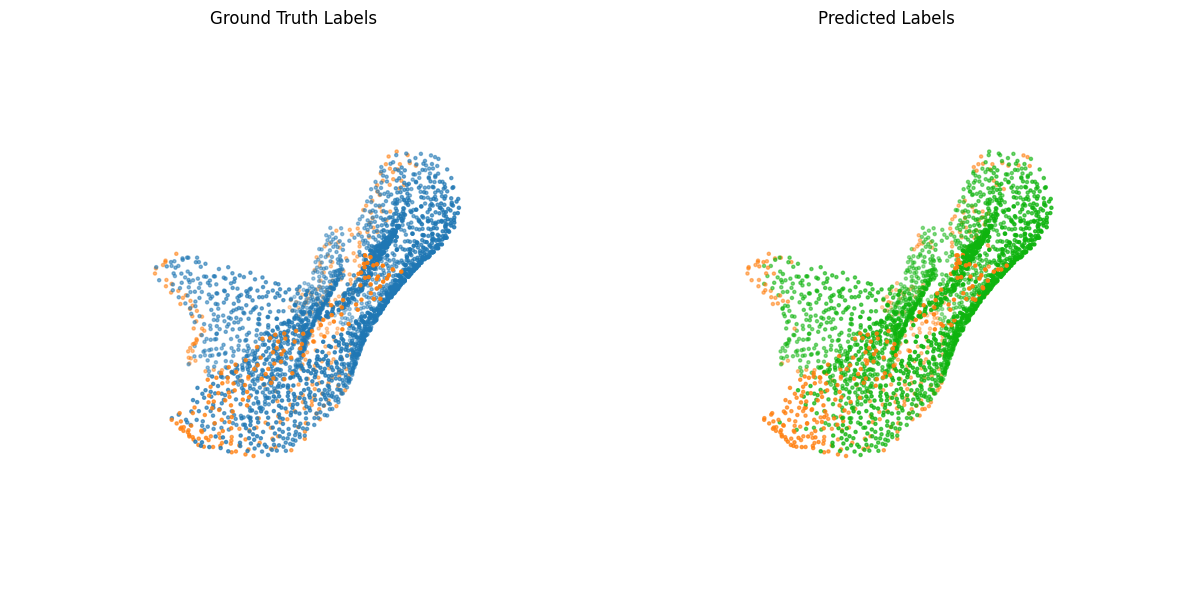

In [25]:
idx = random.randint(0, 549)
print(f"Sample_{idx:04d}.npz")
visualize_sample_npz(f"/content/break_result/sample_{idx:04d}.npz")

#fanta


In [ ]:
!rm -r /content/data2

In [26]:
!unzip /content/processed_fanta_v4.zip -d /content/temp_extract
!mkdir /content/data2
!mkdir /content/data2/raw
!mv /content/temp_extract/processed_fanta_v4/* /content/data2/raw
!rm -r /content/temp_extract

Archive:  /content/processed_fanta_v4.zip
   creating: /content/temp_extract/processed_fanta_v4/
   creating: /content/temp_extract/processed_fanta_v4/abc/
  inflating: /content/temp_extract/processed_fanta_v4/abc/00002.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00003.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00005.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00006.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00008.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00011.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00012.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00013.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00014.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00015.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00016.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00017.txt  
  in

In [27]:

class FantaBrk(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {'All_Statue': 'abc'}



    seg_classes = {'All_Statue': [0, 1]}

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {'abc': 0}
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [28]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data2"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset2 = FantaBrk(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset2 = FantaBrk(path, category, split='test',
                        pre_transform=pre_transform)
train_loader2 = DataLoader(train_dataset2, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader2 = DataLoader(test_dataset2, batch_size=12, shuffle=False,
                         num_workers=2)

['All_Statue']


Processing...


['All_Statue']


Done!


Unique classes [0 1]


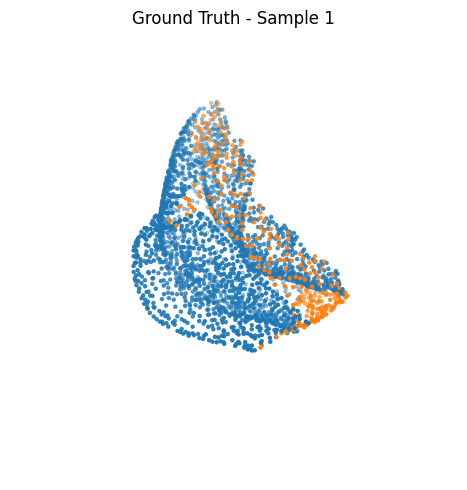

Unique classes [0 1]


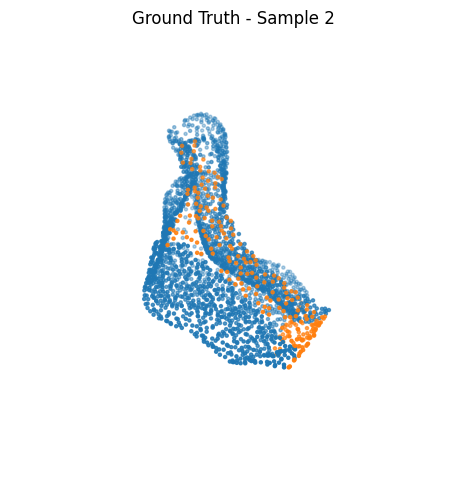

Unique classes [0 1]


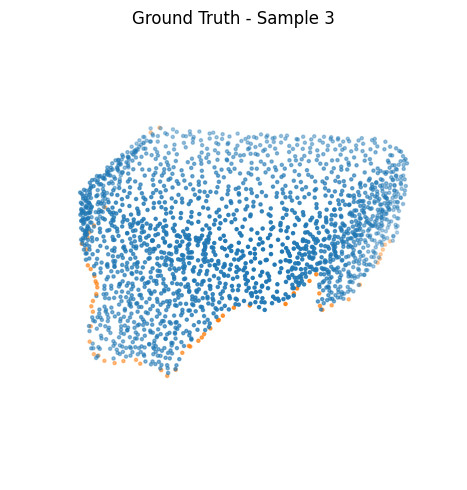

Unique classes [0 1]


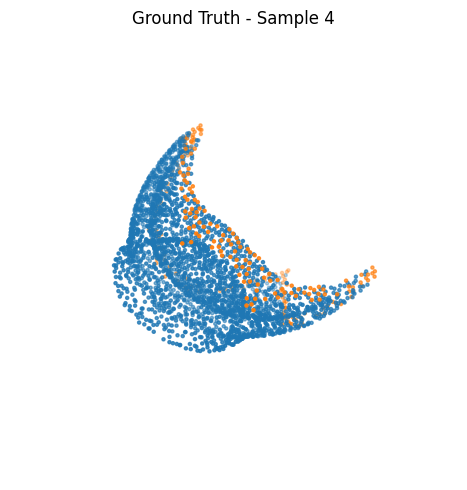

In [29]:
visualize_ground_truth_3d(test_loader2, num_samples=4)

In [46]:
import torch

@torch.no_grad()
def eval_value_unseen(loader):
    model.eval()

    ious = []
    correct, total = 0, 0

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.pos, data.batch)  # Shape: [num_points, num_classes]

        # Predict across ALL classes
        pred = out.argmax(dim=-1)%2
        # print(pred)
        target = data.y

        # Accuracy
        correct += (pred == target).sum().item()
        total += target.numel()

        # IoU (mean across classes in this sample)
        iou = jaccard_index(pred, target,num_classes=2, absent_score=1.0)
        ious.append(iou)

    accuracy = correct / total
    mean_iou = np.mean(ious)

    return accuracy, mean_iou


In [51]:

@torch.no_grad()
def predict_and_save_per_sample_unseen(loader, output_dir="break_result"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    idx = 0  # sample index

    for data in loader:
        data = data.to(device)
        outs = model(data.x, data.pos, data.batch)  # shape: [num_points, num_classes]

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)   # point positions
        ys = data.y.split(sizes)     # ground truth labels
        outs_split = outs.split(sizes)

        for x, out, y in zip(xs, outs_split, ys):
            y_pred = out.argmax(dim=-1)%2  # predict across all classes
            y_true = y                   # keep original labels

            # Save as npz
            file_path = Path(output_dir) / f"sample_{idx:04d}.npz"
            np.savez_compressed(
                file_path,
                x=x.cpu().numpy(),             # 3D points
                y_true=y_true.cpu().numpy(),   # ground truth labels
                y_pred=y_pred.cpu().numpy()    # predicted labels
            )
            idx += 1

    print(f"Saved {idx} samples to: {output_dir}")

In [48]:
acc, miou = eval_value_unseen(train_loader2)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.7954, Mean IoU: 0.4186


In [52]:
length = predict_and_save_per_sample_unseen(train_loader2,output_dir = "fanta_result")

Saved 120 samples to: fanta_result


Sample_0086.npz
[0 1]
[0 1]


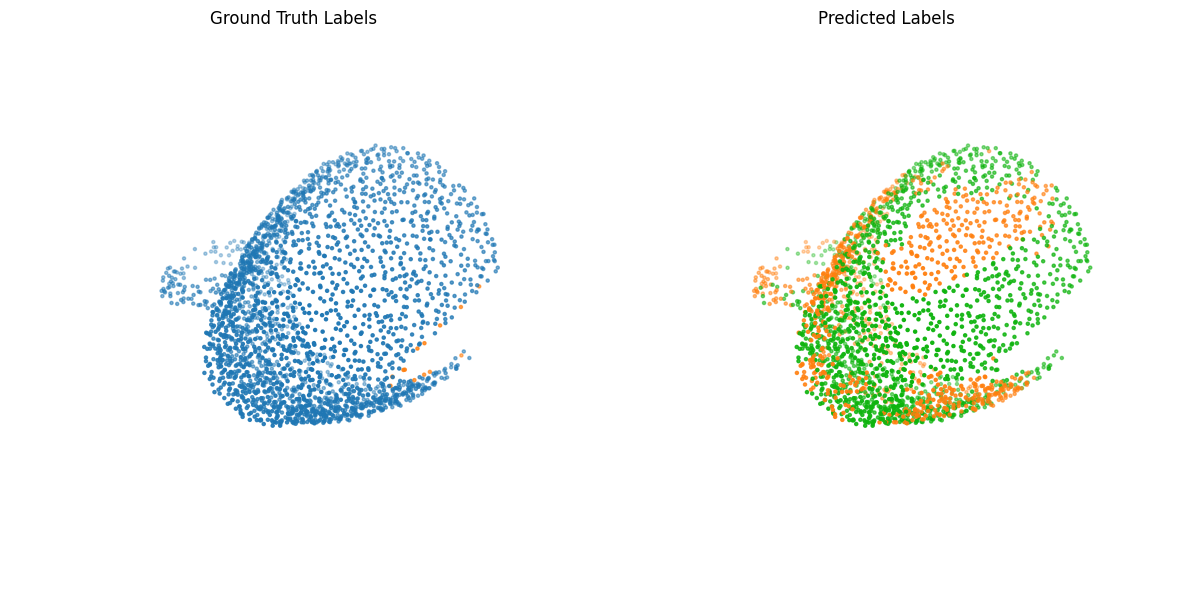

Sample_0100.npz
[0 1]
[0 1]


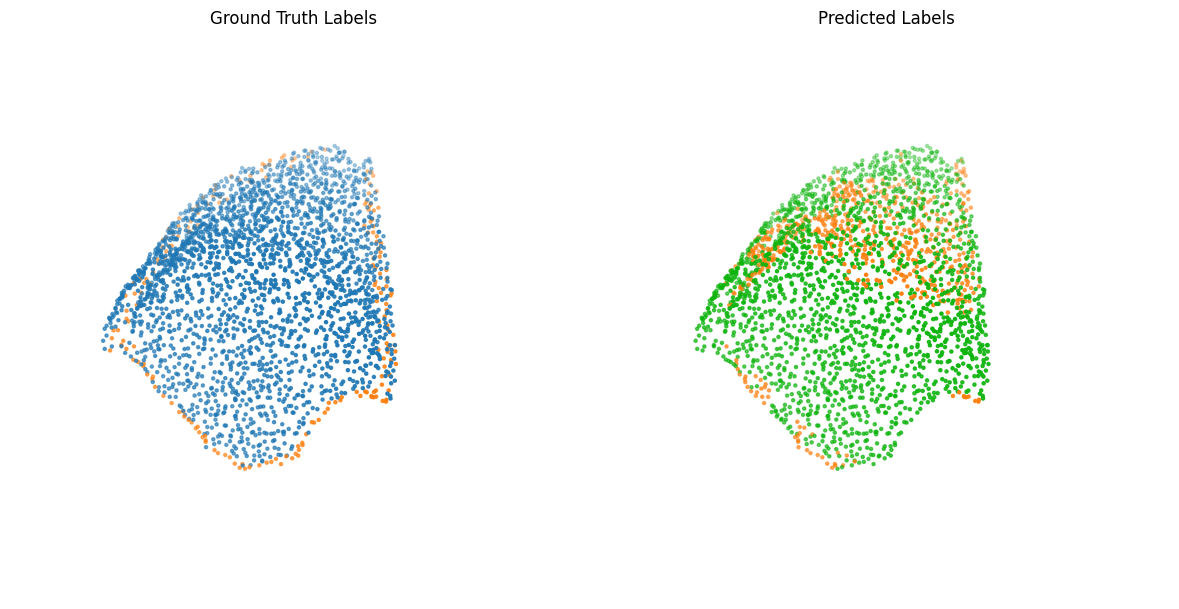

Sample_0078.npz
[0 1]
[0 1]


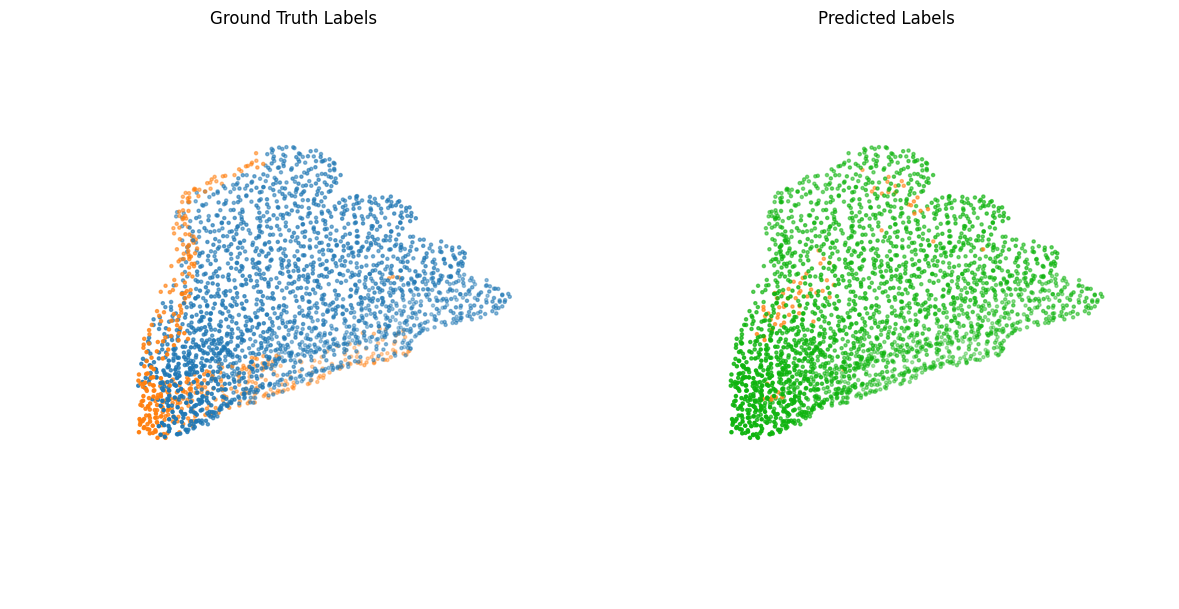

Sample_0033.npz
[0 1]
[0 1]


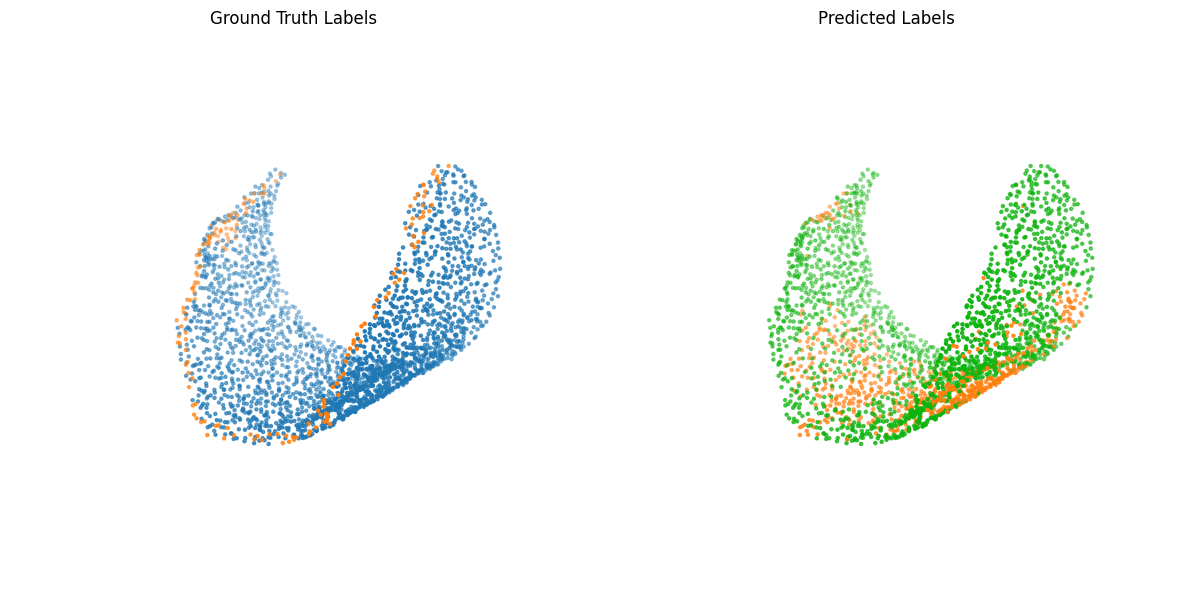

Sample_0023.npz
[0 1]
[0 1]


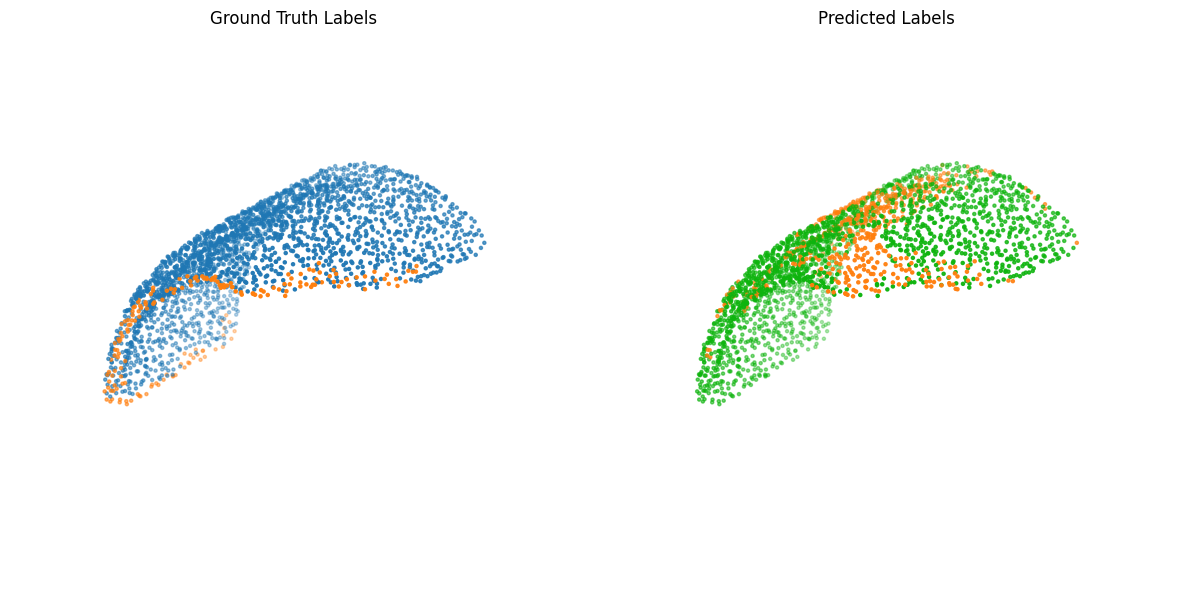

In [55]:
def wow2():
  idx = random.randint(0, 120)
  print(f"Sample_{idx:04d}.npz")
  visualize_sample_npz(f"/content/fanta_result/sample_{idx:04d}.npz")

wow2()

wow2()

wow2()
wow2()

wow2()

In [56]:
!mkdir -p output
!cp -r /content/break_result output/
!cp -r /content/fanta_result output/
!cp /content/PTF.pth output/
!zip -r PTF.zip output

from google.colab import files
files.download("PTF.zip")

  adding: output/ (stored 0%)
  adding: output/PTF.pth (deflated 7%)
  adding: output/break_result/ (stored 0%)
  adding: output/break_result/sample_0450.npz (deflated 0%)
  adding: output/break_result/sample_0248.npz (deflated 0%)
  adding: output/break_result/sample_0140.npz (deflated 0%)
  adding: output/break_result/sample_0051.npz (deflated 0%)
  adding: output/break_result/sample_0009.npz (deflated 0%)
  adding: output/break_result/sample_0203.npz (deflated 0%)
  adding: output/break_result/sample_0436.npz (deflated 0%)
  adding: output/break_result/sample_0006.npz (deflated 0%)
  adding: output/break_result/sample_0286.npz (deflated 0%)
  adding: output/break_result/sample_0184.npz (deflated 0%)
  adding: output/break_result/sample_0110.npz (deflated 0%)
  adding: output/break_result/sample_0127.npz (deflated 0%)
  adding: output/break_result/sample_0517.npz (deflated 0%)
  adding: output/break_result/sample_0314.npz (deflated 0%)
  adding: output/break_result/sample_0291.npz (d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>